In [1]:
# from MF import *
import pickle

In [6]:
# %%writefile MF.py
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
class Params:
    def __init__(self,t,U,h,nu,aM0=1,n=21,hartree=True, fock=True):
        self.t=t
        self.U=U
        self.h=h
        self.nu=nu
        self.aM0=aM0
        self.n=n
        self.hartree=hartree
        self.fock=fock
        # original lattice
        self.aM=self.aM0*np.array([[np.cos(np.deg2rad(-120)),np.sin(np.deg2rad(-120))],[np.cos(np.deg2rad(-60)),np.sin(np.deg2rad(-60))]])
        self.bM0=4*np.pi/(np.sqrt(3)*self.aM0)
        self.g=[np.array([np.cos(np.deg2rad(x)),np.sin(np.deg2rad(x))])*self.bM0 for x in np.arange(6)*60+30]
        self.bM=np.array([self.g[5],self.g[1]])
        self.neighbor_list=self._generate_neighbor()
        self._generate_ansatz()
        self._generate_k_mesh()
        self.high_symm=self._generate_high_symm()
        self.delta,self.delta12,self.expqq,=self._generate_delta() # q1,q2,q3,q4; q1,q2; n,q1,q2 
        self.expkk =self._generate_expkk() # n,k1,k2
        self.sigma=_generate_pauli_matrix()
        self.print_info()
        

    # Checked
    def _generate_neighbor(self):
        '''
        neighbor_list: unit cell
        '''
        neighbor_list={}
        neighbor_list[0]=np.array([self.aM[0]*0])
        neighbor_list[1]=np.array([self.aM[0]*0,self.aM[0],self.aM[1]])
        # neighbor_list[1]=np.array([-1/3*(self.aM[0]+self.aM[1]),1/3*(2*self.aM[0]-self.aM[1]),1/3*(2*self.aM[1]-self.aM[0])])
        neighbor_list[2]=np.array([self.aM[0],self.aM[1],self.aM[1]-self.aM[0],-self.aM[0],-self.aM[1],-self.aM[1]+self.aM[0]])
        # neighbor_list[2]=np.array([self.aM[0],self.aM[1],self.aM[1]-self.aM[0],-self.aM[0],-self.aM[1],-self.aM[1]+self.aM[0]])
        return neighbor_list

    # Checked
    def _generate_k_mesh(self):
        R=np.array([[0,-1],[1,0]])
        self.bm_index=1/(self.ai_index).shape[0]*R.T@self.am_index@R
        self.am=self.am_index@self.aM # am_index=[[h1,h2],[k1,k2]], aM=[aM1;aM2]
        self.bm=self.bm_index@self.bM # same as above
        ux,uy=np.meshgrid(np.arange(self.n),np.arange(self.n),indexing='ij')
        kx=(2*ux.flatten(order='F')-self.n+1)/(self.n*2)
        ky=(2*uy.flatten(order='F')-self.n+1)/(self.n*2)
        self.k_index=np.column_stack((kx,ky))
        self.k=self.k_index@self.bm
        self.q=self.q_index@self.bM
        self.ai=self.ai_index@self.aM

    # Checked
    def _generate_high_symm(self):
        # Caveat: this is assuming the super cell is still triangular lattice
        K_=(self.bm[0]+2*self.bm[1])/3
        Kp_=(-self.bm[0]+self.bm[1])/3
        M_=self.bm[1]/2
        G_=0*self.bm[0]

        G_M_K_G_kx,G_M_K_G_ky,G_M_K_G_dist,G_M_K_G_name=generate_line([G_,M_,K_,G_], self.n, [r'$\Gamma$',r'M',r'$\kappa$',r'$\Gamma$']) 

        K_M_Kp_G_kx,K_M_Kp_G_ky,K_M_Kp_G_dist,K_M_Kp_G_name=generate_line([K_,M_,Kp_,G_], self.n, [r'$\kappa$',r'M',r'$\kappa^\prime$',r'$\Gamma$']) 

        K6_kx,K6_ky,K6_dist,K6_name=generate_line([rotation(60*x)@K_ for x in range(7)], self.n, [rf'$\kappa_{i+1}$' for i in range(7)]) 

        K3_kx,K3_ky,K3_dist,K3_name=generate_line([rotation(120*x)@K_ for x in range(4)], self.n, [rf'$\kappa_{i+1}$' for i in range(4)]) 
        

        return {'kappa':K_,'M':M_,'Gamma':G_,'kappa_p':Kp_,
        'G_M_K_G':np.column_stack((G_M_K_G_kx,G_M_K_G_ky)),'G_M_K_G_dist':G_M_K_G_dist,'G_M_K_G_name':G_M_K_G_name,
        'K_M_Kp_G':np.column_stack((K_M_Kp_G_kx,K_M_Kp_G_ky)),'K_M_Kp_G_dist':K_M_Kp_G_dist,'K_M_Kp_G_name':K_M_Kp_G_name,
        'K6':np.column_stack((K6_kx,K6_ky)),'K6_dist':K6_dist,'K6_name':K6_name,
        'K3':np.column_stack((K3_kx,K3_ky)),'K3_dist':K3_dist,'K3_name':K3_name,
        }

    def print_info(self):
        resolution=np.sqrt(2*np.pi/(np.sqrt(3)*1/4)/(self.q.shape[0]*self.k.shape[0]))*np.sqrt(3)/2*np.abs(self.t[1])
        print(f'Energy resolution: {resolution}',flush=True)

    def _generate_ansatz(self):
        if self.nu==[-6,-3]:
            # Charge modulation
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            self.spinA0=[[1,0,0,0],[1,0,0,0],[1,0,0,0]]
            self.spinB0=[[1,0,0,0],[1,0,0,0],[1,0,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
        if self.nu==[-4,-2]:
            # Charge modulation
            self.ai_index=np.array([[0,0]])
            self.spinA0=[[1,0,0,0]]
            self.spinB0=[[1,0,0,0]]
            self.am_index=np.eye(2) 
            self.q_index=np.array([[0,0]])
        if self.nu==[-2,-1]:
            # Unpolarized
            self.ai_index=np.array([[0,0]])
            self.spinA0=[[2,0,0,0]]
            self.spinB0=[[0,0,0,0]]
            self.am_index=np.eye(2) 
            self.q_index=np.array([[0,0]])
        
        if self.nu==[2,1]:
            self.ai_index=np.array([[0,0]])
            self.spinA0=[[1,1,0,0]]
            self.spinB0=[[1,-1,0,0]]
            self.am_index=np.eye(2) 
            self.q_index=np.array([[0,0]])
        if self.nu==[4,2]:
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])

        if self.nu==[-12,-6]:
            # Intravalley s wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            self.O_max=np.array([[40,0],[0,40]])
            self.l=np.zeros((2,2))
        if self.nu==[12,6]:
            # Intravalley s wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            self.O_max=np.array([[160,0],[0,-160]])
            self.l=np.zeros((2,2))

        if self.nu==[14,7]:
            # Intervalley s wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            self.O_max=np.array([[0,20],[20,0]])
            # self.O_max=np.array([[0,0],[160,0]])
            self.l=np.zeros((2,2))

        if self.nu==[16,8]:
            # Intravalley p wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            
            self.O_max=np.array([[-160,0],[0,-160]])
            self.l=np.diag([-1,1])
            # self.O_max=np.array([[160,0],[0,-160]])
            # self.l=np.ones((2,2))

        if self.nu==[18,9]:
            # Intervalley p wave
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
            self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
            # self.O_max=np.array([[0,0],[160,0]])
            self.O_max=np.array([[0,160],[160,0]])
            # self.l=np.ones((2,2))
            self.l=np.array([[0,1],[1,0]])

        # if self.nu==[-18,-9]:
        #     # Intervalley p wave
        #     self.ai_index=np.array([[0,0],[1,0],[2,0]])
        #     # self.spinA0=[[1,1,0,0],[1,1,0,0],[1,1,0,0]]
        #     # self.spinB0=[[1,-1,0,0],[1,-1,0,0],[1,-1,0,0]]
        #     self.am_index=np.array([[1,1],[2,-1]])
        #     # self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
        #     self.q_index=np.array([[0,0],[2/3,1/3],[-2/3,-1/3]])
        #     # self.O_max=np.array([[0,0],[160,0]])
        #     self.O_max=np.array([[0,160],[160,0]])
        #     # self.l=np.ones((2,2))
        #     self.l=np.array([[0,1],[-1,0]])

        if self.nu==[6,3]:
            # SDW 120 Neel
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            self.spinA0=[[1,-1,0,0],[1,-np.cos(np.deg2rad(120)),-np.sin(np.deg2rad(120)),0],[1,-np.cos(np.deg2rad(240)),-np.sin(np.deg2rad(240)),0]]
            # self.spinB0=[[1,-1,0,0],[1,-np.cos(np.deg2rad(120)),-np.sin(np.deg2rad(120)),0],[1,-np.cos(np.deg2rad(240)),-np.sin(np.deg2rad(240)),0]]
            self.spinB0=[[1,0,0,0],[1,0,0,0],[1,0,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])


        if self.nu==[10,5]:
            # SDW 120 Neel
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            self.spinA0=[[1,1,0,0],[1,np.cos(np.deg2rad(120)),np.sin(np.deg2rad(120)),0],[1,np.cos(np.deg2rad(240)),np.sin(np.deg2rad(240)),0]]
            # self.spinB0=[[1,-1*.1,0,0],[1,-np.cos(np.deg2rad(120))*.1,-np.sin(np.deg2rad(120))*.1,0],[1,-np.cos(np.deg2rad(240))*.1,-np.sin(np.deg2rad(240))*.1,0]]
            self.spinB0=[[1,0,0,0],[1,0,0,0],[1,0,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])


        if self.nu==[8,4]:
            # triplet pairing
            self.ai_index=np.array([[0,0],[1,0],[2,0]])
            # self.spinA0=[[1,1,0,0],[1,-1/2,0,0],[1,-1/2,0,0]]
            # self.spinB0=[[1,-1,0,0],[1,1/2,0,0],[1,1/2,0,0]]
            self.spinB0=[[1,1,0,0],[1,np.cos(np.deg2rad(120)),np.sin(np.deg2rad(120)),0],[1,np.cos(np.deg2rad(240)),np.sin(np.deg2rad(240)),0]]
            self.spinA0=[[1,0,0,0],[1,0,0,0],[1,0,0,0]]
            self.am_index=np.array([[1,1],[2,-1]])
            self.q_index=np.array([[0,0],[1/3,2/3],[2/3,1/3]])
        
    # Obsolete
    def _ansatz_to_momentum(self):
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        cc=np.zeros((Nq,2,2,2,2),dtype=complex) # a,s1,s2,α1,α2
        for ai_idx,ai in enumerate(self.ai_index):
            ccA=1/2*np.sum([self.spinA0[ai_idx][i]*self.sigma[i] for i in range(4)],axis=0).conj()
            ccB=1/2*np.sum([self.spinB0[ai_idx][i]*self.sigma[i] for i in range(4)],axis=0).conj()
            cc[ai_idx,:,:,0,0]=ccA
            cc[ai_idx,:,:,1,1]=ccB
        ai_x,q1_x,q2_x=np.meshgrid(self.ai[:,0],self.q[:,0],self.q[:,0],indexing='ij')
        ai_y,q1_y,q2_y=np.meshgrid(self.ai[:,1],self.q[:,1],self.q[:,1],indexing='ij')
        exp=np.exp(1j*((q1_x-q2_x)*ai_x+(q1_y-q2_y)*ai_y)) # a,q1,q2
        ave=np.tensordot(exp, cc,axes=([0],[0])) # q1,q2,s1,s2,α1,α2
        ave=np.tile(ave[:,:,:,:,:,:,np.newaxis],[1,1,1,1,1,1,Nk])/Nq # q1,q2,s1,s2,α1,α2, k
        ave=np.transpose(ave,axes=(6,0,2,4,1,3,5)) # k,q1,s1,α1, q2,s2,α2
        return ave
    
    # Checked
    def _ansatz_from_order_parameter(self,O_max,l=np.zeros((2,2))):
        '''
        O is a 4 by 4 matrix defined by 
        <+K-↑ , +K+↓> <+K-↑ , -K+↓>
        <-K-↑ , +K+↓> <-K-↑ , -K+↓>
        for h>0
        or 
        <+K-↓ , +K+↑> <+K-↓ , -K+↑>
        <-K-↓ , +K+↑> <-K-↓ , -K+↑>
        for h<0

        Return: ave_(k',q1,s1,α1, q2,s2,α2)
        '''
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        theta_k=np.angle(self.k[:,0]+1j*self.k[:,1])
        norm_k=np.abs(self.k[:,0]+1j*self.k[:,1])
        exp_theta_k=np.exp(1j*theta_k)
        ave=np.zeros((Nk,Nq,2,2,Nq,2,2),dtype=complex)
        k_F=np.abs(np.abs(self.h)/(np.sqrt(3)/2*self.t[1]*self.aM0))
        for k_idx in range(ave.shape[0]):
            O=O_max* np.exp(-(norm_k[k_idx]-k_F)**2/(2*(k_F/4)**2))*np.exp(1j*l*theta_k[k_idx])
            # O=O_max*np.exp(1j*l*theta_k[k_idx])
            OO=np.array(
                [[O[0,0]/2, O[0,0]*exp_theta_k[k_idx]/2, -O[0,1]*exp_theta_k[k_idx]/2, O[0,1]/2],
                [-O[0,0]*exp_theta_k[k_idx].conj()/2,  -O[0,0]/2,  O[0,1]/2,  -O[0,1]*exp_theta_k[k_idx].conj()/2],
                [O[1,0]*exp_theta_k[k_idx].conj()/2,  O[1,0]/2,  -O[1,1]/2,  O[1,1]*exp_theta_k[k_idx].conj()/2],
                [O[1,0]/2,  O[1,0]*exp_theta_k[k_idx]/2,  -O[1,1]*exp_theta_k[k_idx]/2,  O[1,1]/2]])
            block=self.sigma['+'] if self.h>=0 else self.sigma['-']
            OOO=np.kron(block,OO)+np.kron(block,OO).conj().T # (s,q,α),(s,q,α)
            OOO_2=np.reshape(OOO,(2,2,2,2,2,2)) # s1,q1,α1,s2,q2,α2
            OOO_3=np.transpose(OOO_2,(1,0,2,4,3,5)) # q1,s1,α1,q2,s2,α2
            ave[k_idx,1:,:,:,1:,:,:]=OOO_3
        return ave
            
    # Revised
    def energy_MF(self,ave):
        '''
        T,H_H,H_F: k, (q1,s1,α1),(q2,s2,α2)
        '''
        T=self._generate_T(self.k)
        H_H=self._generate_Hartree(ave) if self.hartree else 0
        H_F=self._generate_Fock(ave) if self.fock else 0
        H=T+H_H+H_F
        energyall,wfall=self._eig(H)
        return energyall,wfall
    # Unchecked
    def iteration(self,print_opt='o',thres=1e-5,iter_max=300,plot=False):
        ave=self._ansatz_to_momentum() if not hasattr(self, 'O_max') else self._ansatz_from_order_parameter(self.O_max,self.l)
        gap_list=[]
        spin_list=[]
        energy_list=[]
        gap_list.append(np.nan)
        energy_list.append(np.nan)
        spin_list.append(self.print_spin(ave,print_opt))
        for i in range(iter_max):
            energyall,wfall=self.energy_MF(ave)
            ave=self._average(energyall, wfall)
            print(f'Iteration {i}:\t',end=None)
            gap_list.append(self.print_gap(energyall))
            energy_list.append(self.total_energy(ave))
            spin_list.append(self.print_spin(ave,print_opt))
            if plot:
                self.plot_dispersion(ave)
            if i>0 and np.abs(energy_list[-1]-energy_list[-2])<thres:
                break

        return np.array(gap_list),np.array(energy_list),np.array(spin_list),ave
    # Checked  
    def _eig(self,H):
        '''
        H: k, (q1,s1,α1),(q2,s2,α2)
        '''
        herr=np.abs(H-H.transpose((0,2,1)).conj()).max()
        assert herr<1e-12, f'hermittian error:{herr}'
        H=1/2*(H+H.transpose((0,2,1)).conj())
        Nk,Nq=H.shape[0],self.q.shape[0]
        energyall=np.zeros((Nk,Nq*4),dtype=float)   # k, l
        wfall=np.zeros((Nk,Nq*4,Nq*4),dtype=complex)    #k,l,l
        for k_idx in range(Nk):
            H0=H[k_idx,:,:]
            val,vec=np.linalg.eigh(H0)
            order=np.argsort(val)
            vec=vec[:,order]
            val=val[order]
            energyall[k_idx]=val
            wfall[k_idx]=vec.T
        return energyall,wfall
    # Checked 
    def _generate_T(self,k_list):
        '''
        T: k, (q1,s1,α1),(q2,s2,α2)
        '''
        Nq,Nk=self.q.shape[0],k_list.shape[0]
        T=np.zeros((Nk,2*2*Nq,2*2*Nq),dtype=complex)
        for k_idx,k in enumerate(k_list):
            T0=np.zeros((2*2*Nq,2*2*Nq),dtype=complex)
            for q_idx,q in enumerate(self.q):
                gamma1=np.sum(np.exp(1j*self.neighbor_list[1]@(q+k)))
                gamma2=np.sum(np.exp(1j*self.neighbor_list[2]@(q+k)))
                H_up=np.array([[self.t[0]+self.t[2]*gamma2+self.h, self.t[1]*gamma1 ],
                               [self.t[1]*gamma1.conj(), self.t[0]+self.t[2]*gamma2+self.h]])
                H_down=np.array([[self.t[0]+self.t[2]*gamma2-self.h, self.t[1]*gamma1 ],
                               [self.t[1]*gamma1.conj(), self.t[0]+self.t[2]*gamma2-self.h]])
                T0[4*q_idx:4*q_idx+2,4*q_idx:4*q_idx+2]=H_up
                T0[4*q_idx+2:4*q_idx+4,4*q_idx+2:4*q_idx+4]=H_down
            T[k_idx,:,:]=T0
        return T
    # Checked 
    def _generate_delta(self,thres=1e-10):
        q1_index_1,q2_index_1,q3_index_1,q4_index_1=np.meshgrid(self.q_index[:,0],self.q_index[:,0],self.q_index[:,0],self.q_index[:,0],indexing='ij')
        q1_index_2,q2_index_2,q3_index_2,q4_index_2=np.meshgrid(self.q_index[:,1],self.q_index[:,1],self.q_index[:,1],self.q_index[:,1],indexing='ij')
        delta_1=q1_index_1-q2_index_1+q3_index_1-q4_index_1
        delta_2=q1_index_2-q2_index_2+q3_index_2-q4_index_2
        delta=((np.abs(delta_1%1)<thres) & (np.abs(delta_2%1)<thres)).astype('int8') # q1,q2,q3,q4

        delta12=np.eye(self.q_index.shape[0]) # q1,q2

        n_x,q1_x,q2_x=np.meshgrid(self.neighbor_list[1][:,0],self.q[:,0],self.q[:,0],indexing='ij')
        n_y,q1_y,q2_y=np.meshgrid(self.neighbor_list[1][:,1],self.q[:,1],self.q[:,1],indexing='ij')
        expqq=np.exp(-1j*((q1_x-q2_x)*n_x+(q1_y-q2_y)*n_y)) # n,q1,q2
        
        return delta,delta12,expqq
    def _generate_expkk(self,k1_list=None,k2_list=None,chunks=None):
        '''
        exp(-i * (k1-k2) * n)

        '''
        if k1_list is None:
            k1_list=self.k
        if k2_list is None:
            k2_list=self.k
        
        if k1_list.shape[0]*k2_list.shape[0]>69**4:
            print(f'Using Dask because the array size is going to be {k1_list.shape[0]*k2_list.shape[0]}',flush=True)
            if chunks is None:
                chunks=69**2
            k1_list=da.from_array(k1_list,chunks=(chunks,2))
            k2_list=da.from_array(k2_list,chunks=(chunks,2))
            n_x, k1_x, k2_x = da.meshgrid(self.neighbor_list[1][:,0],k1_list[:,0],k2_list[:,0], indexing='ij')
            n_y, k1_y, k2_y = da.meshgrid(self.neighbor_list[1][:,1],k1_list[:,1],k2_list[:,1], indexing='ij')
            return da.exp(-1j * ((k1_x - k2_x) * n_x + (k1_y - k2_y) * n_y))
        else:
            n_x,k1_x,k2_x=np.meshgrid(self.neighbor_list[1][:,0],k1_list[:,0],k2_list[:,0],indexing='ij')
            n_y,k1_y,k2_y=np.meshgrid(self.neighbor_list[1][:,1],k1_list[:,1],k2_list[:,1],indexing='ij')
            return np.exp(-1j*((k1_x-k2_x)*n_x+(k1_y-k2_y)*n_y)) # n,k1,k2

    # Revised 
    def _generate_Hartree(self,ave,k_list=None):
        '''
        ave k',q3,s3,α3, q4,s4,α4
        k_p_* for summation in ave
        k_* for summation outside ave, i.e., used to construct basis
        '''
        if k_list is None:
            k_list=self.k
        k_p_list=self.k

        Nq,Nk_p,Nk=self.q.shape[0],k_p_list.shape[0],k_list.shape[0]
        # N=Nq*Nk_p
            
        ave_k=np.sum(ave,axis=0)   #q3,s3,α3,q4,s4,α4
        delta_ave=np.tensordot(self.delta, ave_k,axes=([2,3],[0,3]))  # q1,q2,s3,α3,s4,α4
        delta=np.tensordot(np.tensordot(np.tensordot(self.sigma[1],self.sigma[0],axes=0),self.sigma[1],axes=0),self.sigma[0],axes=0) # s3,s1,α3,α1,s4,s2,α4,α2
        delta_ave_delta=np.tensordot(delta_ave,delta,axes=([2,3,4,5],[0,2,4,6])) # q1,q2,s1,α1,s2,α2
        
        delta_ave_delta=delta_ave_delta*self.sigma[0][np.newaxis,np.newaxis,:,np.newaxis,:,np.newaxis]*self.sigma[0][np.newaxis,np.newaxis,np.newaxis,:,np.newaxis,:]
        delta_ave_delta=np.transpose(delta_ave_delta,axes=(0,2,3,1,4,5)) # q1,s1,α1,q2,s2,α2
        H_H_0=delta_ave_delta.reshape((Nq*4,Nq*4))*self.U[0]/(Nq*Nk_p)

        
        delta=np.tensordot(np.tensordot(self.sigma[0],self.sigma[1],axes=0),self.sigma[1],axes=0) # s3,s4,α3,α1,α4,α2
        delta_2=3*self.delta*self.delta12[np.newaxis,np.newaxis,:,:] # q1,q2,q3,q4
        delta_ave=np.tensordot(delta_2, ave_k,axes=([2,3],[0,3]))  # q1,q2,s3,α3,s4,α4
        delta_ave_delta_1=np.tensordot(delta_ave,delta,axes=([2,3,4,5],[0,2,1,4])) # q1,q2,α1,α2
        delta_ave_delta_1=np.tensordot(delta_ave_delta_1*self.sigma[0][np.newaxis,np.newaxis,:,:],self.sigma[0],axes=0) # q1,q2,α1,α2,s1,s2
        delta_ave_delta_1=np.transpose(delta_ave_delta_1,axes=(0,4,2,1,5,3)) # q1,s1,α1,q2,s2,α2
        H_H_1=delta_ave_delta_1.reshape((Nq*4,Nq*4))*self.U[1]/(Nq*Nk_p)
        
        H_H=H_H_0+H_H_1
        return np.tile(H_H[np.newaxis,:,:],[Nk,1,1])

    # Revised 
    def _generate_Fock(self,ave,k_list=None):
        '''
        ave k',q3,s3,α3, q4,s4,α4
        k_p_* for summation in ave
        k_* for summation outside ave, i.e., used to construct basis
        '''
        if k_list is None:
            k_list=self.k
            if self.U[1]!=0:
                expkk=self.expkk
        else:
            if self.U[1]!=0:
                expkk=self._generate_expkk(k_list,self.k)
        k_p_list=self.k
        Nq,Nk_p,Nk=self.q.shape[0],k_p_list.shape[0],k_list.shape[0]
        # N=Nq*Nk_p

        ave_k=np.sum(ave,axis=0)   #q3,s3,α3,q4,s4,α4
        delta_ave=np.tensordot(self.delta, ave_k,axes=([2,3],[0,3]))  # q1,q2,s3,α3,s4,α4
        delta=np.tensordot(np.tensordot(np.tensordot(self.sigma[0],self.sigma[0],axes=0),self.sigma[0],axes=0),self.sigma[0],axes=0) # s3,s2,α3,α1,s4,s1,α4,α2
        delta_ave_delta=np.tensordot(delta_ave,delta,axes=([2,3,4,5],[0,2,4,6])) # q1,q2,s2,α1,s1,α2
        delta_ave_delta=delta_ave_delta*self.sigma[1][np.newaxis,np.newaxis,:,np.newaxis,:,np.newaxis]*self.sigma[0][np.newaxis,np.newaxis,np.newaxis,:,np.newaxis,:]
        delta_ave_delta=np.transpose(delta_ave_delta,axes=(0,4,3,1,2,5)) # q1,s1,α1,q2,s2,α2
        H_F_0=-delta_ave_delta.reshape((Nq*4,Nq*4))*self.U[0]/(Nq*Nk_p)

        if self.U[1]==0:
            return np.tile(H_F_0[np.newaxis,:,:],[Nk,1,1])
        delta_exp14=self.expqq[:,:,np.newaxis,np.newaxis,:]*self.delta[np.newaxis,:,:,:,:] # n, q1,q2,q3,q4
        delta_exp23=self.expqq[:,np.newaxis,:,:,np.newaxis].conj()*self.delta[np.newaxis,:,:,:,:] # n, q1,q2,q3,q4
        # if k_list is None:
        #     expkk=self.expkk
        # else:
        #     expkk=self._generate_expkk(k_list,self.k)
        exp_ave=np.tensordot(expkk,ave,axes=([2],[0])) # n,k,q3,s3,α3, q4,s4,α4
        exp_conj_ave=np.tensordot(expkk.conj(),ave,axes=([2],[0])) # n,k,q3,s3,α3, q4,s4,α4

        delta_alpha=self.sigma[0][:,np.newaxis,np.newaxis,:]*self.sigma[0][np.newaxis,:,:,np.newaxis]*self.sigma[1][:,:,np.newaxis,np.newaxis] # α1,α2,α3,α4
        delta_A=np.array([1,0]) # α4
        delta_B=np.array([0,1]) # α4
        delta_alpha_A=delta_A[np.newaxis,np.newaxis,np.newaxis,:]*delta_alpha
        delta_alpha_B=delta_B[np.newaxis,np.newaxis,np.newaxis,:]*delta_alpha
        exp_ave_delta=np.tensordot(exp_ave,delta_alpha_B,axes=([3,6],[2,3])) # n,k,q3,s3,q4,s4,α1,α2
        exp_conj_ave_delta=np.tensordot(exp_conj_ave,delta_alpha_A,axes=([3,6],[2,3])) # n,k,q3,s3,q4,s4,α1,α2
        delta_exp_ave_delta=np.tensordot(delta_exp14,exp_ave_delta,axes=([0,3,4],[0,2,4])) # q1,q2,k,s3,s4,α1,α2
        delta_exp_conj_ave_delta=np.tensordot(delta_exp23,exp_conj_ave_delta,axes=([0,3,4],[0,2,4])) # q1,q2,k,s3,s4,α1,α2
        delta_exp_tot=delta_exp_ave_delta+delta_exp_conj_ave_delta # q1,q2,k,s3,s4,α1,α2
        delta_s=delta_alpha # s1,s2,s3,s4
        delta_exp=np.tensordot(delta_exp_tot,delta_s,axes=([3,4],[2,3])) # q1,q2,k, α1,α2, s1,s2
        delta_exp_T=np.transpose(delta_exp,axes=(2,0,5,3,1,6,4))
        H_F_1=-delta_exp_T.reshape((Nk,Nq*4,Nq*4))*self.U[1]/(Nq*Nk_p)

        if isinstance(exp_ave,da.Array):
            H_F_1=H_F_1.compute()

        H_F=H_F_0[np.newaxis,:,:]+H_F_1

        return H_F
        
    
    # Revised 
    def _average(self,energyall,wfall):
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        N=Nq*Nk
        energyall_sort=np.sort(energyall.flatten())
        mu=energyall_sort[Nq*Nk*self.nu[0]//self.nu[1]-1] # !!Need check
        occ=(energyall<=mu)  # k2,l
        c=wfall.reshape((Nk,4*Nq,Nq,2,2))   # c_{k,l,q2,s2,α2}
        c_conj=c.conj()  # c_{k,l,q1,s1,α1}
        c_conj_c=c_conj[:,:,:,:,:,np.newaxis,np.newaxis,np.newaxis]*c[:,:,np.newaxis,np.newaxis,np.newaxis,:,:,:] # k,l,q1,s1,α1,q2,s2,α2
        c_conj_c_occ=c_conj_c*occ[:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis] # k,l,q1,s1,α1,q2,s2,α2
        ave=np.sum(c_conj_c_occ,axis=1) # k,q1,s1,α1,q2,s2,α2
        return ave



    # Revised 
    def total_energy(self,ave):
        '''
        total average energy per unit cell
        '''
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        N=Nq*Nk
        # Kinetic
        T=self._generate_T(self.k) # This is redundant, change it to self.T
        T=T.reshape((Nk,Nq,2,2,Nq,2,2)) # k,q1,s1,α1,q2,s2,α2
        H_0=np.tensordot(ave, T,axes=([0,1,2,3,4,5,6],[0,1,2,3,4,5,6]))

        # Hatree 0
        delta=np.tensordot(self.sigma[0],self.sigma[0],axes=0)*self.sigma[0][:,np.newaxis,:,np.newaxis] #  δ_{α1,α2} ⊗  δ_{α3,α4}  * δ_{α1,α3} = δ_{α1,α2,α3,α4}
        ave_uu=ave[:,:,0,:,:,0,:].sum(axis=0) # q1,α1,q2,α2
        ave_dd=ave[:,:,1,:,:,1,:].sum(axis=0) # q3,α3,q4,α4
        ave_dd_delta=np.tensordot(ave_dd,delta,axes=([1,3],[2,3])) # q3,q4,α1,α2
        ave_uu_ave_dd_delta=np.tensordot(ave_uu,ave_dd_delta,axes=([1,3],[2,3])) # q1,q2,q3,q4
        delta_ave_uu_ave_dd_delta=np.tensordot(self.delta, ave_uu_ave_dd_delta,axes=([0,1,2,3],[0,1,2,3]))

        H_H_0=delta_ave_uu_ave_dd_delta*self.U[0]/N

        # Fock 0
        ave_du=ave[:,:,1,:,:,0,:].sum(axis=0) # q1,α1,q2,α2
        ave_ud=ave[:,:,0,:,:,1,:].sum(axis=0) # q3,α3,q4,α4
        ave_ud_delta=np.tensordot(ave_ud,delta,axes=([1,3],[2,3])) # q3,q4,α1,α2
        ave_du_ave_ud_delta=np.tensordot(ave_du,ave_ud_delta,axes=([1,3],[2,3])) # q1,q2,q3,q4
        delta_ave_du_ave_du_delta=np.tensordot(self.delta, ave_du_ave_ud_delta,axes=([0,1,2,3],[0,1,2,3]))
        H_F_0=-delta_ave_du_ave_du_delta*self.U[0]/N

        # Hartree 1 
        ave_AA=(ave[:,:,0,0,:,0,0]+ave[:,:,1,0,:,1,0]).sum(axis=(0)) # q1,q2
        ave_BB=(ave[:,:,0,1,:,0,1]+ave[:,:,1,1,:,1,1]).sum(axis=(0)) # q3,q4
        delta_2=3*self.delta*self.delta12[np.newaxis,np.newaxis,:,:] # q1,q2,q3,q4
        delta_ave_AA=np.tensordot(delta_2, ave_AA,axes=([0,1],[0,1])) # q3,q4
        delta_ave_AA_ave_BB=np.tensordot(delta_ave_AA,ave_BB,axes=([0,1],[0,1])) 
        H_H_1=delta_ave_AA_ave_BB*self.U[1]/N

        # Fock 1
        ave_AB=ave[:,:,:,0,:,:,1] # k,q1,s,q2,s'
        ave_BA=ave[:,:,:,1,:,:,0] # k',q3,s',q4,s
        exp_conj_ave_AB=np.tensordot(self.expkk.conj(),ave_AB,axes=([1],[0])) # n,k',q1,s,q2,s' # this may be redundent
        exp_conj_ave_ave=np.tensordot(exp_conj_ave_AB,ave_BA,axes=([1,3,5],[0,4,2])) # n,q1,q2,q3,q4
        delta_exp23=self.expqq[:,np.newaxis,:,:,np.newaxis].conj()*self.delta[np.newaxis,:,:,:,:] # n, q1,q2,q3,q4
        delta_exp23_exp_conj_ave_ave=np.tensordot(delta_exp23, exp_conj_ave_ave,axes=([0,1,2,3,4],[0,1,2,3,4]))
        H_F_1=-delta_exp23_exp_conj_ave_ave*self.U[1]/N

        # H_tot=H_F_0+H_F_1
        H_tot=H_0+H_H_0+H_H_1+H_F_0+H_F_1
        if isinstance(H_tot,da.Array):
            H_tot=H_tot.compute()
        assert np.abs(H_tot.imag)<1e-10, f"total energy is not real {H_tot}"
        H_tot=H_tot.real/N
        print(f'E(meV):{H_tot}')
        return H_tot
    # Unchecked 
    def print_gap(self,energyall):
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        energyall_sort=np.sort(energyall.flatten())
        mu_v=energyall_sort[Nq*Nk*self.nu[0]//self.nu[1]-1]
        mu_c=energyall_sort[Nq*Nk*self.nu[0]//self.nu[1]]
        gap=mu_c-mu_v
        print(f'Gap(meV)={gap}')
        return gap

    # Checked     
    def _generate_spin_mat(self,ave,n=None):
        '''
        convert from ave (k1,q1,s1,α1,q2,s2,α2) to ave_exp (α1,α2,a1,a2) for each sigma matrix
        '''
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        N=Nq*Nk
        if n is None:
            n=np.array([0,0])
        n_x,n_y=n
        k_x,q1_x,a1_x,q2_x,a2_x=np.meshgrid(self.k[:,0],self.q[:,0],self.ai[:,0],self.q[:,0],self.ai[:,0],indexing='ij')
        k_y,q1_y,a1_y,q2_y,a2_y=np.meshgrid(self.k[:,1],self.q[:,1],self.ai[:,1],self.q[:,1],self.ai[:,1],indexing='ij')
        exp=np.exp(-1j*(a1_x*(q1_x+k_x)+a1_y*(q1_y+k_y))+1j*((a2_x+n_x)*(q2_x+k_x)+(a2_y+n_y)*(q2_y+k_y))) # k1,q1,a1,q2,a2
        spin_mat=np.zeros((4,2,2,Nq,Nq),dtype=complex)
        for sigma_idx in range(4):
            ave_sigma=np.tensordot(ave,self.sigma[sigma_idx],axes=([2,5],[0,1])) # k,q1,α1,q2,α2
            spin_mat[sigma_idx]=np.tensordot(ave_sigma,exp,axes=([0,1,3],[0,1,3]))/N # α1,α2,a1,a2
        return spin_mat

    # Revised 
    def print_spin(self,ave,output='o'):
        Nq,Nk=self.q.shape[0],self.k.shape[0]
        spin_mat=self._generate_spin_mat(ave)

        spin_list=np.zeros((4,2*Nq))

        for spin_idx,spin in enumerate(spin_mat):
            spin_texture=np.transpose(spin,axes=(0,2,1,3)).reshape((2*Nq,2*Nq))
            if 'o' in output:
                # onsite
                spin_diag=np.diag(spin_texture)
                assert np.abs(spin_diag.imag).max()<1e-10, f"spin is not real for {spin_idx} with {spin_diag}"
                spin_str=' '.join([f'{spin:.4f}' for spin in spin_diag.real])
                print(f'S{spin_idx}: {spin_str}',flush=True)
                spin_list[spin_idx]=spin_diag.real
            if 'b' in output:
                # bond
                i,j=np.triu_indices(n=spin_texture.shape[0], k=1)
                spin_triu=spin_texture[i,j].flatten()
                spin_str=' '.join([f'{spin:.3f}' for spin in spin_triu])

                print(f'S{spin_idx}_b: {spin_str}')
            if 'm' in output and spin_idx==1:
                print((pd.DataFrame(np.round(np.transpose(spin,axes=(0,2,1,3)).reshape((2*Nq,2*Nq)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,1+Nq)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,1+Nq)])).to_string(),flush=True)
        return spin_list.T

    def energy(self,ave,k_list):
        '''
        Calculate the energy for a specific set of points
        ave: 
        k_list:
        '''
        T=self._generate_T(k_list)
        H_H=self._generate_Hartree(ave,k_list) if self.hartree else 0
        H_F=self._generate_Fock(ave,k_list) if self.fock else 0
        H=T+H_H+H_F
        energy_list,wfall=self._eig(H)
        return energy_list,wfall

    # Revised 
    def plot_dispersion(self,ave=None,ax=None,line='G_M_K_G',**kwargs):
        '''
        '''
        assert line in {'G_M_K_G','K_M_Kp_G','K6','K3'}, 'line should be "K_M_Kp_G" or "G_M_K_G" or "K6" or "K3"' 
        if ave is None:
            ave = np.zeros((self.k.shape[0],self.q.shape[0],2,2,self.q.shape[0],2,2))
        energy_list,wfall=self.energy(ave,self.high_symm[line])

        if ax is not False:
            if ax is None:
                # fig,ax=plt.subplots(figsize=(4,4/self.am[0,0]*self.am[1,1]))
                fig,ax=plt.subplots()
            ax.plot(self.high_symm[line+'_dist'],energy_list[:],**kwargs)

            xticks,xticklabels=[],[]
            for pos,name in self.high_symm[line+'_name'].items():
                ax.axvline(x=pos,ls='dashed',color='k',lw=1)
                xticks.append(pos)
                xticklabels.append(name)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)

            ax.set_ylabel(r'$E$ (meV)')
            ax.set_xlim(self.high_symm[line+'_dist'][[0,-1]])
            # ax.set_ylim(energy_list[:,k].min(),energy_list[:,0].max()) 

        return energy_list
    
def _interpolate_path(path,n):
    '''
    path: directional path
    n: # of pts 
    '''
    k=np.arange(n)/n 
    
    return np.hstack([(1-k)*start[0]+k*end[0] for start,end in zip(path[:-1],path[1:])]+[path[-1][0]]),np.hstack([(1-k)*start[1]+k*end[1] for start,end in zip(path[:-1],path[1:])]+[path[-1][1]])


def _generate_o_matrix():
    o=np.zeros((4,4,4,4))
    for i in range(4):
        for j in range(4):
            o[i,j,i,j]=1
    return o

def _generate_pauli_matrix():
    sigma={}
    sigma[0]=np.eye(2)
    sigma[1]=np.array([[0,1],[1,0]])
    sigma[2]=np.array([[0,-1j],[1j,0]])
    sigma[3]=np.array([[1,0],[0,-1]])
    sigma['+']=np.array([[0,1],[0,0]])
    sigma['-']=np.array([[0,0],[1,0]])
    return sigma
sublattice=lambda x: 'A' if x==0 else 'B'
valley=lambda x: '$\Gamma$' if x==0 else '+K' if x==1 else '-K'

def gap_vs_U(x,params,epsilon=None,k=1):
    rho=4/(3*np.pi)/params.t[1]**2*np.abs(params.h)
    if epsilon is None:
        epsilon=params.h
    return 2*epsilon*np.exp(-k/(x*rho))
def gap_vs_U_indep(U,t1,h,epsilon,k=1):
    rho=4/(3*np.pi)/t1**2*np.abs(h)
    return 2*epsilon*np.exp(-k/(U*rho))
rotation= lambda x: np.array([[np.cos(np.deg2rad(x)),-np.sin(np.deg2rad(x))],[np.sin(np.deg2rad(x)),np.cos(np.deg2rad(x))]])

def generate_line(pts,n,label):
    # G_M_K_G=[G_,M_,K_,G_]
    pts_kx,pts_ky=_interpolate_path(pts,n)
    pts_dist=np.r_[0,np.cumsum(np.sqrt(np.diff(pts_kx)**2+np.diff(pts_ky)**2))]
    pts_name={pts_dist[idx*n]:name for idx,name in enumerate(label)}
    return pts_kx,pts_ky,pts_dist,pts_name


In [4]:
def OP_SDW(spin):
    return np.cross(np.array([spin[1].iloc[0,0].real,spin[2].iloc[0,0].real]),np.array([spin[1].iloc[1,1].real,spin[2].iloc[1,1].real]))

In [5]:
import inspect
from pympler import asizeof

# Function to convert bytes to a human-readable format
def bytes_to_human_readable(num_bytes):
    units = ['bytes', 'KB', 'MB', 'GB', 'TB']
    index = 0
    while num_bytes >= 1024 and index < len(units) - 1:
        num_bytes /= 1024
        index += 1
    return f'{num_bytes:.2f} {units[index]}'

# Function to print all variables with their size in memory in a human-readable format
def print_memory_usage():
    frame = inspect.currentframe().f_back  # Get the caller's frame
    local_vars = frame.f_locals
    var_sizes = [(var, asizeof.asizeof(value)) for var, value in local_vars.items()]
    var_sizes.sort(key=lambda x: x[1], reverse=True)

    print(f"{'Variable':<15} {'Size':<15}")
    print("=" * 30)

    for var, size in var_sizes:
        print(f"{var:<15} {bytes_to_human_readable(size):<15}")

def print_attribute_sizes(instance):
    attr_sizes = [(attr, asizeof.asizeof(getattr(instance, attr))) for attr in instance.__dict__]
    attr_sizes.sort(key=lambda x: x[1], reverse=True)

    print(f"{'Attribute':<15} {'Size':<15}")
    print("=" * 30)

    for attr, size in attr_sizes:
        print(f"{attr:<15} {bytes_to_human_readable(size):<15}")

# Debug

In [24]:
np.sum([np.exp(1j*params.neighbor_list[2][i]@params.high_symm['kappa']) for  i in range(6)])

(-3+0j)

In [30]:
params.high_symm['kappa'][np.newaxis,:]

array([[2.0943951 , 3.62759873]])

In [47]:
np.round(params._generate_T(params.high_symm['Gamma'][np.newaxis,:])[0],4)

array([[-2.+0.j, -3.+0.j,  0.+0.j,  0.+0.j],
       [-3.+0.j, -2.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -2.+0.j, -3.+0.j],
       [ 0.+0.j,  0.+0.j, -3.+0.j, -2.+0.j]])

In [48]:
np.linalg.eig(params._generate_T(params.high_symm['Gamma'][np.newaxis,:])[0])

(array([ 1.+0.j, -5.+0.j,  1.+0.j, -5.+0.j]),
 array([[-0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j, -0.70710678+0.j,
          0.70710678+0.j],
        [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
          0.70710678+0.j]]))

In [49]:
np.round(params._generate_T(params.high_symm['kappa'][np.newaxis,:])[0],4)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.-0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.-0.j, 1.+0.j]])

In [50]:
np.sum([np.exp(1j*params.neighbor_list[2][i]@params.high_symm['Gamma']) for  i in range(6)])

(6+0j)

In [25]:
params.high_symm.keys()

dict_keys(['kappa', 'M', 'Gamma', 'G_M_K_G', 'G_M_K_G_dist', 'G_M_K_G_name'])

In [300]:
params.high_symm['G_M_K_G'].shape

(46, 2)

In [337]:
params0=Params(t=[0,-1,0],U=[0,0],h=.6,nu=[18,9],n=33)

array([[-3.6       , -2.4       , -0.6       , ...,  0.6       ,
         2.4       ,  3.6       ],
       [-3.59899308, -2.39899308, -0.65545785, ...,  0.65545785,
         2.39899308,  3.59899308],
       [-3.59597335, -2.39597335, -0.71186677, ...,  0.71186677,
         2.39597335,  3.59597335],
       ...,
       [-3.59463174, -2.39463174, -0.72684784, ...,  0.72684784,
         2.39463174,  3.59463174],
       [-3.59865748, -2.39865748, -0.66345587, ...,  0.66345587,
         2.39865748,  3.59865748],
       [-3.6       , -2.4       , -0.6       , ...,  0.6       ,
         2.4       ,  3.6       ]])

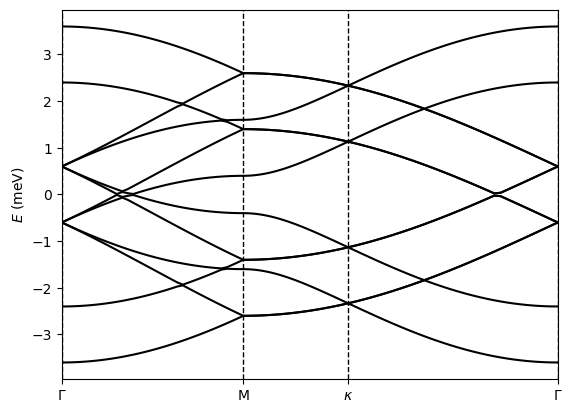

In [338]:
params0.plot_dispersion()

In [184]:
z=params.sigma[0][:,np.newaxis,np.newaxis,:]*params.sigma[0][np.newaxis,:,:,np.newaxis]

In [185]:
z.shape

(2, 2, 2, 2)

In [196]:
d_A=np.array([0,1])

In [197]:
z2=d_A[np.newaxis,np.newaxis,np.newaxis,:]*z

In [198]:
zz=np.zeros((2,2,2,2))
for a1_idx in range(2):
    for a2_idx in range(2):
        for a3_idx in range(2):
            for a4_idx in range(2):
                zz[a1_idx,a2_idx,a3_idx,a4_idx]=(a1_idx==a4_idx)*(a3_idx==a2_idx)*(a4_idx==1)

In [199]:
z2==zz

array([[[[ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True]]],


       [[[ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True]]]])

In [145]:
np.arange(8).reshape((2,2,2))

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

In [147]:
np.arange(8).reshape((2,2,2))+z[np.newaxis,:,:]

array([[[ 1,  3],
        [ 5,  7]],

       [[ 5,  7],
        [ 9, 11]]])

In [139]:
params.neighbor_list[2]

array([[-5.00000000e-01, -8.66025404e-01],
       [ 5.00000000e-01, -8.66025404e-01],
       [ 1.00000000e+00,  1.11022302e-16],
       [ 5.00000000e-01,  8.66025404e-01],
       [-5.00000000e-01,  8.66025404e-01],
       [-1.00000000e+00, -1.11022302e-16]])

In [12]:
params.aM[1]

array([ 0.5      , -0.8660254])

In [19]:
params.am_index

array([[ 1,  1],
       [ 2, -1]])

In [31]:
params.bM/(4*np.pi/np.sqrt(3))

array([[ 8.66025404e-01, -5.00000000e-01],
       [ 6.12323400e-17,  1.00000000e+00]])

In [32]:
params.bm/(4*np.pi/np.sqrt(3)/np.sqrt(3))

array([[-0.5      , -0.8660254],
       [-0.5      ,  0.8660254]])

In [33]:
params.bm_index

array([[-0.33333333, -0.66666667],
       [-0.33333333,  0.33333333]])

In [35]:
params.high_symm['kappa']/(4*np.pi/np.sqrt(3)/np.sqrt(3)/np.sqrt(3))

array([-0.8660254,  0.5      ])

In [43]:
np.angle(params.high_symm['M']@np.array([1,1j]))/np.pi*180

120.0

In [46]:
params.neighbor_list[1][0]

array([-0., -0.])

In [174]:
# zz=params.exp[:,:,np.newaxis,np.newaxis,:]*params.delta[np.newaxis,:,:,:,:]
zz=params.exp[:,np.newaxis,:,:,np.newaxis].conj()*params.delta[np.newaxis,:,:,:,:]

In [179]:
test=np.zeros((3,3,3,3,3),dtype=complex)
for n_idx in range(3):
    for q1_idx in range(3):
        for q2_idx in range(3):
            for q3_idx in range(3):
                for q4_idx in range(3):
                    # test[n_idx,q1_idx,q2_idx,q3_idx,q4_idx]=params.delta[q1_idx,q2_idx,q3_idx,q4_idx]* params.exp[n_idx,q1_idx,q4_idx]
                    test[n_idx,q1_idx,q2_idx,q3_idx,q4_idx]=params.delta[q1_idx,q2_idx,q3_idx,q4_idx]* params.exp[n_idx,q2_idx,q3_idx].conj()



In [180]:
np.abs(zz-test).max()

0.0

In [168]:
list(zip(*np.where(zz==1)))

[(0, 0, 0, 0, 0),
 (0, 0, 0, 1, 1),
 (0, 0, 0, 2, 2),
 (0, 0, 1, 0, 2),
 (0, 0, 1, 1, 0),
 (0, 0, 1, 2, 1),
 (0, 0, 2, 0, 1),
 (0, 0, 2, 1, 2),
 (0, 0, 2, 2, 0),
 (0, 1, 0, 0, 1),
 (0, 1, 0, 1, 2),
 (0, 1, 0, 2, 0),
 (0, 1, 1, 0, 0),
 (0, 1, 1, 1, 1),
 (0, 1, 1, 2, 2),
 (0, 1, 2, 0, 2),
 (0, 1, 2, 1, 0),
 (0, 1, 2, 2, 1),
 (0, 2, 0, 0, 2),
 (0, 2, 0, 1, 0),
 (0, 2, 0, 2, 1),
 (0, 2, 1, 0, 1),
 (0, 2, 1, 1, 2),
 (0, 2, 1, 2, 0),
 (0, 2, 2, 0, 0),
 (0, 2, 2, 1, 1),
 (0, 2, 2, 2, 2),
 (1, 0, 0, 0, 0),
 (1, 0, 1, 1, 0),
 (1, 0, 2, 2, 0),
 (1, 1, 0, 0, 1),
 (1, 1, 1, 1, 1),
 (1, 1, 2, 2, 1),
 (1, 2, 0, 0, 2),
 (1, 2, 1, 1, 2),
 (1, 2, 2, 2, 2),
 (2, 0, 0, 0, 0),
 (2, 0, 1, 1, 0),
 (2, 0, 2, 2, 0),
 (2, 1, 0, 0, 1),
 (2, 1, 1, 1, 1),
 (2, 1, 2, 2, 1),
 (2, 2, 0, 0, 2),
 (2, 2, 1, 1, 2),
 (2, 2, 2, 2, 2)]

In [165]:
list(zip(*np.where(params.exp==1)))

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 1, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 1, 1),
 (2, 2, 2)]

In [166]:
list(zip(*np.where(params.delta==1)))

[(0, 0, 0, 0),
 (0, 0, 1, 1),
 (0, 0, 2, 2),
 (0, 1, 0, 2),
 (0, 1, 1, 0),
 (0, 1, 2, 1),
 (0, 2, 0, 1),
 (0, 2, 1, 2),
 (0, 2, 2, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 2),
 (1, 0, 2, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 1),
 (1, 1, 2, 2),
 (1, 2, 0, 2),
 (1, 2, 1, 0),
 (1, 2, 2, 1),
 (2, 0, 0, 2),
 (2, 0, 1, 0),
 (2, 0, 2, 1),
 (2, 1, 0, 1),
 (2, 1, 1, 2),
 (2, 1, 2, 0),
 (2, 2, 0, 0),
 (2, 2, 1, 1),
 (2, 2, 2, 2)]

In [164]:
params.exp

array([[[ 1. +0.j       ,  1. -0.j       ,  1. -0.j       ],
        [ 1. -0.j       ,  1. +0.j       ,  1. -0.j       ],
        [ 1. -0.j       ,  1. -0.j       ,  1. +0.j       ]],

       [[ 1. +0.j       , -0.5-0.8660254j, -0.5+0.8660254j],
        [-0.5+0.8660254j,  1. +0.j       , -0.5-0.8660254j],
        [-0.5-0.8660254j, -0.5+0.8660254j,  1. +0.j       ]],

       [[ 1. -0.j       , -0.5+0.8660254j, -0.5-0.8660254j],
        [-0.5-0.8660254j,  1. -0.j       , -0.5+0.8660254j],
        [-0.5+0.8660254j, -0.5-0.8660254j,  1. -0.j       ]]])

In [143]:
np.tile(z[np.newaxis,:,:],[5,1,1])

array([[[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]]])

# Order parameter check

In [38]:
# params=Params(t=[0,-1,0],U=[3,0],h=.1,nu=[18,9],n=33)
params=Params(t=[0,-1,0],U=[1,0],h=.1,nu=[4,2],n=33)
# ave=params._ansatz_from_order_parameter(params.O_max,params.l)

Energy resolution: 0.05771592768872468


In [58]:
# ave=params._ansatz_from_order_parameter(np.array([[160,0],[0,-160]]),l=np.zeros((2,2)))
# ave=params._ansatz_from_order_parameter(np.array([[0,160],[160,0]]),l=np.zeros((2,2)))
# ave=params._ansatz_from_order_parameter(np.array([[160,0],[0,-160]]),l=np.array([[1,0],[0,1]]))
ave=params._ansatz_from_order_parameter(np.array([[0,160],[-160,0]]),l=np.array([[0,1],[-1,0]]))

In [32]:
ave.max()

(73.93502386788067+4.188817536220097e-14j)

In [59]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1 -0.0000+0.0000j -0.0005+0.0000j  0.0044+0.0000j  0.0000+0.0000j   
A2 -0.0005+0.0000j  0.0000+0.0000j -0.0006+0.0000j  0.0000+0.0000j   
A3  0.0044-0.0000j -0.0006+0.0000j  0.0000-0.0000j  0.0000+0.0000j   
B1  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.5440+0.0000j   
B2  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.2709+0.0000j   
B3  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.2676-0.0000j   

                B2              B3  
A1  0.0000+0.0000j  0.0000+0.0000j  
A2  0.0000+0.0000j  0.0000+0.0000j  
A3  0.0000+0.0000j  0.0000+0.0000j  
B1  0.2709+0.0000j  0.2676-0.0000j  
B2  0.2720+0.0000j -0.5418+0.0000j  
B3 -0.5418+0.0000j  0.2720-0.0000j

In [60]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.0000+0.0000j   
A2  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j   
A3  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.0000-0.0594j   
B1 -0.0000+0.0000j  0.0000-0.0000j -0.0000+0.0594j  0.0000+0.0000j   
B2  0.0000+0.0000j -0.0000+0.0000j  0.0000-0.0299j  0.0000+0.0000j   
B3 -0.0000-0.0594j  0.0000+0.0299j  0.0000-0.0000j  0.0000+0.0000j   

                B2              B3  
A1  0.0000-0.0000j -0.0000+0.0594j  
A2 -0.0000+0.0000j  0.0000-0.0299j  
A3  0.0000+0.0299j  0.0000-0.0000j  
B1  0.0000+0.0000j  0.0000+0.0000j  
B2  0.0000+0.0000j  0.0000+0.0000j  
B3  0.0000+0.0000j  0.0000+0.0000j

In [70]:
unitvector= lambda theta: np.array([np.cos(np.deg2rad(theta)),np.sin(np.deg2rad(theta))])

In [55]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1 -0.0000+0.0000j  0.0000-0.0007j  0.0000-0.0013j  0.0425+0.0000j   
A2  0.0000+0.0007j -0.0000+0.0000j  0.0000-0.0007j -0.0213-0.0000j   
A3  0.0000+0.0013j  0.0000+0.0007j -0.0000+0.0000j -0.0211-0.0000j   
B1  0.0425+0.0000j -0.0213+0.0000j -0.0211+0.0000j  0.0000+0.0000j   
B2 -0.0212-0.0000j  0.0425+0.0000j -0.0213+0.0000j -0.0000-0.0007j   
B3 -0.0212+0.0000j -0.0212-0.0000j  0.0425+0.0000j -0.0000-0.0013j   

                B2              B3  
A1 -0.0212+0.0000j -0.0212-0.0000j  
A2  0.0425+0.0000j -0.0212+0.0000j  
A3 -0.0213+0.0000j  0.0425-0.0000j  
B1 -0.0000+0.0007j -0.0000+0.0013j  
B2  0.0000+0.0000j -0.0000+0.0007j  
B3 -0.0000-0.0007j  0.0000+0.0000j

In [56]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1 -0.0000+0.0000j  0.0000+0.0011j  0.0000+0.0023j  0.0000+0.0000j   
A2  0.0000-0.0011j -0.0000+0.0000j  0.0000+0.0011j  0.0368-0.0000j   
A3  0.0000-0.0023j -0.0000-0.0011j -0.0000+0.0000j -0.0367-0.0000j   
B1  0.0000+0.0000j  0.0368+0.0000j -0.0367+0.0000j  0.0000+0.0000j   
B2 -0.0368+0.0000j  0.0000+0.0000j  0.0368+0.0000j -0.0000+0.0011j   
B3  0.0368-0.0000j -0.0368+0.0000j  0.0000+0.0000j -0.0000+0.0023j   

                B2              B3  
A1 -0.0368-0.0000j  0.0368+0.0000j  
A2  0.0000+0.0000j -0.0368-0.0000j  
A3  0.0368+0.0000j  0.0000-0.0000j  
B1 -0.0000-0.0011j -0.0000-0.0023j  
B2  0.0000+0.0000j -0.0000-0.0011j  
B3  0.0000+0.0011j  0.0000+0.0000j

In [267]:
spin_mat=params._generate_spin_mat(ave,unitvector(60))
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1  0.0368+0.0000j  0.0000-0.0000j -0.0368-0.0000j -0.0000-0.0011j   
A2  0.0001+0.0000j -0.0368+0.0000j  0.0368-0.0000j -0.0000+0.0045j   
A3 -0.0367+0.0000j  0.0367-0.0000j  0.0000-0.0000j  0.0000-0.0034j   
B1 -0.0000-0.0011j -0.0000-0.0000j  0.0000+0.0011j  0.0368+0.0000j   
B2 -0.0000+0.0045j  0.0000-0.0011j -0.0000+0.0000j -0.0001-0.0000j   
B3  0.0000-0.0034j  0.0000-0.0023j  0.0000+0.0023j -0.0365-0.0000j   

                B2              B3  
A1 -0.0000-0.0000j  0.0000+0.0011j  
A2  0.0000-0.0011j -0.0000+0.0000j  
A3  0.0000-0.0023j  0.0000+0.0023j  
B1  0.0000+0.0000j -0.0368+0.0000j  
B2 -0.0368-0.0000j  0.0368-0.0000j  
B3  0.0368-0.0000j -0.0000-0.0000j

In [256]:
spin_mat=params._generate_spin_mat(ave,unitvector(60))
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1  0.0000+0.0007j -0.0000-0.0000j  0.0000-0.0007j -0.0213-0.0000j   
A2  0.0000+0.0013j  0.0000+0.0007j -0.0000-0.0000j -0.0211-0.0000j   
A3 -0.0000-0.0039j  0.0000+0.0013j  0.0000+0.0007j  0.0421+0.0000j   
B1 -0.0212+0.0000j  0.0425-0.0000j -0.0213+0.0000j -0.0000-0.0007j   
B2 -0.0212+0.0000j -0.0212+0.0000j  0.0425-0.0000j -0.0000-0.0013j   
B3  0.0421+0.0000j -0.0212+0.0000j -0.0212+0.0000j  0.0000+0.0039j   

                B2              B3  
A1  0.0425-0.0000j -0.0212+0.0000j  
A2 -0.0213-0.0000j  0.0425-0.0000j  
A3 -0.0211+0.0000j -0.0213+0.0000j  
B1  0.0000+0.0000j -0.0000+0.0007j  
B2 -0.0000-0.0007j  0.0000+0.0000j  
B3 -0.0000-0.0013j -0.0000-0.0007j

In [257]:
spin_mat=params._generate_spin_mat(ave,unitvector(120))
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1  0.0000-0.0007j  0.0000-0.0013j -0.0000+0.0039j -0.0213+0.0000j   
A2 -0.0000-0.0000j  0.0000-0.0007j  0.0000-0.0013j  0.0423-0.0000j   
A3  0.0000+0.0007j -0.0000-0.0000j  0.0000-0.0007j -0.0211-0.0000j   
B1 -0.0212+0.0000j -0.0213+0.0000j  0.0424-0.0000j -0.0000+0.0007j   
B2  0.0423-0.0000j -0.0212+0.0000j -0.0213+0.0000j  0.0000+0.0000j   
B3 -0.0210-0.0000j  0.0423-0.0000j -0.0212+0.0000j -0.0000-0.0007j   

                B2              B3  
A1 -0.0213-0.0000j  0.0424-0.0000j  
A2 -0.0213+0.0000j -0.0213-0.0000j  
A3  0.0423-0.0000j -0.0213+0.0000j  
B1 -0.0000+0.0013j  0.0000-0.0039j  
B2 -0.0000+0.0007j -0.0000+0.0013j  
B3  0.0000+0.0000j -0.0000+0.0007j

In [258]:
spin_mat=params._generate_spin_mat(ave,unitvector(120))
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1 -0.0000+0.0011j -0.0000-0.0000j  0.0000+0.0023j  0.0368+0.0000j   
A2  0.0000-0.0045j -0.0000+0.0011j -0.0000-0.0000j  0.0000+0.0000j   
A3  0.0000+0.0034j -0.0000-0.0045j  0.0000+0.0011j -0.0367+0.0000j   
B1 -0.0368-0.0000j  0.0368+0.0000j  0.0001-0.0000j  0.0000-0.0011j   
B2 -0.0000-0.0000j -0.0368-0.0000j  0.0368+0.0000j -0.0000+0.0045j   
B3  0.0367+0.0000j -0.0000+0.0000j -0.0368+0.0000j -0.0000-0.0034j   

                B2              B3  
A1 -0.0368-0.0000j  0.0001-0.0000j  
A2  0.0368+0.0000j -0.0368-0.0000j  
A3  0.0000-0.0000j  0.0368+0.0000j  
B1  0.0000+0.0000j -0.0000-0.0023j  
B2  0.0000-0.0011j  0.0000+0.0000j  
B3  0.0000+0.0045j -0.0000-0.0011j

In [215]:
spin_mat=params._generate_spin_mat(ave,unitvector(180))
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.0425-0.0000j   
A2  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0850-0.0000j   
A3  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.0424-0.0000j   
B1 -0.0425-0.0000j  0.0848-0.0000j -0.0422+0.0000j  0.0000+0.0000j   
B2  0.0850-0.0000j -0.0425+0.0000j -0.0424-0.0000j  0.0000+0.0000j   
B3 -0.0424-0.0000j -0.0425+0.0000j  0.0850+0.0000j  0.0000+0.0000j   

                B2              B3  
A1  0.0848-0.0000j -0.0422+0.0000j  
A2 -0.0425+0.0000j -0.0424-0.0000j  
A3 -0.0425+0.0000j  0.0850+0.0000j  
B1  0.0000+0.0000j  0.0000+0.0000j  
B2  0.0000+0.0000j  0.0000+0.0000j  
B3  0.0000+0.0000j  0.0000+0.0000j

In [216]:
spin_mat=params._generate_spin_mat(ave,unitvector(240))
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.0425+0.0000j   
A2  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.0425-0.0000j   
A3  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0850-0.0000j   
B1 -0.0425+0.0000j -0.0424-0.0000j  0.0843-0.0000j  0.0000+0.0000j   
B2 -0.0425-0.0000j  0.0850+0.0000j -0.0424-0.0000j  0.0000+0.0000j   
B3  0.0850-0.0000j -0.0425+0.0000j -0.0425-0.0000j  0.0000+0.0000j   

                B2              B3  
A1 -0.0424-0.0000j  0.0843-0.0000j  
A2  0.0850+0.0000j -0.0424-0.0000j  
A3 -0.0425+0.0000j -0.0425-0.0000j  
B1  0.0000+0.0000j  0.0000+0.0000j  
B2  0.0000+0.0000j  0.0000+0.0000j  
B3  0.0000+0.0000j  0.0000+0.0000j

In [217]:
spin_mat=params._generate_spin_mat(ave,unitvector(300))
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.0425+0.0000j   
A2  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0850-0.0000j   
A3  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.0424+0.0000j   
B1 -0.0425+0.0000j  0.0848-0.0000j -0.0422-0.0000j  0.0000+0.0000j   
B2  0.0850-0.0000j -0.0425+0.0000j -0.0424+0.0000j  0.0000+0.0000j   
B3 -0.0424+0.0000j -0.0425-0.0000j  0.0850-0.0000j  0.0000+0.0000j   

                B2              B3  
A1  0.0848-0.0000j -0.0422-0.0000j  
A2 -0.0425+0.0000j -0.0424+0.0000j  
A3 -0.0425-0.0000j  0.0850-0.0000j  
B1  0.0000+0.0000j  0.0000+0.0000j  
B2  0.0000+0.0000j  0.0000+0.0000j  
B3  0.0000+0.0000j  0.0000+0.0000j

In [218]:
-0.3842*np.sin(np.deg2rad(120))

-0.33272696013398134

In [219]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),3),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1            A2            A3            B1            B2  \
A1  0.000-0.000j  0.000+0.005j -0.000-0.002j  0.000+0.000j  0.000+0.000j   
A2  0.000+0.000j -0.000-0.002j  0.000-0.002j  0.000+0.000j  0.000+0.000j   
A3 -0.000-0.002j  0.000+0.002j  0.000+0.002j  0.000+0.000j  0.000+0.000j   
B1  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.002j  0.000-0.005j   
B2  0.000+0.000j  0.000+0.000j  0.000+0.000j -0.000+0.000j -0.000-0.000j   
B3  0.000+0.000j  0.000+0.000j  0.000+0.000j -0.000-0.005j  0.000+0.002j   

              B3  
A1  0.000+0.000j  
A2  0.000+0.000j  
A3  0.000+0.000j  
B1 -0.000+0.005j  
B2  0.000+0.002j  
B3 -0.000-0.002j

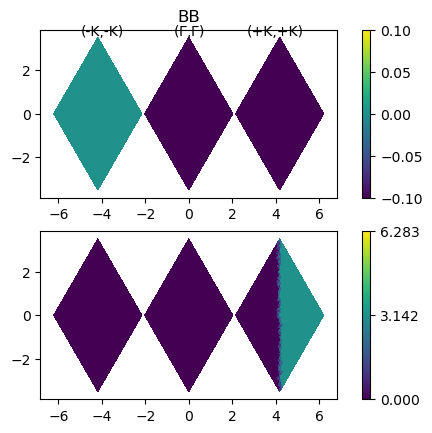

In [88]:
fig,axs=plt.subplots(2,1)

s1,s2=0,1
a1,a2=1,1
di=0

vmin,vmax=np.min([np.abs(ave[:,i,s1,a1,(i+di)%3,s2,a2]) for i in range(3)]),np.max([np.abs(ave[:,i,s1,a1,(i+di)%3,s2,a2]) for i in range(3)])
for i in range(3):
    im0=axs[0].tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,(i+di)%3,s1,a1,i,s2,a2]),vmin=vmin,vmax=vmax)

    im1=axs[1].tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,(i+di)%3,s1,a1,i,s2,a2])% (2*np.pi),vmin=0,vmax=2*np.pi)

cbar0 = fig.colorbar(im0, ax=axs[0])
cbar1 = fig.colorbar(im1, ax=axs[1],ticks=[0,np.pi,np.pi*2])
    
[ax.set_aspect('equal') for ax in axs]

axs[0].set_title(f'{sublattice(a1)}{sublattice(a2)}')
for i,x in zip(range(-1,2),[-4,0,4]):
    axs[0].text(x,3.8,f'({valley((i+di)%3)},{valley((i%3))})',ha='center',va='center')

# [ax.set_ylim([-0.8,0.8]) for ax in axs]
# [ax.set_xlim([-5,-3.6]) for ax in axs]

# Real space check

## A: d, B: d

In [297]:
params=Params(t=[0,0,0.],U=[.21,0],h=0.1,nu=[-2,-1],n=15)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

S0: 1.0000 1.0000
S1: 0.0000 0.0000
S2: 0.0000 0.0000
S3: -1.0000 -1.0000
Iteration 0:	
Gap(meV)=0.41000000000000003
E(meV):-0.19999999999999984
S0: 1.0000 1.0000
S1: 0.0000 0.0000
S2: 0.0000 0.0000
S3: -1.0000 -1.0000
Iteration 1:	
Gap(meV)=0.41000000000000003
E(meV):-0.19999999999999984
S0: 1.0000 1.0000
S1: 0.0000 0.0000
S2: 0.0000 0.0000
S3: -1.0000 -1.0000


In [275]:
# Energy
3*params.U[1]-2*params.h

-0.2

In [276]:
# Gap
params.U[0]+2*params.h 

0.41000000000000003

## A: ud, B:0

In [268]:
params=Params(t=[0,0,0.],U=[.2,0.01],h=0.1,nu=[-4,-2],n=15)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

S0: 2.000 0.000
S1: 0.000 0.000
S2: 0.000 0.000
S3: 0.000 0.000
Iteration 0:	
Gap(meV)=0.06
E(meV):-0.16999999999999985
S0: 1.000 1.000
S1: 0.000 0.000
S2: 0.000 0.000
S3: -1.000 -1.000
Iteration 1:	
Gap(meV)=0.4
E(meV):-0.16999999999999985
S0: 1.000 1.000
S1: 0.000 0.000
S2: 0.000 0.000
S3: -1.000 -1.000


In [269]:
# Energy
params.U[0]

0.2

In [272]:
# Gap
np.diff(np.sort(np.array([-params.h+params.U[1]*6,-params.h+params.U[0],params.h+params.U[1]*6,params.h+params.U[0]]))[[1,2]])
# np.array([params.h+params.U[0],params.h+params.U[1]*6,-params.h+params.U[0],-params.h+params.U[1]*6,])

array([0.06])

In [271]:
6*params.U[1]-params.U[0]-2*params.h

-0.34

In [80]:
# params=Params(t=[0,1,0.],U=[1,.8],h=0.1,nu=[-2,-1],n=15)


S0: 1.000 1.000
S1: 1.000 -1.000
S2: 0.000 0.000
S3: 0.000 0.000
Iteration 0:	
Gap(meV)=0.21980390271855477
E(meV):2.3607767729723603
S0: 1.000 1.000
S1: 0.981 -0.981
S2: 0.000 0.000
S3: 0.000 0.000
Iteration 1:	
Gap(meV)=0.25756628825585715
E(meV):2.325089114595086
S0: 1.000 1.000
S1: 0.927 -0.927
S2: -0.000 -0.000
S3: 0.000 0.000
Iteration 2:	
Gap(meV)=0.29078951718919077
E(meV):2.294653474759248
S0: 1.000 1.000
S1: 0.850 -0.850
S2: 0.000 0.000
S3: 0.000 0.000
Iteration 3:	
Gap(meV)=0.3183438873984592
E(meV):2.27003413987547
S0: 1.000 1.000
S1: 0.760 -0.760
S2: -0.000 -0.000
S3: 0.000 0.000
Iteration 4:	
Gap(meV)=0.3401454820543921
E(meV):2.250926164423974
S0: 1.000 1.000
S1: 0.667 -0.667
S2: 0.000 0.000
S3: 0.000 0.000
Iteration 5:	
Gap(meV)=0.35678332938889445
E(meV):2.2365520743837886
S0: 1.000 1.000
S1: 0.576 -0.576
S2: -0.000 -0.000
S3: 0.000 0.000
Iteration 6:	
Gap(meV)=0.3691432124562106
E(meV):2.225985453750532
S0: 1.000 1.000
S1: 0.493 -0.493
S2: 0.000 0.000
S3: 0.000 0.000


# Iteration

In [56]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-7)

S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 1.000 1.000 1.000 -1.000 -1.000 -1.000
S2: 0.000 0.000 0.000 0.000 0.000 0.000
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=1.0000145262158604
E(meV):-2.5583070398935255
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.370 0.370 0.370 -0.370 -0.370 -0.370
S2: -0.000 0.000 -0.000 -0.000 -0.000 -0.000
S3: -0.053 -0.053 -0.053 -0.053 -0.053 -0.053
Iteration 1:	
Gap(meV)=0.3716980695844764
E(meV):-2.6376566112101654
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.169 0.169 0.169 -0.169 -0.169 -0.169
S2: -0.000 0.000 0.000 0.000 -0.000 -0.000
S3: -0.032 -0.032 -0.032 -0.032 -0.032 -0.032
Iteration 2:	
Gap(meV)=0.16983803053615582
E(meV):-2.6494931576796072
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.086 0.086 0.086 -0.086 -0.086 -0.086
S2: 0.000 -0.000 -0.000 -0.000 -0.000 -0.000
S3: -0.022 -0.022 -0.022 -0.022 -0.022 -0.022
Iteration 3:	
Gap(meV)=0.08588944520208547
E(meV):-2.6518704888511713
S0: 1.000 1.000 1.000 1.000 1.000 1.000

(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

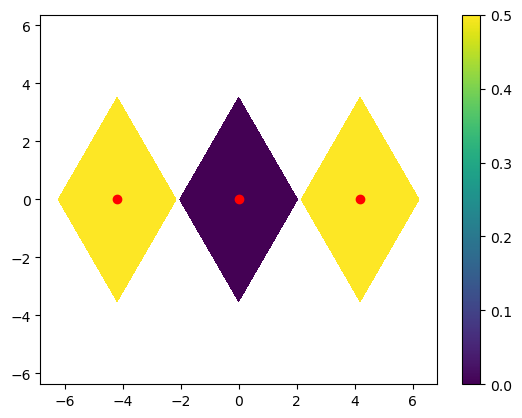

In [96]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+0)%3,s1,a1,i,s2,a2].real,vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

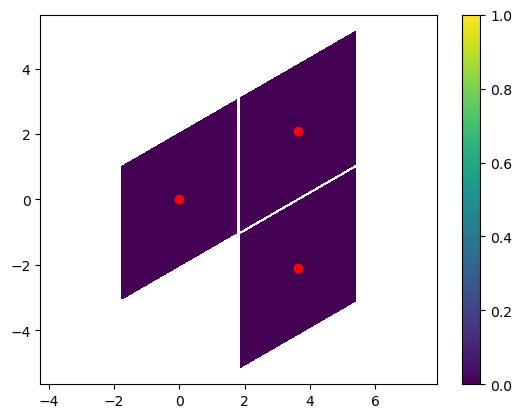

In [246]:
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,i,0,0,(i+1)%3,0,0].real,vmin=0,vmax=.1)
plt.scatter(*params.q.T,color='r')
plt.axis('equal')
plt.colorbar()

In [38]:
params.bm

array([[-3.62759873e+00, -2.09439510e+00],
       [ 8.09056761e-17,  4.18879020e+00]])

(-3.99035860131528, 9.83264907447981, -6.911503837897545, 6.911503837897545)

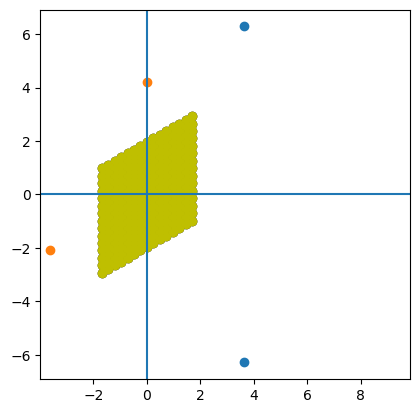

In [52]:
plt.scatter(*params.bM.T)
plt.scatter(*params.bm.T)
plt.scatter(*params.k.T,color='k')
plt.scatter(*shift_to_FBZ(params.k,params.bm).T,color='y')
plt.axvline(x=0)
plt.axhline(y=0)

plt.axis('square')

Text(0, 0.5, '$S_{x,y,z}$')

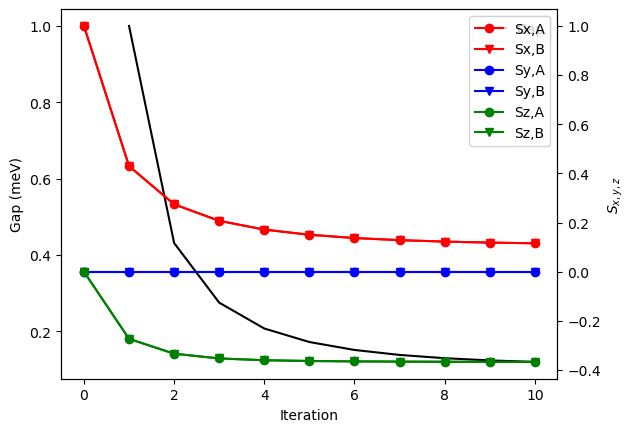

In [319]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k',label='Gap')
ax.legend()
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

Text(0, 0.5, 'Energy')

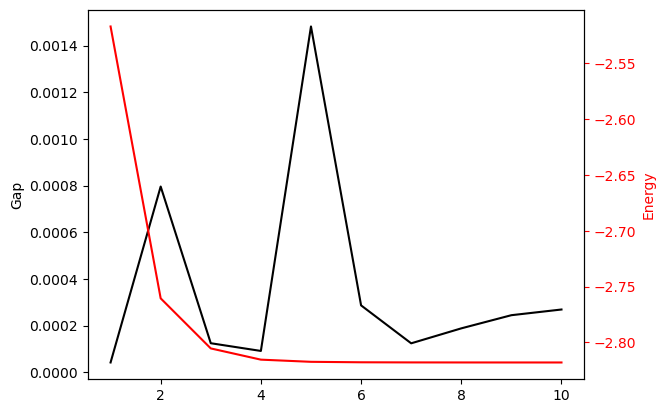

In [328]:
fig,ax=plt.subplots()
ax.plot(gap_list,color='k',label='Gap')
ax.set_ylabel('Gap')
ax2=ax.twinx()
ax2.plot(energy_list,color='r',label='Energy')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel('Energy',color='red')

In [ ]:
gap_list,energy_list,spin_list=params.iteration(print_opt='o')

S0: 2.00 0.00
S1: 0.00 0.00
S2: 0.00 0.00
S3: 0.00 0.00
Iteration 0:	
Gap(meV)=3.6
E(meV):-0.6504228526971246
S0: 1.77 0.23
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 1:	
Gap(meV)=2.74241447226947
E(meV):-0.7660270358587831
S0: 1.70 0.30
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 2:	
Gap(meV)=2.460222336731322
E(meV):-0.8009410281787968
S0: 1.67 0.33
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 3:	
Gap(meV)=2.3404688142077603
E(meV):-0.8149403816433257
S0: 1.65 0.35
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 4:	
Gap(meV)=2.2845957435345206
E(meV):-0.8212735835070377
S0: 1.65 0.35
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 5:	
Gap(meV)=2.257403775652284
E(meV):-0.8243066305484883
S0: 1.64 0.36
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 6:	
Gap(meV)=2.243901305085436
E(meV):-0.825800350069615
S0: 1.64 0.36
S1: 0.00 0.00
S2: 0.00 0.00
S3: -0.00 0.00
Iteration 7:	
Gap(meV)=2.2371298725166073
E(meV):-0.8265463011550556
S0: 1.64 0.36


Text(0, 0.5, '$S_{x,y,z}$')

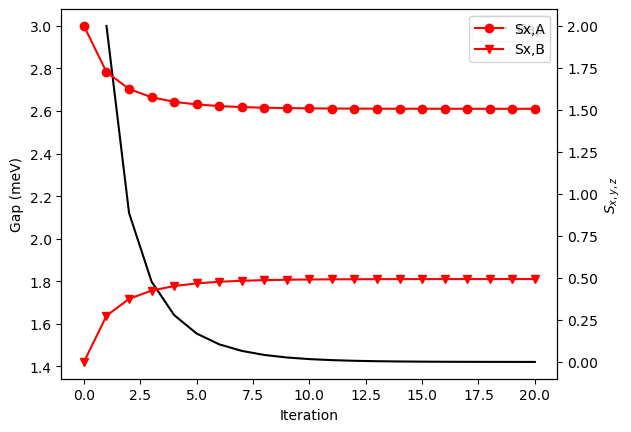

In [90]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k',label='Gap')
ax.legend()
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,0],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,0],"v-",label='Sx,B',color='red')
# ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
# ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
# ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
# ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
# ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
# ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

Text(0, 0.5, 'Energy')

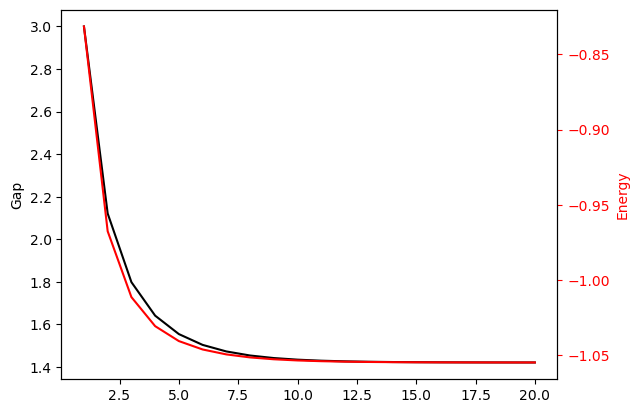

In [91]:
fig,ax=plt.subplots()
ax.plot(gap_list,color='k',label='Gap')
ax.set_ylabel('Gap')
ax2=ax.twinx()
ax2.plot(energy_list,color='r',label='Energy')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel('Energy',color='red')

# p-wave SDW

In [404]:
params=Params(t=[0,-1,-.2],U=[4,0],h=.2,nu=[10,5],n=27)

In [405]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-8)

S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 1.000 -0.500 -0.500 0.000 0.000 0.000
S2: 0.000 0.866 -0.866 0.000 0.000 0.000
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=1.3322676295501878e-15
E(meV):-1.01068874048953
S0: 1.026 1.026 1.026 0.974 0.974 0.974
S1: 0.589 -0.294 -0.294 0.030 0.030 -0.060
S2: 0.000 0.510 -0.510 -0.052 0.052 -0.000
S3: -0.010 -0.010 -0.010 -0.145 -0.145 -0.145
Iteration 1:	
Gap(meV)=0.015998026383684305
E(meV):-1.1269224783906053
S0: 0.983 0.983 0.983 1.017 1.017 1.017
S1: 0.438 -0.219 -0.219 0.048 0.048 -0.096
S2: 0.000 0.379 -0.379 -0.084 0.083 0.000
S3: 0.068 0.068 0.068 -0.244 -0.244 -0.244
Iteration 2:	
Gap(meV)=0.09521405265766747
E(meV):-1.1782947556670422
S0: 1.019 1.019 1.019 0.981 0.981 0.981
S1: 0.375 -0.188 -0.188 0.053 0.054 -0.106
S2: 0.000 0.325 -0.325 -0.092 0.092 0.000
S3: 0.184 0.184 0.184 -0.325 -0.325 -0.325
Iteration 3:	
Gap(meV)=0.46707622827296635
E(meV):-1.2286574939686288
S0: 0.982 0.982 0.982 1.018 1.018 1.018
S1: 0.3

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

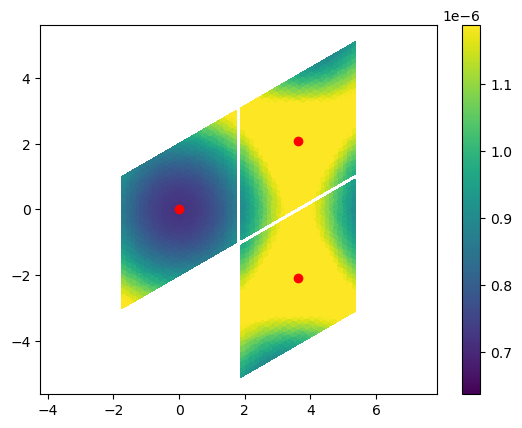

In [449]:
qi=0
s1,s2=0,1
a1,a2=0,0
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.1322219192886696, 5.759820647757106, -5.682792044493537, 5.682792044493537)

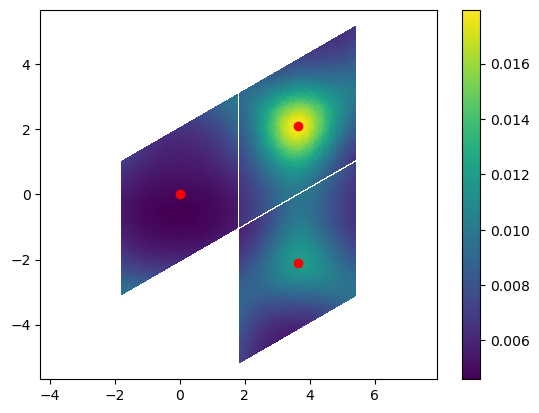

In [403]:
qi=1
s1,s2=0,1
a1,a2=0,0
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

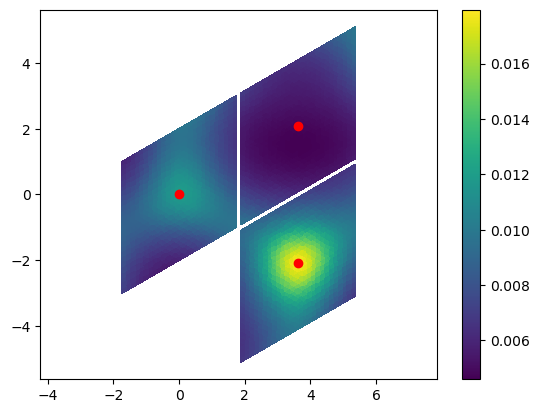

In [400]:
qi=2
s1,s2=1,0
a1,a2=0,0
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [456]:
params=Params(t=[0,-1,-.1],U=[4,0],h=.0,nu=[8,4],n=27)

In [457]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-8)

S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.000 0.000 0.000 1.000 -0.500 -0.500
S2: 0.000 0.000 0.000 0.000 0.866 -0.866
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=8.881784197001252e-16
E(meV):-0.9717745004963225
S0: 0.984 0.984 0.984 1.016 1.016 1.016
S1: 0.031 -0.060 0.030 0.557 -0.278 -0.278
S2: 0.052 -0.000 -0.053 0.000 0.482 -0.482
S3: 0.000 0.000 0.000 -0.000 -0.000 -0.000
Iteration 1:	
Gap(meV)=0.03935187834171128
E(meV):-1.0937099169274975
S0: 1.012 1.012 1.012 0.988 0.988 0.988
S1: 0.051 -0.101 0.051 0.363 -0.182 -0.182
S2: 0.087 -0.000 -0.088 0.000 0.315 -0.315
S3: 0.001 0.000 0.001 -0.000 -0.000 -0.000
Iteration 2:	
Gap(meV)=0.02695532548215107
E(meV):-1.1245555521093438
S0: 0.979 0.979 0.979 1.021 1.021 1.021
S1: 0.057 -0.113 0.057 0.259 -0.130 -0.130
S2: 0.097 -0.000 -0.098 0.000 0.225 -0.224
S3: 0.001 0.001 0.001 -0.001 -0.001 -0.001
Iteration 3:	
Gap(meV)=0.09162689865901985
E(meV):-1.1337583979114574
S0: 1.030 1.031 1.031 0.969 0.969 0.969
S1: 0.05

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

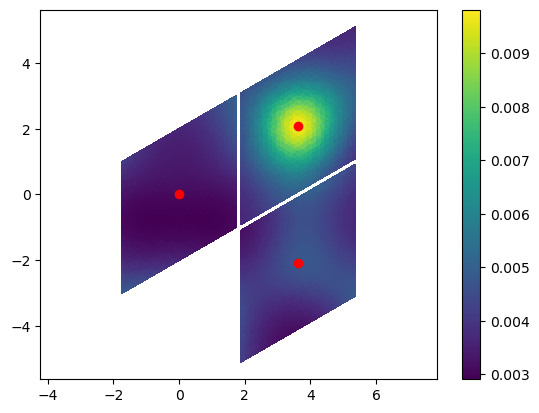

In [455]:
# <c_{q,up,A}^dag c_{q+qi,down,A}> (k), 
# q={Gamma, K, K'}

qi=1
s1,s2=0,1
a1,a2=1,1
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

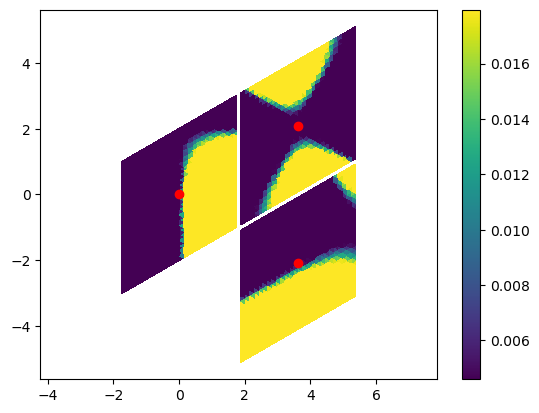

In [445]:
qi=1
s1,s2=0,1
a1,a2=1,1
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

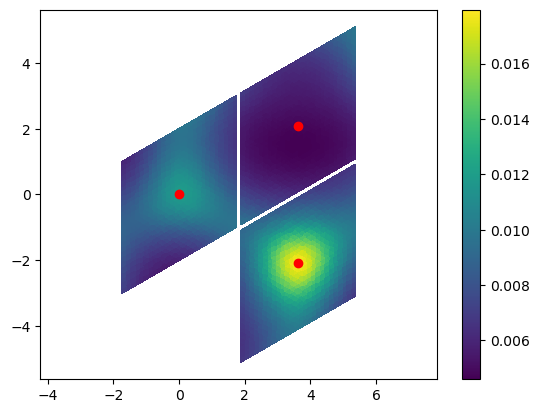

In [446]:
qi=2
s1,s2=1,0
a1,a2=1,1
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

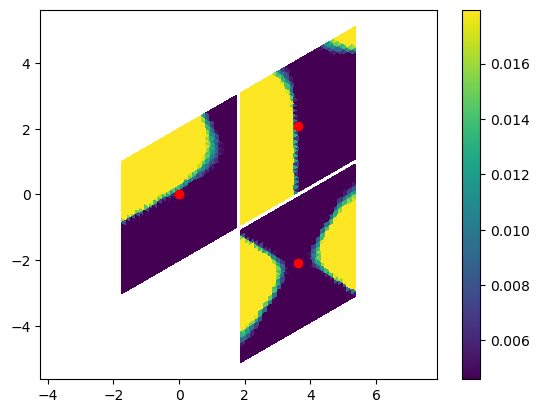

In [447]:
qi=2
s1,s2=1,0
a1,a2=1,1
ave_pts=np.concatenate([ave[:,i,s1,a1,(i+qi)%3,s2,a2] for i in range(3)],axis=0)
vmin,vmax=ave_pts.min().real,ave_pts.max().real

for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,i,s1,a1,(i+qi)%3,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [431]:
spin_list[-1,0,1:-1]@spin_list[-1,1,1:-1]/(np.linalg.norm(spin_list[-1,0,1:-1])**2)

-0.5000085565137826

In [399]:
spin_list[-1,2,1:-1]@spin_list[-1,1,1:-1]/(np.linalg.norm(spin_list[-1,0,1:-1])**2)

-0.4999999688536998

In [326]:
spin_list[-1,0,1:-1]@spin_list[-1,2,1:-1]/(np.linalg.norm(spin_list[-1,0,1:-1])**2)

-0.5000000000000017

In [432]:
spin_list[-1,4,1:-1]@spin_list[-1,3,1:-1]/(np.linalg.norm(spin_list[-1,4,1:-1])*np.linalg.norm(spin_list[-1,3,1:-1]))

-0.499978626760217

In [318]:
np.linalg.norm(spin_list[-1,0,1:-1])

0.8398170647860979

In [319]:
np.linalg.norm(spin_list[-1,1,1:-1])

0.8398170647860973

In [320]:
np.linalg.norm(spin_list[-1,2,1:-1])

0.8398170647860974

In [144]:
params=Params(t=[0,-.4,-.2],U=[2,0],h=.1,nu=[6,3],n=27)

In [145]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-8)

S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: -1.00 0.50 0.50 0.00 0.00 0.00
S2: -0.00 -0.87 0.87 0.00 0.00 0.00
S3: 0.00 0.00 0.00 0.00 0.00 0.00
Iteration 0:	
Gap(meV)=0.0
E(meV):-0.32696763161454384
S0: 1.04 1.04 1.04 0.96 0.96 0.96
S1: -0.76 0.38 0.38 -0.03 -0.03 0.06
S2: -0.00 -0.65 0.65 0.05 -0.05 0.00
S3: -0.05 -0.05 -0.05 -0.13 -0.13 -0.13
Iteration 1:	
Gap(meV)=6.58798332642263e-05
E(meV):-0.37500402029361685
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: -0.67 0.34 0.34 -0.08 -0.07 0.15
S2: 0.00 -0.58 0.58 0.13 -0.13 0.00
S3: -0.07 -0.07 -0.07 -0.30 -0.30 -0.30
Iteration 2:	
Gap(meV)=0.000313483386393143
E(meV):-0.41477887481992165
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: -0.66 0.33 0.33 -0.12 -0.12 0.24
S2: 0.00 -0.57 0.57 0.21 -0.21 0.00
S3: -0.06 -0.06 -0.06 -0.48 -0.48 -0.48
Iteration 3:	
Gap(meV)=5.8427938905980525e-05
E(meV):-0.44331659152630154
S0: 0.98 0.98 0.98 1.02 1.02 1.02
S1: -0.68 0.34 0.34 -0.15 -0.15 0.30
S2: 0.00 -0.59 0.59 0.26 -0.26 0.00
S3: -0.03 -0.03 -0.03 -0.62 -0.62 -0.62

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

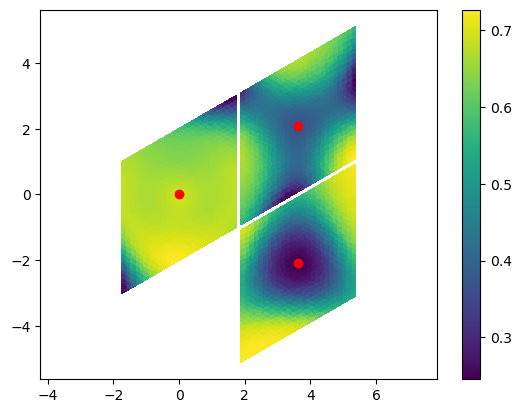

In [147]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,i,0,0,i,0,0].real)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

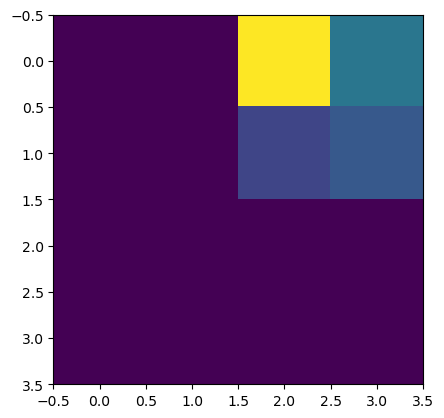

In [152]:
i=2
plt.imshow(np.abs(ave[0,i,:,:,(i+1)%3,:,:].reshape((4,4))))

(-1.921283771003653,
 4.734238443268056,
 -3.3277611071358546,
 3.3277611071358546)

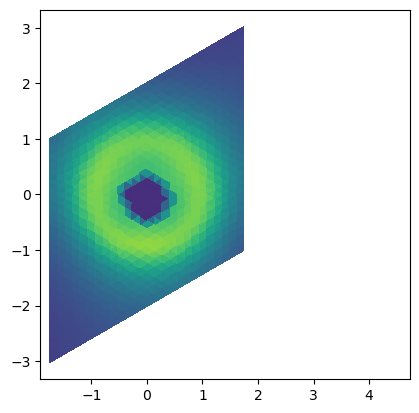

In [143]:
i=0
plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,0,0,(i+1)%3,1,0]),vmin=0,vmax=.4)
plt.axis('square')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

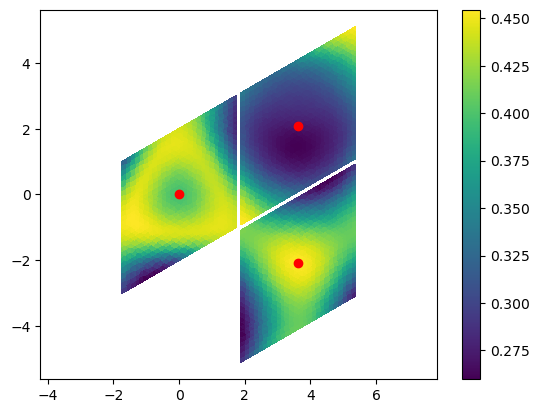

In [155]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[(i+1)%3]).T,np.abs(ave[:,i,0,0,(i+1)%3,1,0]),)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.102663707427075, 5.7302624358955105, -5.631595719768368, 5.631595719768368)

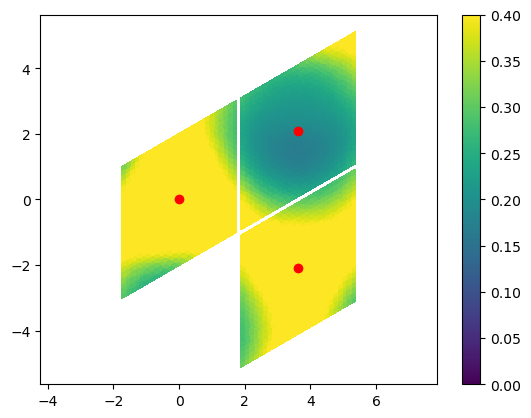

In [153]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,1,0,(i+2)%3,0,0]),vmin=0,vmax=.4)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [ ]:
gap_list,energy_list,spin_list=params.iteration(print_opt='o',thres=1e-8)

S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 1.00 -0.50 -0.50 0.00 0.00 0.00
S2: 0.00 0.87 -0.87 0.00 0.00 0.00
S3: 0.00 0.00 0.00 0.00 0.00 0.00
Iteration 0:	
Gap(meV)=8.881784197001252e-16
E(meV):-0.4310185192876055
S0: 1.02 1.02 1.02 0.98 0.98 0.98
S1: 0.75 -0.38 -0.38 0.04 0.03 -0.07
S2: 0.00 0.65 -0.65 -0.06 0.06 -0.00
S3: -0.05 -0.05 -0.05 -0.40 -0.40 -0.40
Iteration 1:	
Gap(meV)=0.7971310113771284
E(meV):-0.9056862135219325
S0: 0.98 0.98 0.98 1.02 1.02 1.02
S1: 0.80 -0.40 -0.40 0.07 0.06 -0.13
S2: 0.00 0.70 -0.70 -0.11 0.12 -0.00
S3: -0.02 -0.02 -0.02 -0.77 -0.77 -0.77
Iteration 2:	
Gap(meV)=1.7487952730730372
E(meV):-1.0103882236597757
S0: 0.99 0.99 0.99 1.01 1.01 1.01
S1: 0.88 -0.44 -0.44 0.07 0.07 -0.14
S2: 0.00 0.76 -0.76 -0.12 0.13 -0.00
S3: -0.02 -0.02 -0.02 -0.87 -0.87 -0.87
Iteration 3:	
Gap(meV)=2.1935717644722916
E(meV):-1.018629806842282
S0: 0.99 0.99 0.99 1.01 1.01 1.01
S1: 0.90 -0.45 -0.45 0.07 0.07 -0.14
S2: 0.00 0.78 -0.78 -0.12 0.12 -0.00
S3: -0.03 -0.03 -0.03 -0.90 -0.

In [172]:
# params=Params(t=[0,-1,0.],U=[0.1,5],h=0.1,nu=[8,4],n=21)
params=Params(t=[0,-1,0.],U=[1,1],h=0.1,nu=[8,4],n=21)

In [173]:
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-7)

S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 1.00 -0.50 -0.50 -1.00 0.50 0.50
S2: 0.00 0.00 0.00 0.00 0.00 0.00
S3: 0.00 0.00 0.00 0.00 0.00 0.00
Iteration 0:	
Gap(meV)=0.148839311885689
E(meV):0.33982955773995477
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 0.35 -0.16 -0.21 -0.35 0.21 0.16
S2: 0.00 0.00 -0.00 -0.00 -0.00 -0.00
S3: -0.01 -0.02 -0.02 -0.01 -0.02 -0.02
Iteration 1:	
Gap(meV)=0.06443600541275885
E(meV):0.21728178659387343
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 0.12 -0.05 -0.09 -0.12 0.09 0.05
S2: 0.00 0.00 -0.00 -0.00 -0.00 -0.00
S3: -0.01 -0.01 -0.01 -0.01 -0.01 -0.01
Iteration 2:	
Gap(meV)=0.09520438083411387
E(meV):0.20118263629623714
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 0.04 -0.02 -0.04 -0.04 0.04 0.02
S2: 0.00 0.00 0.00 -0.00 -0.00 -0.00
S3: -0.00 -0.00 -0.00 -0.00 -0.00 -0.00
Iteration 3:	
Gap(meV)=0.12842976957227092
E(meV):0.19899594254455177
S0: 1.00 1.00 1.00 1.00 1.00 1.00
S1: 0.01 -0.01 -0.02 -0.01 0.02 0.01
S2: 0.00 0.00 0.00 -0.00 -0.00 -0.00
S3: -0.00 -0.00 -0.00 -0.00 -

(-2.081550698954507, 5.709149427422943, -5.595026916393249, 5.595026916393249)

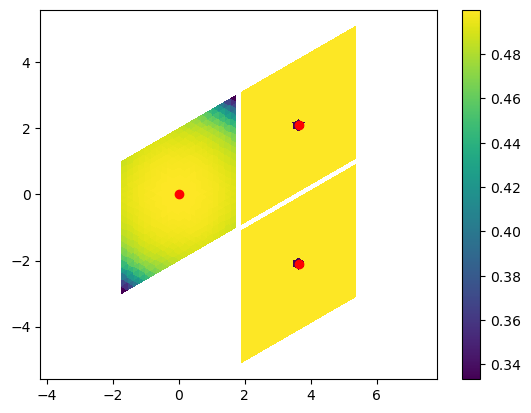

In [174]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,0,0,i,0,0]),)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-2.081550698954507, 5.709149427422943, -5.595026916393249, 5.595026916393249)

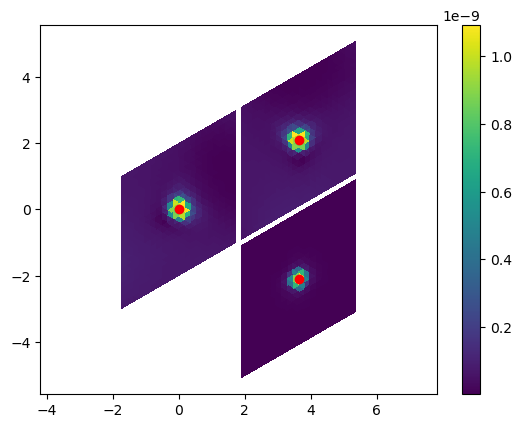

In [175]:
# k_pts=np.concatenate([params.k+params.q[0],params.k+params.q[1],params.k+params.q[2]])
# ave_pts=np.concatenate((ave[:,0,0,0,0,0,0],ave[:,1,0,0,1,0,0],ave[:,2,0,0,2,0,0]),axis=0)
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,i,0,0,(i+2)%3,0,0]),)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

Text(0, 0.5, 'Energy')

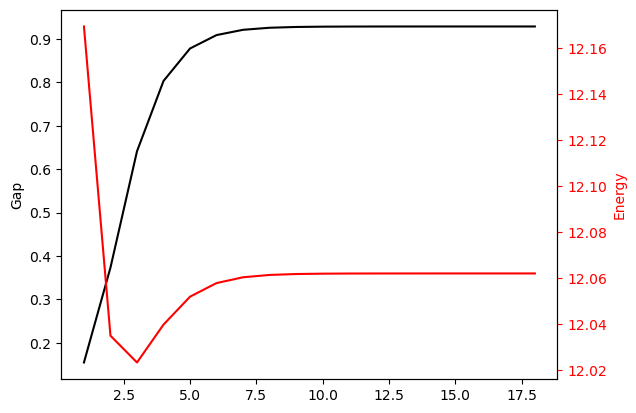

In [113]:
fig,ax=plt.subplots()
ax.plot(gap_list,color='k',label='Gap')
ax.set_ylabel('Gap')
ax2=ax.twinx()
ax2.plot(energy_list,color='r',label='Energy')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel('Energy',color='red')

Text(0, 0.5, '$S_{x,y,z}$')

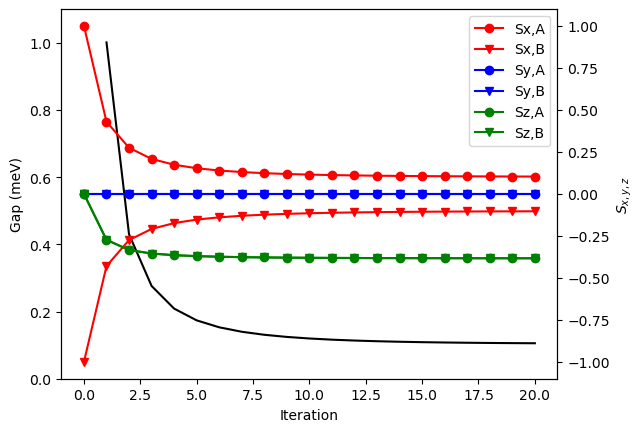

In [514]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k')
ax.set_ylim([0,1.1])
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

Text(0, 0.5, '$S_{x,y,z}$')

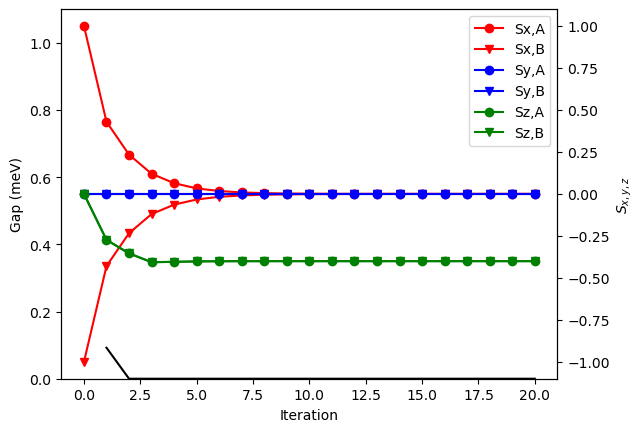

In [524]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k')
ax.set_ylim([0,1.1])
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

Text(0, 0.5, '$S_{x,y,z}$')

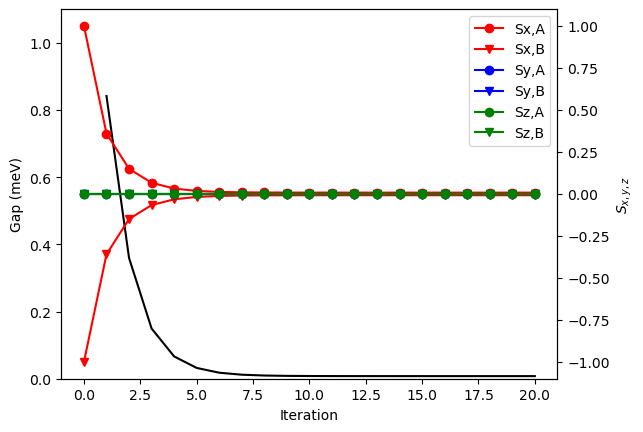

In [521]:
fig,ax=plt.subplots()

ax.plot(gap_list,color='k')
ax.set_ylim([0,1.1])
ax2=ax.twinx()
ax2.plot((spin_list)[:,0,1],"o-",label='Sx,A',color='red')
ax2.plot((spin_list)[:,1,1],"v-",label='Sx,B',color='red')
ax2.plot((spin_list)[:,0,2],"o-",label='Sy,A',color='blue')
ax2.plot((spin_list)[:,1,2],"v-",label='Sy,B',color='blue')
ax2.plot((spin_list)[:,0,3],"o-",label='Sz,A',color='green')
ax2.plot((spin_list)[:,1,3],"v-",label='Sz,B',color='green')
ax2.legend()
ax.set_xlabel('Iteration')
ax.set_ylabel('Gap (meV)')
ax2.set_ylabel('$S_{x,y,z}$')

In [114]:
energyall[:,0].min(),energyall[:,0].max()

(-2.5413812651491097, 0.0)

In [115]:
energyall[:,1].min(),energyall[:,1].max()

(-2.5413812651491092, 5.551115123125783e-17)

In [116]:
energyall[:,2].min(),energyall[:,2].max()

(1.0, 3.5413812651491092)

In [117]:
energyall[:,3].min(),energyall[:,3].max()

(1.0, 3.5413812651491097)

In [18]:
delta=params._generate_delta()

In [19]:
delta.sum()

27

In [72]:
params_bs=Params(t=[0,-1,-0.4],U=[0,0],h=1,nu=[2,1],n=100)
# energy_list=params_bs.plot_dispersion()

In [73]:
zz=params_bs._ansatz_to_momentum()

In [74]:
energyall,wfall=params_bs.energy_MF(zz)

(-4.350455015302128, 12.350455015302128, -6.84238879951857, 6.84238879951857)

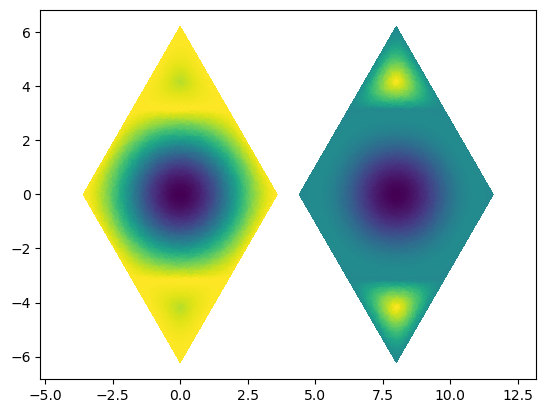

In [76]:
plt.tripcolor(*(params_bs.k).T,energyall[:,1],)
plt.tripcolor(*(params_bs.k+np.array([8,0])).T,energyall[:,2],)

plt.axis('equal')

In [ ]:
gap_list,energy_list,spin_list,ave=params_bs.iteration(print_opt='o',thres=1e-5)

In [ ]:
params_bs.high_symm['G_M_K_G'].shape

(46, 2)

In [ ]:
params_bs.high_symm['G_M_K_G_dist'].shape

(64,)

ValueError: x and y must have same first dimension, but have shapes (46,) and (82, 12)

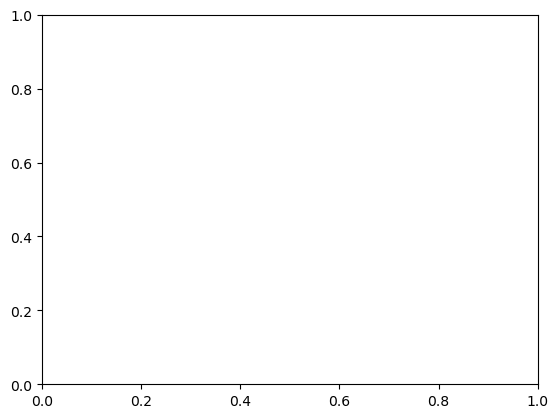

In [ ]:
energy_list.shape

(15,)

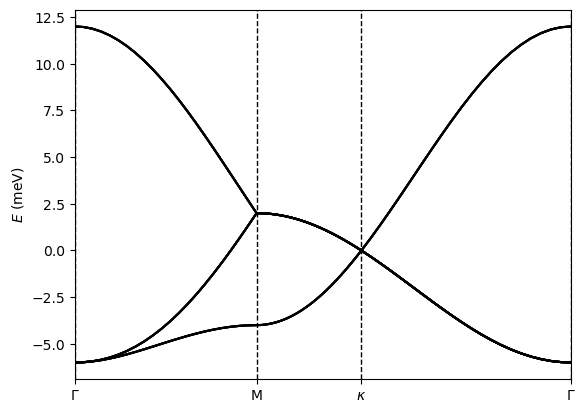

In [ ]:
energy_list=params.plot_dispersion(k=20)

In [ ]:
(energy_list[:,0].max()-energy_list[:,0].min())/(energy_list[:,-1].max()-energy_list[:,-1].min())

1.8571428571428577

In [ ]:
T=params._generate_T(params.k)

In [ ]:
T=params._generate_T(params.high_symm['G_M_K_G'])

In [ ]:
energyall,wfall=params._eig(T)

In [ ]:
energyall.shape

(729, 12)

In [ ]:
np.prod(energyall.shape)

8748

In [ ]:
params.q.shape[0]*params.k.shape[0]*2

4374

In [ ]:
energyall[:,0].min(),energyall[:,0].max()

(-4.0, -1.0000000000000013)

In [ ]:
energyall[:,1].min(),energyall[:,1].max()

(-2.0, -0.022094269184347315)

In [ ]:
energyall[:,2].min(),energyall[:,2].max()

(0.022094269184347315, 2.0)

In [ ]:
energyall[:,3].min(),energyall[:,3].max()

(1.0000000000000013, 4.0)

In [ ]:
energyall[441//2]

array([-3., -3.,  3.,  3.])

In [ ]:
params.k[441//2]

array([0., 0.])

In [ ]:
np.abs((T.transpose((1,0,2))).conj()-T).max()

4.440892098500626e-16

In [ ]:
params.q.shape[0]

3

In [ ]:
for q in params.q:
    print(q)

[0. 0.]
[3.62759873 2.0943951 ]
[ 3.62759873 -2.0943951 ]


In [ ]:
params.neighbor_list

{0: [array([ 0., -0.])],
 1: [array([-0.57735027, -0.        ]),
  array([ 0.28867513, -0.5       ]),
  array([0.28867513, 0.5       ])],
 2: [array([ 0.8660254, -0.5      ]),
  array([0.8660254, 0.5      ]),
  array([0., 1.]),
  array([-0.8660254,  0.5      ]),
  array([-0.8660254, -0.5      ]),
  array([ 0., -1.])]}

In [ ]:
params.am

array([[ 1.73205081,  0.        ],
       [ 0.8660254 , -1.5       ]])

In [ ]:
params.bm

array([[-1.81379936e+00, -1.04719755e+00],
       [ 4.04528380e-17,  2.09439510e+00]])

In [ ]:
params.bM

array([[ 3.62759873, -6.28318531],
       [ 3.62759873,  6.28318531]])

(-3.99035860131528, 9.83264907447981, -6.911503837897545, 6.911503837897545)

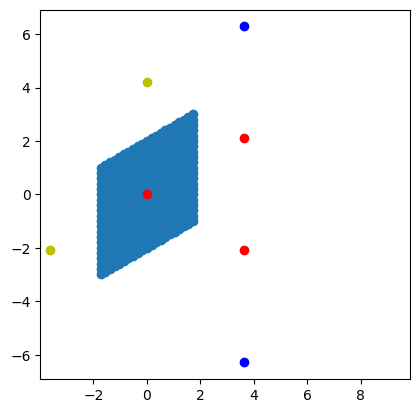

In [ ]:
plt.scatter(*params.k.T)
plt.scatter(*params.q.T,color='r')
plt.scatter(*params.bM.T,color='b')
plt.scatter(*params.bm.T,color='y')
plt.axis('square')

In [ ]:
params.am_index

array([[ 1,  1],
       [ 2, -1]])

In [ ]:
params.bm_index

array([[-0.33333333, -0.66666667],
       [-0.33333333,  0.33333333]])

In [ ]:
params.am.T@params.bm

array([[-3.14159265e+00, -5.77375316e-17],
       [-6.06792571e-17, -3.14159265e+00]])

In [ ]:
a = np.arange(60.).reshape(3,4,5)
b = np.arange(24.).reshape(4,3,2)

In [ ]:
c=np.tensordot(a, b,axes=([0],[1]))

In [ ]:
c.shape

(4, 5, 4, 2)

# Gap analytical results

In [ ]:
params=Params(t=[0,-1,0],U=[1,0],h=.6,nu=[12,6],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

In [11]:
spin_list[-1]

array([[ 1.00000000e+00,  9.76438908e-03, -3.49292669e-36,
        -6.94861380e-02],
       [ 1.00000000e+00,  9.76438908e-03, -3.49292669e-36,
        -6.94861380e-02],
       [ 1.00000000e+00,  9.76438908e-03,  1.86285235e-35,
        -6.94861380e-02],
       [ 1.00000000e+00, -9.76438908e-03,  3.53706142e-36,
        -6.94861380e-02],
       [ 1.00000000e+00, -9.76438908e-03,  3.53706142e-36,
        -6.94861380e-02],
       [ 1.00000000e+00, -9.76438908e-03,  4.12657166e-36,
        -6.94861380e-02]])

In [ ]:
U_list=np.linspace(0.1,1,20)
# gap_H=[]
gap_noH=[]
for U in U_list:
    print(U)
    params=Params(t=[0,-1,0],U=[U,0],h=.6,nu=[12,6],n=15)
    gap_list,energy_list,spin_list,ave=params.iteration(print_opt='')
    # gap_H.append(gap_list[-1])
    gap_noH.append(gap_list[-1])

U_list_anal=np.linspace(1e-2,1,100)
gap_anal=np.array([gap_vs_U(U,params) for U in U_list_anal])

with open('data.pickle','wb') as f:
    pickle.dump([U_list,np.array(gap_noH),U_list_anal,gap_anal],f)

Text(0, 0.5, 'Gap')

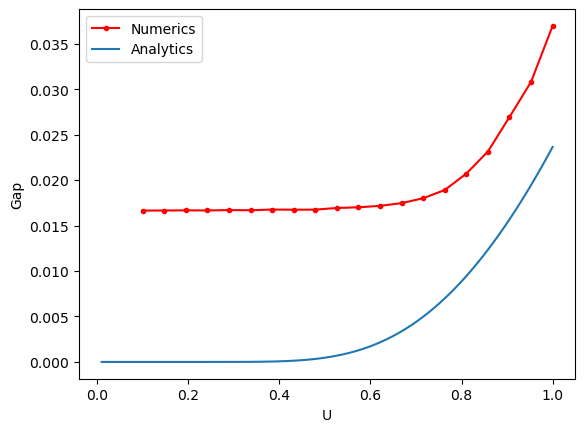

In [19]:
with open('data_h_0.6_n_15.pickle','rb') as f:
    [U_list,gap_noH,U_list_anal,gap_anal]=pickle.load(f)
# plt.plot(U_list,gap_H)
plt.plot(U_list,gap_noH,'.-',color='r',label='Numerics')

plt.plot(U_list_anal,gap_anal,label='Analytics')
plt.legend()
plt.xlabel('U')
plt.ylabel('Gap')

# plt.ylim([0,0.6])
# plt.xlim([0,1])

Text(0, 0.5, 'Gap')

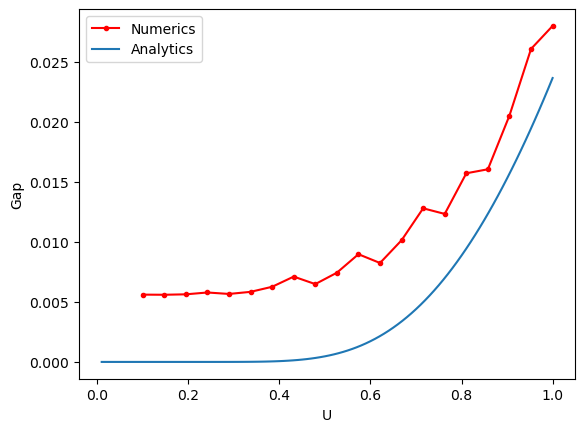

In [20]:
with open('data_h_0.6_n_33.pickle','rb') as f:
    [U_list,gap_noH,U_list_anal,gap_anal]=pickle.load(f)
# plt.plot(U_list,gap_H)
plt.plot(U_list,gap_noH,'.-',color='r',label='Numerics')

plt.plot(U_list_anal,gap_anal,label='Analytics')
plt.legend()
plt.xlabel('U')
plt.ylabel('Gap')

# plt.ylim([0,0.6])
# plt.xlim([0,1])

Text(0, 0.5, 'Gap')

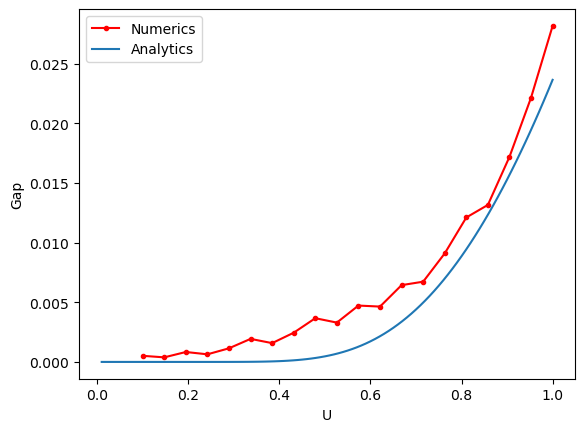

In [87]:
with open('data_h_0.6_n_69.pickle','rb') as f:
    [U_list,gap_noH,U_list_anal,gap_anal]=pickle.load(f)
# plt.plot(U_list,gap_H)
plt.plot(U_list,gap_noH,'.-',color='r',label='Numerics')

plt.plot(U_list_anal,gap_anal,label='Analytics')
plt.legend()
plt.xlabel('U')
plt.ylabel('Gap')

# plt.ylim([0,0.6])
# plt.xlim([0,1])

Text(0, 0.5, 'Gap')

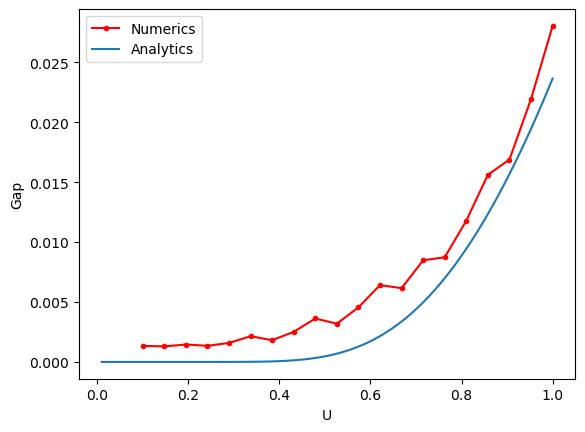

In [169]:
with open('data_h_0.6_n_123.pickle','rb') as f:
    [U_list,gap_noH,U_list_anal,gap_anal]=pickle.load(f)
# plt.plot(U_list,gap_H)
plt.plot(U_list,gap_noH,'.-',color='r',label='Numerics')

plt.plot(U_list_anal,gap_anal,label='Analytics')
plt.legend()
plt.xlabel('U')
plt.ylabel('Gap')

# plt.ylim([0,0.6])
# plt.xlim([0,1])

Text(0, 0.5, 'Gap')

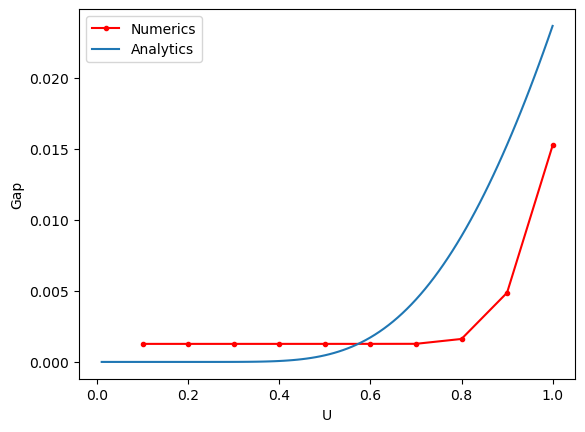

In [133]:
with open('data_h_0.6_n_123_thres_1e-08.pickle','rb') as f:
    [U_list,gap_noH,U_list_anal,gap_anal]=pickle.load(f)
# plt.plot(U_list,gap_H)
plt.plot(U_list,gap_noH,'.-',color='r',label='Numerics')

plt.plot(U_list_anal,gap_anal,label='Analytics')
plt.legend()
plt.xlabel('U')
plt.ylabel('Gap')

# plt.ylim([0,0.6])
# plt.xlim([0,1])

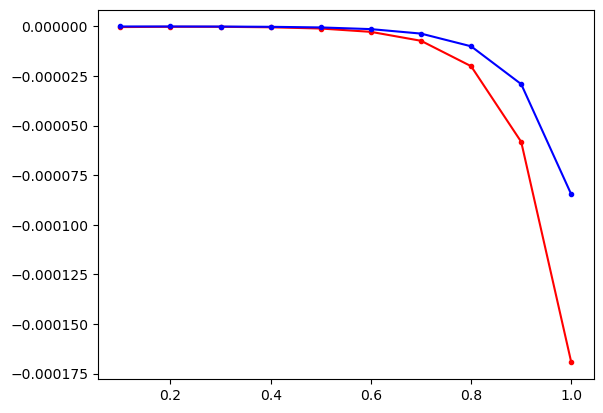

In [253]:
with open('results_nu(12,6)_t1(-1.0,-1.0,1)_t2(0.0,0.0,1)_U0(0.1,1.0,10)_U1(0.0,0.0,1)_h0.6_thres1e-10_n69_noH.pkl','rb') as f:
    rs=pickle.load(f)

U_list=np.array([rs[(0,0,x,0)]['U0'] for x in range(10)])
gap_noH=np.array([rs[(0,0,x,0)]['gap'] for x in range(10)])
en_noH=np.array([rs[(0,0,x,0)]['energy'] for x in range(10)])
# plt.plot(U_list,gap_H)
# plt.plot(U_list,gap_noH,'.-',color='r',label='Numerics')
plt.plot(U_list,-gap_noH**2/U_list,'.-',color='r',label='Numerics')
plt.plot(U_list,en_noH,'.-',color='b',label='Numerics')


# U_list_anal=np.linspace(1e-2,1,100)
# gap_anal=np.array([gap_vs_U(U,params) for U in U_list_anal])
# plt.plot(U_list_anal,gap_anal,label='Analytics')
# plt.legend()
# plt.xlabel('U')
# plt.ylabel('Gap')

# plt.ylim([0,0.6])
# plt.xlim([0,1])

Text(0, 0.5, 'Gap')

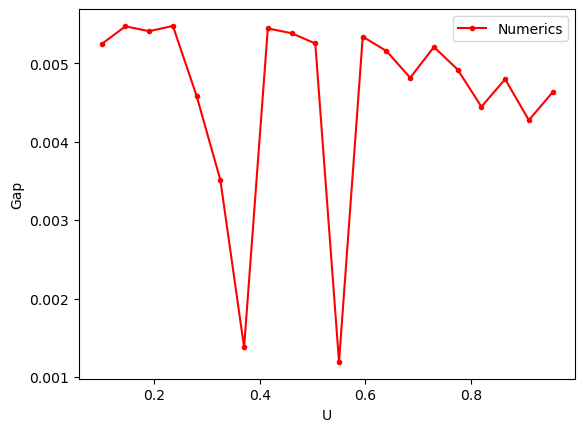

In [6]:
# with open('results_nu(14,7)_t1(-1.0,-1.0,1)_t2(0.0,0.0,1)_U0(0.0,0.0,1)_U1(0.1,1.0,10)_h0.3_thres1e-10_n69_noH_.pkl','rb') as f:
# with open('results_nu(14,7)_t1(-1.0,-1.0,1)_t2(0.0,0.0,1)_U0(0.0,0.0,1)_U1(0.1,1.0,10)_h0.6_thres1e-10_n69_noH_.pkl','rb') as f:
with open('results_nu(14,7)_t1(-1.0,-1.0,1)_t2(0.0,0.0,1)_U0(0.0,0.0,1)_U1(0.1,1.0,21)_h0.5_thres1e-05_n69_noH.pkl','rb') as f:
    rs=pickle.load(f)

U_list=[rs[(0,0,0,x)]['U1'] for x in range(20)]
gap_noH=[rs[(0,0,0,x)]['gap'] for x in range(20)]
# plt.plot(U_list,gap_H)
plt.plot(U_list,gap_noH,'.-',color='r',label='Numerics')


U_list_anal=np.linspace(1e-2,1,100)
gap_anal=np.array([gap_vs_U_indep(U=U,t1=rs[(0,0,0,0)]['t1'],h=0.3,epsilon=0.3,k=2/3) for U in U_list_anal])
# plt.plot(U_list_anal,gap_anal,label='Analytics')


plt.legend()
plt.xlabel('U')
plt.ylabel('Gap')

# plt.ylim([0,0.6])
# plt.xlim([0,1])

In [ ]:
rs[(0,0,0,10)]['spin']

In [4]:
params=Params(t=[0,-1,0],U=[0,1],h=.3,nu=[12,6],n=81)

In [5]:
np.sqrt(2*np.pi/(np.sqrt(3)*1/4)/params.k.shape[0])*np.sqrt(3)/2*np.abs(params.t[1])

0.04072726336263954

In [ ]:
np.sqrt(2*np.pi/(np.sqrt(3)*1/4)/params.k.shape[0])*np.sqrt(3)/2*np.abs(params.t[1])

0.047810265686576855

In [14]:
np.sqrt(2*np.pi/(np.sqrt(3)*1/4)/params.k.shape[0])*np.sqrt(3)/2*np.abs(params.t[1])

0.09996691916284252

In [9]:
gap_vs_U_indep(1,1,0.5,0.5,2/3)

0.04321391826377227

In [ ]:
with open('results_nu(14,7)_t1(-1.0,-1.0,1)_t2(0.0,0.0,1)_U0(0.0,0.0,1)_U1(0.1,1.0,10)_h0.3_thres1e-10_n69_noH_.pkl','rb') as f:
    rs198=pickle.load(f

Text(0, 0.5, 'Gap')

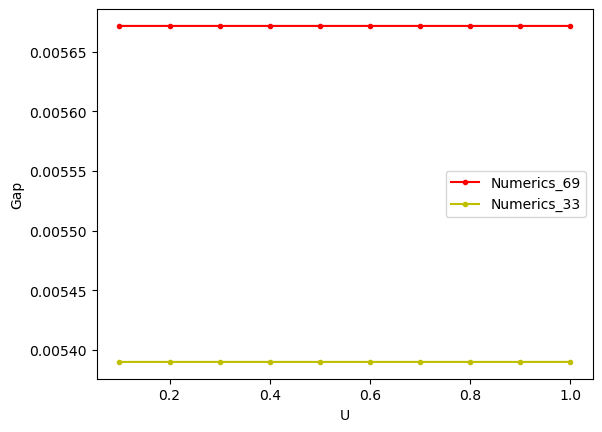

In [13]:
with open('results_nu(14,7)_t1(-1.0,-1.0,1)_t2(0.0,0.0,1)_U0(0.0,0.0,1)_U1(0.1,1.0,10)_h0.3_thres1e-10_n69_noH_.pkl','rb') as f:
    rs69=pickle.load(f)
with open('results_nu(14,7)_t1(-1.0,-1.0,1)_t2(0.0,0.0,1)_U0(0.0,0.0,1)_U1(0.1,1.0,10)_h0.3_thres1e-10_n33_noH_.pkl','rb') as f:
    rs33=pickle.load(f)

U_list=[rs69[(0,0,0,x)]['U1'] for x in range(10)]
gap_noH=[rs69[(0,0,0,x)]['gap'] for x in range(10)]
plt.plot(U_list,gap_noH,'.-',color='r',label='Numerics_69')

U_list=[rs33[(0,0,0,x)]['U1'] for x in range(10)]
gap_noH=[rs33[(0,0,0,x)]['gap'] for x in range(10)]
plt.plot(U_list,gap_noH,'.-',color='y',label='Numerics_33')


# U_list_anal=np.linspace(1e-2,1,100)
# gap_anal=np.array([gap_vs_U_indep(U=U,t1=rs[(0,0,0,0)]['t1'],h=0.3,epsilon=0.3,k=2/3) for U in U_list_anal])
# plt.plot(U_list_anal,gap_anal,label='Analytics')


plt.legend()
plt.xlabel('U')
plt.ylabel('Gap')

# plt.ylim([0,0.6])
# plt.xlim([0,1])

In [76]:
rs[(0,0,0,9)]['spin'][1]

A1                  A2                  A3  \
A1  0.000047+0.000000j -0.000011-0.000000j -0.000005+0.000000j   
A2 -0.000011+0.000000j -0.000024+0.000000j  0.000011-0.000000j   
A3 -0.000005-0.000000j  0.000011+0.000000j -0.000024+0.000000j   
B1  0.002195-0.000000j -0.000571+0.000000j -0.000439+0.000000j   
B2 -0.001085-0.000000j -0.001098+0.000000j  0.001143+0.000000j   
B3 -0.000558+0.000000j  0.002170-0.000000j -0.001098-0.000000j   

                    B1                  B2                  B3  
A1  0.002195+0.000000j -0.001085+0.000000j -0.000558-0.000000j  
A2 -0.000571-0.000000j -0.001098-0.000000j  0.002170+0.000000j  
A3 -0.000439-0.000000j  0.001143-0.000000j -0.001098+0.000000j  
B1 -0.000047+0.000000j  0.000000+0.000000j  0.000005+0.000000j  
B2  0.000000-0.000000j  0.000024+0.000000j -0.000011+0.000000j  
B3  0.000005-0.000000j -0.000011-0.000000j  0.000024-0.000000j

In [60]:
rs[(0,0,0,4)]['gap']

0.0002852663918142198

In [5]:
[rs[(0,0,x,0)]['gap'] for x in range(10)]

[0.003663126571384727,
 0.005468279439540799,
 0.0017011292285482593,
 0.005977173063207081,
 0.008291938090429635,
 0.005913418107903301,
 0.008968318121260754,
 0.01349560630315888,
 0.020452644220164906,
 0.03208780254683241]

# DOS

In [50]:
params_B.aM

93.965078401455

In [15]:
params=Params(aM0=params_B.aM,t=[348.30022932, -17.24144653,  -2.09686444],U=[1,0],h=0.0,nu=[2,1],n=33)
# ave=params._ansatz_from_order_parameter(params.O_max,params.l)
T=params._generate_T(params.k)
# H_F=params._generate_Fock(ave)

Energy resolution: 1.7235742915149816


In [62]:
params.t[2]/params.t[1]

0.12002182214948173

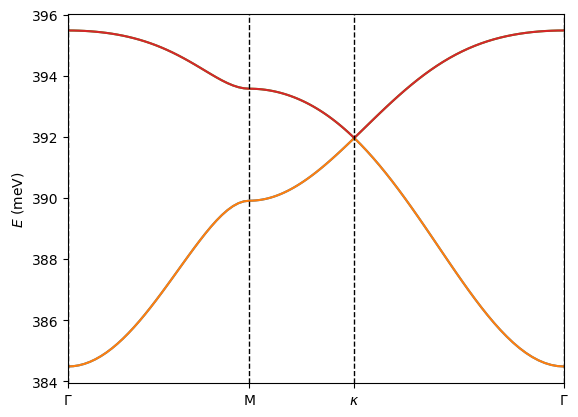

In [59]:
fig,ax=plt.subplots()
_=params.plot_dispersion(ax=ax)

In [13]:
def solve_params(energies):
    '''
    energies should be Gamma top, K, Gamma bottom
    '''
    coef=np.array([[1,-3,6],[1,0,-3],[1,3,6]])
    return np.linalg.solve(coef,energies)

In [14]:
solve_params([energy_list[:,1].max(),energy_list[:,1].min(),energy_list[:,2].min()])

array([348.30022932, -17.24144653,  -2.09686444])

In [17]:
-2.09686444/-17.24144653

0.12161766336435113

In [4]:
import sys
sys.path.append('../../ABBA/')
import four_layer

In [5]:
pp=np.array([0.200260,-0.159183,-0.008583,-0.176364,0.184207,0.356749,-0.009703])

In [7]:
params_B=four_layer.Params(Nmax=3,**four_layer.convert_params(pp),Ez=00,theta=5,B=0,n=33)


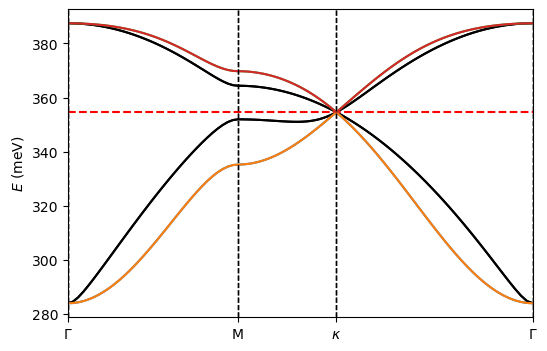

In [16]:
fig,ax=plt.subplots(figsize=(6,4))
energy_list=params_B.plot_dispersion(k=4,ax=ax)
ax.axhline(y=(energy_list[:,1].min()+energy_list[:,2].max())/2,ls='dashed',color='red')
_=params.plot_dispersion(ax=ax)

In [17]:
energyall0,wfall0=params._eig(T)

In [18]:
from scipy.stats import gaussian_kde

In [19]:
kernel = gaussian_kde(energyall0.flatten(),bw_method=0.02)

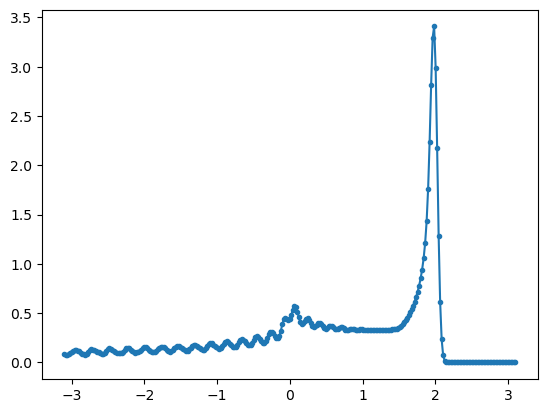

In [20]:
x=np.linspace(-3.1,3.1,301)
plt.plot(x,kernel.evaluate(x)*2,'.-')
# plt.plot(z[:,0],z[:,1])


In [118]:
kernel.evaluate(0.104544150524082)*2

array([0.0385781])

In [142]:
kernel.evaluate(0.)*2

array([0.25428398])

In [135]:
1/(kernel.evaluate(0.)*2*1)

array([8.78805668])

In [136]:
np.sinh(8.78)

3251.4385097843933

In [22]:
np.trapz(kernel.evaluate(x)*2,x=x)

2.005522295492777

# Direct input order parameter

In [23]:
params=Params(t=[0,-1,-0],U=[2,0.6],h=.6,nu=[-6,-3],n=69)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

Energy resolution: 0.027603269764172676
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S2: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=0.00017343387533230725
E(meV):-0.6206769773661771
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: -0.0000 0.0000 0.0000 -0.0000 -0.0000 0.0000
S2: -0.0000 0.0000 -0.0000 0.0000 -0.0000 0.0000
S3: -0.0711 -0.0711 -0.0711 -0.0711 -0.0711 -0.0711
Iteration 1:	
Gap(meV)=0.0019131610140994404
E(meV):-0.6185044522407527
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: -0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000
S2: -0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000
S3: -0.0909 -0.0909 -0.0909 -0.0909 -0.0909 -0.0909
Iteration 2:	
Gap(meV)=0.0011926570666105363
E(meV):-0.6175002443895472
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: -0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000
S2: -0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000
S3: -0.0963 -0.0963 -0.

In [25]:
params=Params(t=[0,-1,-0],U=[2,0.],h=.6,nu=[-6,-3],n=69)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

Energy resolution: 0.027603269764172676
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S2: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=0.0001734338753345277
E(meV):-2.1817664376388186
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0000 -0.0000 -0.0000 -0.0000 -0.0000 0.0000
S2: -0.0000 0.0000 0.0000 -0.0000 0.0000 -0.0000
S3: -0.0711 -0.0711 -0.0711 -0.0711 -0.0711 -0.0711
Iteration 1:	
Gap(meV)=0.0019131610141015498
E(meV):-2.1834710733182177
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0000 0.0000 0.0000 -0.0000 -0.0000 -0.0000
S2: -0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000
S3: -0.0909 -0.0909 -0.0909 -0.0909 -0.0909 -0.0909
Iteration 2:	
Gap(meV)=0.0011926570666125347
E(meV):-2.183606174828474
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0000 0.0000 0.0000 -0.0000 -0.0000 -0.0000
S2: -0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000
S3: -0.0963 -0.0963 -0.0

In [29]:
params=Params(t=[0,-1,-0],U=[1,0.],h=.6,nu=[-6,-3],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

Energy resolution: 0.05771592768872468
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S2: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=0.0055884970917449706
E(meV):-2.679084345170362
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: -0.0000 0.0000 0.0000 0.0000 -0.0000 -0.0000
S2: -0.0000 0.0000 -0.0000 0.0000 -0.0000 -0.0000
S3: -0.0686 -0.0686 -0.0686 -0.0686 -0.0686 -0.0686
Iteration 1:	
Gap(meV)=0.007741663902324392
E(meV):-2.679570426198611
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0000 0.0000 0.0000 -0.0000 -0.0000 -0.0000
S2: 0.0000 0.0000 0.0000 -0.0000 -0.0000 -0.0000
S3: -0.0796 -0.0796 -0.0796 -0.0796 -0.0796 -0.0796
Iteration 2:	
Gap(meV)=0.003277619844221147
E(meV):-2.679589211018207
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0000 0.0000 -0.0000 -0.0000 -0.0000 0.0000
S2: 0.0000 0.0000 0.0000 -0.0000 -0.0000 -0.0000
S3: -0.0833 -0.0833 -0.0833 -

In [24]:
params_M=Params(t=[0,-1,-0],U=[2.8,1],h=.6,nu=[-4,-2],n=12)
gap_list,energy_list,spin_list,ave=params_M.iteration(print_opt='o',thres=1e-10)

Energy resolution: 0.27490902769781694
S0: 1.0000 1.0000
S1: 0.0000 0.0000
S2: 0.0000 0.0000
S3: 0.0000 0.0000
Iteration 0:	
Gap(meV)=0.018808795936539724
E(meV):0.8156485475308244
S0: 1.0000 1.0000
S1: 0.0000 0.0000
S2: 0.0000 0.0000
S3: -0.0556 -0.0556


(-0.5, 0.5)

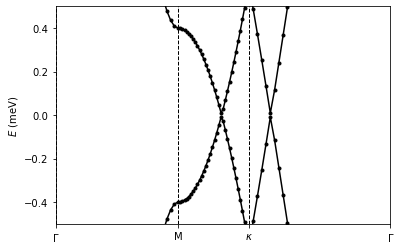

In [93]:
params_M.plot_dispersion(color='k',marker='.')
# plt.ylim(-3,3)
plt.ylim(-.5,.5)

(2.0, 3.0)

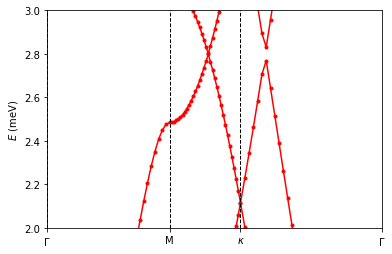

In [92]:
params_M.plot_dispersion(ave,color='r',marker='.')
plt.ylim(2,3)
# plt.y

array([[-0.88448118,  0.48448118,  5.11551882,  6.48448118],
       [-0.88146094,  0.48750141,  5.11249859,  6.48146094],
       [-0.87240935,  0.496553  ,  5.103447  ,  6.47240935],
       [-0.85735384,  0.51160851,  5.08839149,  6.45735384],
       [-0.83634021,  0.53262215,  5.06737785,  6.43634021],
       [-0.80943276,  0.55952959,  5.04047041,  6.40943276],
       [-0.77671459,  0.59224776,  5.00775224,  6.37671459],
       [-0.73828782,  0.63067453,  4.96932547,  6.33828782],
       [-0.69427408,  0.67468827,  4.92531173,  6.29427408],
       [-0.64481502,  0.72414733,  4.87585267,  6.24481502],
       [-0.5900731 ,  0.77888926,  4.82111074,  6.1900731 ],
       [-0.53023249,  0.83872986,  4.76127014,  6.13023249],
       [-0.46550036,  0.90346199,  4.69653801,  6.06550036],
       [-0.39610851,  0.97285384,  4.62714616,  5.99610851],
       [-0.32231541,  1.04664694,  4.55335306,  5.92231541],
       [-0.244409  ,  1.12455335,  4.47544665,  5.844409  ],
       [-0.16271024,  1.

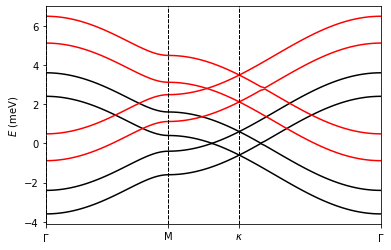

In [84]:
fig,axs=plt.subplots(1,2)
params_M.plot_dispersion(ax=axs,color='k')
params_M.plot_dispersion(ave,ax=axs,color='r')

## intra s

In [24]:
params=Params(t=[0,-1,-0],U=[2,0.6],h=.6,nu=[12,6],n=69)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

Energy resolution: 0.027603269764172676
S0: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S1: 13.2670 13.2670 13.2670 -13.2670 -13.2670 -13.2670
S2: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=24.49498854777564
E(meV):1.3034354351729933
S0: 1.0065 1.0065 1.0065 0.9935 0.9935 0.9935
S1: 0.9883 0.9883 0.9883 -0.9883 -0.9883 -0.9883
S2: -0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0000
S3: -0.0505 -0.0505 -0.0505 -0.0505 -0.0505 -0.0505
Iteration 1:	
Gap(meV)=1.973940720257768
E(meV):-0.47687831520441754
S0: 1.0030 1.0030 1.0030 0.9970 0.9970 0.9970
S1: 0.5862 0.5862 0.5862 -0.5862 -0.5862 -0.5862
S2: 0.0000 0.0000 0.0000 -0.0000 -0.0000 -0.0000
S3: -0.1739 -0.1739 -0.1739 -0.1739 -0.1739 -0.1739
Iteration 2:	
Gap(meV)=1.1622289939874344
E(meV):-0.572810889239286
S0: 1.0036 1.0036 1.0036 0.9964 0.9964 0.9964
S1: 0.4530 0.4530 0.4530 -0.4530 -0.4530 -0.4530
S2: 0.0000 0.0000 -0.0000 0.0000 0.0000 0.0000
S3: -0.1950 -0.1950 -0.195

In [26]:
params=Params(t=[0,-1,-0],U=[2,0.],h=.6,nu=[12,6],n=69)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

Energy resolution: 0.027603269764172676
S0: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S1: 13.2670 13.2670 13.2670 -13.2670 -13.2670 -13.2670
S2: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=26.53399378022175
E(meV):-0.4810224670956022
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.9907 0.9907 0.9907 -0.9907 -0.9907 -0.9907
S2: -0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000
S3: -0.0441 -0.0441 -0.0441 -0.0441 -0.0441 -0.0441
Iteration 1:	
Gap(meV)=1.981414701495627
E(meV):-2.1109848687858417
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.5868 0.5868 0.5868 -0.5868 -0.5868 -0.5868
S2: -0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0000
S3: -0.1705 -0.1705 -0.1705 -0.1705 -0.1705 -0.1705
Iteration 2:	
Gap(meV)=1.1735791055498
E(meV):-2.18370682099849
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.4519 0.4519 0.4519 -0.4519 -0.4519 -0.4519
S2: -0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0000
S3: -0.1898 -0.1898 -0.18

In [54]:
params=Params(t=[0,-1,-0],U=[1,0.],h=.6,nu=[12,6],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

Energy resolution: 0.05771592768872468
S0: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S1: 13.2670 13.2670 13.2670 -13.2670 -13.2670 -13.2670
S2: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=13.266982249449878
E(meV):-0.9173507500479913
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.9654 0.9654 0.9654 -0.9654 -0.9654 -0.9654
S2: -0.0000 -0.0000 0.0000 0.0000 0.0000 0.0000
S3: -0.0821 -0.0821 -0.0821 -0.0821 -0.0821 -0.0821
Iteration 1:	
Gap(meV)=0.965467354501613
E(meV):-2.6045265772058106
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.3923 0.3923 0.3923 -0.3923 -0.3923 -0.3923
S2: -0.0000 -0.0000 0.0000 -0.0000 -0.0000 -0.0000
S3: -0.1372 -0.1372 -0.1372 -0.1372 -0.1372 -0.1372
Iteration 2:	
Gap(meV)=0.39245881074368993
E(meV):-2.6656396658988344
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.2178 0.2178 0.2178 -0.2178 -0.2178 -0.2178
S2: -0.0000 -0.0000 -0.0000 -0.0000 -0.0000 0.0000
S3: -0.1098 -0.1098 -0

In [64]:
params=Params(t=[0,-1,-0],U=[2,0.6],h=.6,nu=[2,1],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

Energy resolution: 0.09996691916284252
S0: 1.0000 1.0000
S1: 1.0000 -1.0000
S2: 0.0000 0.0000
S3: 0.0000 0.0000
Iteration 0:	
Gap(meV)=2.0003911545377377
E(meV):-0.47212259907986226
S0: 1.0000 1.0000
S1: 0.5882 -0.5882
S2: 0.0000 0.0000
S3: -0.1577 -0.1577
Iteration 1:	
Gap(meV)=1.166019339614257
E(meV):-0.5738613677424403
S0: 1.0024 0.9976
S1: 0.4524 -0.4524
S2: 0.0000 0.0000
S3: -0.1891 -0.1891
Iteration 2:	
Gap(meV)=0.8909891172251085
E(meV):-0.5929074367142243
S0: 1.0036 0.9964
S1: 0.3947 -0.3947
S2: -0.0000 0.0000
S3: -0.1894 -0.1894
Iteration 3:	
Gap(meV)=0.7754251785018353
E(meV):-0.5999983027223285
S0: 1.0039 0.9961
S1: 0.3657 -0.3657
S2: 0.0000 -0.0000
S3: -0.1836 -0.1836
Iteration 4:	
Gap(meV)=0.7175242479186217
E(meV):-0.6037101184905059
S0: 1.0038 0.9962
S1: 0.3493 -0.3493
S2: -0.0000 0.0000
S3: -0.1779 -0.1779
Iteration 5:	
Gap(meV)=0.6851283573003131
E(meV):-0.6058923826033663
S0: 1.0037 0.9963
S1: 0.3394 -0.3394
S2: 0.0000 -0.0000
S3: -0.1737 -0.1737
Iteration 6:	
Gap(me

array([[-9.75760941e-01,  5.36260429e-01,  5.06373957e+00,
         6.57576094e+00],
       [-9.72753407e-01,  5.39250444e-01,  5.06074956e+00,
         6.57275341e+00],
       [-9.63740026e-01,  5.48210971e-01,  5.05178903e+00,
         6.56374003e+00],
       [-9.48748492e-01,  5.63113414e-01,  5.03688659e+00,
         6.54874849e+00],
       [-9.27825062e-01,  5.83909979e-01,  5.01609002e+00,
         6.52782506e+00],
       [-9.01034711e-01,  6.10533466e-01,  4.98946653e+00,
         6.50103471e+00],
       [-8.68461366e-01,  6.42896959e-01,  4.95710304e+00,
         6.46846137e+00],
       [-8.30208229e-01,  6.80893394e-01,  4.91910661e+00,
         6.43020823e+00],
       [-7.86398213e-01,  7.24394981e-01,  4.87560502e+00,
         6.38639821e+00],
       [-7.37174521e-01,  7.73252434e-01,  4.82674757e+00,
         6.33717452e+00],
       [-6.82701402e-01,  8.27293978e-01,  4.77270602e+00,
         6.28270140e+00],
       [-6.23165129e-01,  8.86324041e-01,  4.71367596e+00,
      

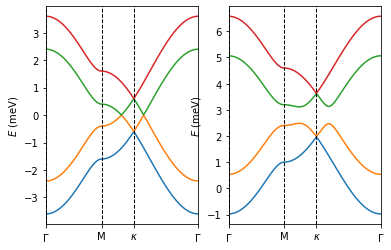

In [65]:
fig,axs=plt.subplots(1,2)
params.plot_dispersion(ax=axs[0])
params.plot_dispersion(ave,ax=axs[1])
# plt.ylim(-0.3,0.3)

In [5]:
gap_vs_U_indep(1,1,0.4,0.4,k=2/3)

0.0157622983892937

In [ ]:
params=Params(t=[0,-1,0],U=[1,0],h=.6,nu=[12,6],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

In [236]:
gap_list[-1]**2/params.U[0]

0.0003044353322917944

(0.0, 1.0)

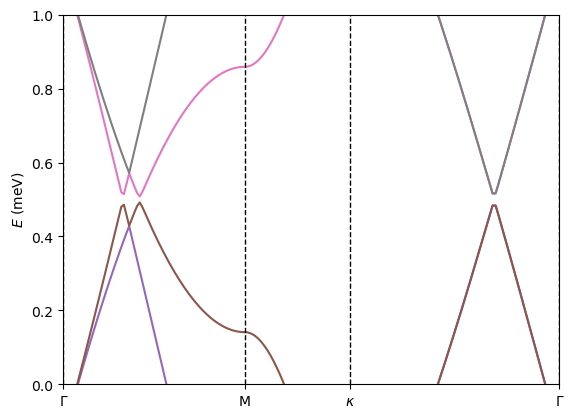

In [241]:
params.plot_dispersion(ave)
plt.ylim([0,1])

(-0.5, 0.5)

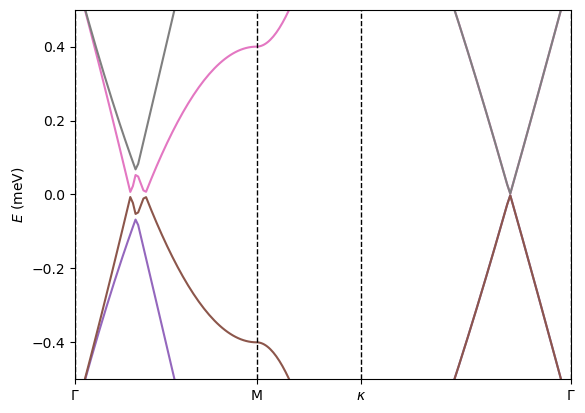

In [247]:
params.plot_dispersion()
plt.ylim([-.5,.5])

In [ ]:
params=Params(t=[0,-1,0],U=[1,0],h=.6,nu=[2,1],n=69)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

In [228]:
params=Params(t=[0,-1,0],U=[0.5,0],h=.4,nu=[12,6],n=69,hartree=False)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

S0: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S1: 5.8964 5.8964 5.8964 -5.8964 -5.8964 -5.8964
S2: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=2.9482221618665276
E(meV):-2.2808244583334565
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.7014 0.7014 0.7014 -0.7014 -0.7014 -0.7014
S2: -0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0000
S3: -0.1079 -0.1079 -0.1079 -0.1079 -0.1079 -0.1079
Iteration 1:	
Gap(meV)=0.3506976039186547
E(meV):-2.887695038160855
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.1687 0.1687 0.1687 -0.1687 -0.1687 -0.1687
S2: -0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0000
S3: -0.0423 -0.0423 -0.0423 -0.0423 -0.0423 -0.0423
Iteration 2:	
Gap(meV)=0.08442999461195452
E(meV):-2.9060630241635197
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0504 0.0504 0.0504 -0.0504 -0.0504 -0.0504
S2: 0.0000 0.0000 0.0000 -0.0000 -0.0000 -0.0000
S3: -0.0315 -0.0315 -0.0315 -0.0315 -0.0315 -0.0315
Iteration 3:

In [352]:
params=Params(t=[0,-1,-.42],U=[4,0],h=.6,nu=[12,6],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

S0: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S1: 13.2670 13.2670 13.2670 -13.2670 -13.2670 -13.2670
S2: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=49.40302622852428
E(meV):-0.2436541818889434
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.9976 0.9976 0.9976 -0.9976 -0.9976 -0.9976
S2: -0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000
S3: -0.0225 -0.0225 -0.0225 -0.0225 -0.0225 -0.0225
Iteration 1:	
Gap(meV)=1.366850996660289
E(meV):-1.463565057252315
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.7823 0.7823 0.7823 -0.7823 -0.7823 -0.7823
S2: -0.0000 -0.0000 0.0000 -0.0000 -0.0000 0.0000
S3: -0.1706 -0.1706 -0.1706 -0.1706 -0.1706 -0.1706
Iteration 2:	
Gap(meV)=0.5286037420548759
E(meV):-1.5435360900187627
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.7143 0.7143 0.7143 -0.7143 -0.7143 -0.7143
S2: -0.0000 -0.0000 0.0000 0.0000 0.0000 -0.0000
S3: -0.2611 -0.2611 -0.2611 -0.2611 -0.2611 -0.2611
Iteration 3:	


array([[-5.16253789, -2.49650491,  1.32849581, ...,  5.19211638,
         5.19211638,  5.19211638],
       [-5.15903132, -2.49318903,  1.28465658, ...,  5.14974736,
         5.23264038,  5.23337212],
       [-5.14852034, -2.48325109,  1.23677198, ...,  5.1064546 ,
         5.27054407,  5.27332829],
       ...,
       [-5.143853  , -2.47883889,  1.22350189, ...,  5.09063141,
         5.28359438,  5.28359438],
       [-5.15786279, -2.4920841 ,  1.27806831, ...,  5.14256566,
         5.23916149,  5.23916149],
       [-5.16253789, -2.49650491,  1.32849581, ...,  5.19211638,
         5.19211638,  5.19211638]])

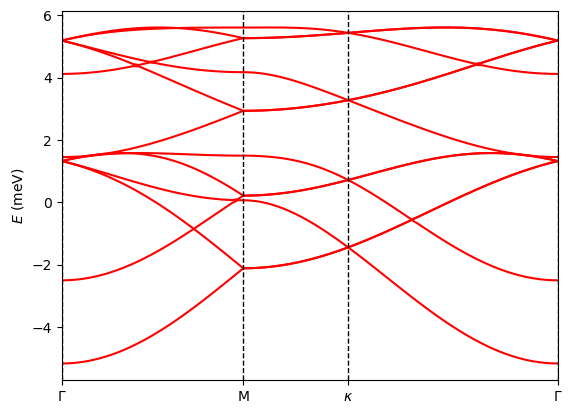

In [353]:
fig,ax=plt.subplots()
# params.plot_dispersion(ax=ax,color='k')
params.plot_dispersion(ave,ax=ax,color='r')

array([[-6.12      , -4.92      , -0.12      , ...,  1.86      ,
         1.86      ,  1.86      ],
       [-6.11645608, -4.91645608, -0.11846991, ...,  1.8043038 ,
         1.91320568,  1.91416611],
       [-6.10583301, -4.90583301, -0.11388631, ...,  1.74727549,
         1.96295574,  1.96661082],
       ...,
       [-6.10111582, -4.90111582, -0.11185235, ...,  1.7263942 ,
         1.98008988,  1.98008988],
       [-6.1152751 , -4.9152751 , -0.11796013, ...,  1.79485294,
         1.92176468,  1.92176468],
       [-6.12      , -4.92      , -0.12      , ...,  1.86      ,
         1.86      ,  1.86      ]])

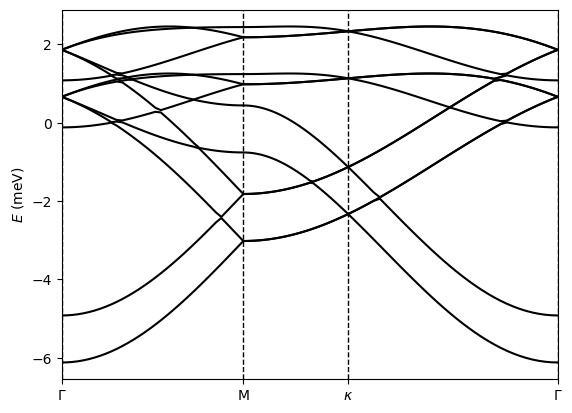

In [331]:
params.plot_dispersion(color='k')

In [104]:
def convert_pd(spin,digits=6):
    return pd.DataFrame(np.round(np.transpose(spin,axes=(0,2,1,3)).reshape((2*3,2*3)),6),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])


In [279]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),6),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1                  A2                  A3  \
A1  0.626294+0.000000j -0.030212-0.000000j -0.003679+0.000000j   
A2 -0.030212+0.000000j  0.626294+0.000000j -0.030212-0.000000j   
A3 -0.003679-0.000000j -0.030212-0.000000j  0.626294+0.000000j   
B1  0.000000+0.000000j  0.000000+0.000000j -0.000000+0.000000j   
B2  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
B3 -0.000000-0.000000j  0.000000+0.000000j  0.000000+0.000000j   

                    B1                  B2                  B3  
A1  0.000000-0.000000j  0.000000-0.000000j -0.000000+0.000000j  
A2  0.000000-0.000000j  0.000000-0.000000j  0.000000-0.000000j  
A3 -0.000000-0.000000j  0.000000-0.000000j  0.000000-0.000000j  
B1 -0.626294+0.000000j  0.030212-0.000000j  0.003679-0.000000j  
B2  0.030212+0.000000j -0.626294+0.000000j  0.030212-0.000000j  
B3  0.003679+0.000000j  0.030212+0.000000j -0.626294+0.000000j

In [280]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),6),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1                  A2                  A3  \
A1 -0.000000+0.000000j -0.000000+0.000000j  0.000000-0.000000j   
A2 -0.000000-0.000000j -0.000000+0.000000j -0.000000+0.000000j   
A3  0.000000+0.000000j -0.000000-0.000000j -0.000000+0.000000j   
B1 -0.000000-0.125720j  0.000000+0.026441j -0.000000-0.001869j   
B2 -0.000000-0.124801j -0.000000-0.125720j  0.000000+0.026441j   
B3  0.000000+0.026156j -0.000000-0.124801j  0.000000-0.125720j   

                    B1                  B2                  B3  
A1 -0.000000+0.125720j -0.000000+0.124801j  0.000000-0.026156j  
A2  0.000000-0.026441j -0.000000+0.125720j -0.000000+0.124801j  
A3 -0.000000+0.001869j  0.000000-0.026441j  0.000000+0.125720j  
B1  0.000000+0.000000j -0.000000-0.000000j  0.000000-0.000000j  
B2 -0.000000+0.000000j  0.000000+0.000000j -0.000000-0.000000j  
B3  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.000000j

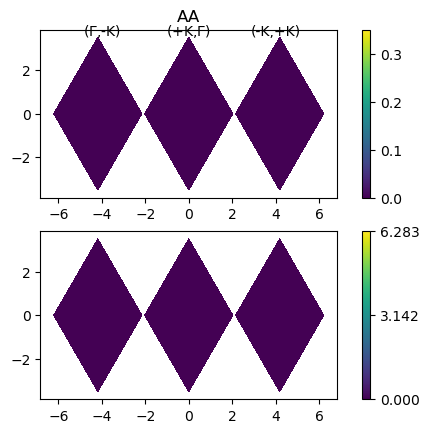

In [287]:
fig,axs=plt.subplots(2,1)

s1,s2=0,1
a1,a2=0,0
di=1

vmin,vmax=np.abs(ave[:,:,s1,a1,:,s2,a2]).min(),np.abs(ave[:,:,s1,a1,:,s2,a2]).max()
for i in range(3):
    im0=axs[0].tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,(i+di)%3,s1,a1,i,s2,a2]),vmin=vmin,vmax=vmax)

    im1=axs[1].tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,(i+di)%3,s1,a1,i,s2,a2])% (2*np.pi),vmin=0,vmax=2*np.pi)

cbar0 = fig.colorbar(im0, ax=axs[0])
cbar1 = fig.colorbar(im1, ax=axs[1],ticks=[0,np.pi,np.pi*2])
    
[ax.set_aspect('equal') for ax in axs]

axs[0].set_title(f'{sublattice(a1)}{sublattice(a2)}')
for i,x in zip(range(-1,2),[-4,0,4]):
    axs[0].text(x,3.8,f'({valley((i+di)%3)},{valley((i%3))})',ha='center',va='center')

# [ax.set_ylim([-0.8,0.8]) for ax in axs]
# [ax.set_xlim([-5,-3.6]) for ax in axs]

## inter s

In [14]:
params=Params(t=[0,-1,-0],U=[2,0.6],h=.6,nu=[14,7],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='m',thres=1e-10)

Energy resolution: 0.05771592768872468
                A1              A2              A3              B1              B2              B3
A1  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j  1.6584+0.0000j -0.7159-0.0000j -0.4303+0.0000j
A2  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.7159-0.0000j -0.8292+0.0000j  1.4319-0.0000j
A3  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.4303+0.0000j  1.4319-0.0000j -0.8292-0.0000j
B1  1.6584+0.0000j -0.7159-0.0000j -0.4303+0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j
B2 -0.7159-0.0000j -0.8292+0.0000j  1.4319-0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j
B3 -0.4303+0.0000j  1.4319-0.0000j -0.8292-0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j
Iteration 0:	
Gap(meV)=1.102457771976408
E(meV):-0.4651272381351055
                A1              A2              A3              B1              B2              B3
A1  0.0000+0.0000j -0.0000+0.0000j  0.0000-0.0000j  0.3375+0.0000j -0.1700+0.0000j -0.0087+0.0000j
A2

In [16]:
params=Params(t=[0,-1,0],U=[0,1],h=.5,nu=[14,7],n=69,hartree=False)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='m',thres=1e-10,iter_max=1)
print(tracemalloc.get_traced_memory())

Variable        Size           
self            1.01 GB        
print_opt       56.00 bytes    
iter_max        32.00 bytes    
thres           24.00 bytes    
plot            24.00 bytes    
                A1              A2              A3              B1              B2              B3
A1  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j  1.1516+0.0000j -0.5205-0.0000j -0.3733-0.0000j
A2  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.5205+0.0000j -0.5758+0.0000j  1.0410-0.0000j
A3  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j -0.3733+0.0000j  1.0410-0.0000j -0.5758+0.0000j
B1  1.1516+0.0000j -0.5205-0.0000j -0.3733-0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j
B2 -0.5205+0.0000j -0.5758+0.0000j  1.0410-0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j
B3 -0.3733+0.0000j  1.0410-0.0000j -0.5758+0.0000j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j
Iteration 0:	
Gap(meV)=1.4129707806341476
E(meV):-0.3639788256084821
                A1              A2            

NameError: name 'tracemalloc' is not defined

In [64]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),10),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1        A2        A3        B1        B2        B3
A1 -0.0+0.0j  0.0+0.0j -0.0-0.0j -0.0-0.0j  0.0+0.0j -0.0-0.0j
A2  0.0-0.0j -0.0-0.0j  0.0+0.0j  0.0-0.0j -0.0-0.0j  0.0+0.0j
A3 -0.0+0.0j  0.0-0.0j -0.0+0.0j -0.0+0.0j  0.0-0.0j -0.0-0.0j
B1 -0.0+0.0j  0.0+0.0j -0.0-0.0j  0.0-0.0j -0.0-0.0j  0.0+0.0j
B2  0.0-0.0j -0.0+0.0j  0.0+0.0j -0.0+0.0j  0.0+0.0j -0.0-0.0j
B3 -0.0+0.0j  0.0-0.0j -0.0+0.0j  0.0-0.0j -0.0+0.0j  0.0+0.0j

In [37]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1        A2        A3        B1        B2        B3
A1 -0.0+0.0j -0.0-0.0j  0.0-0.0j -0.0+0.0j -0.0+0.0j  0.0+0.0j
A2 -0.0+0.0j -0.0-0.0j  0.0+0.0j -0.0+0.0j -0.0-0.0j  0.0-0.0j
A3  0.0+0.0j  0.0-0.0j  0.0+0.0j  0.0+0.0j -0.0-0.0j -0.0-0.0j
B1 -0.0-0.0j -0.0-0.0j  0.0-0.0j  0.0+0.0j -0.0+0.0j  0.0+0.0j
B2 -0.0-0.0j -0.0+0.0j -0.0+0.0j -0.0-0.0j -0.0-0.0j -0.0-0.0j
B3  0.0-0.0j  0.0+0.0j -0.0+0.0j  0.0-0.0j -0.0+0.0j -0.0+0.0j

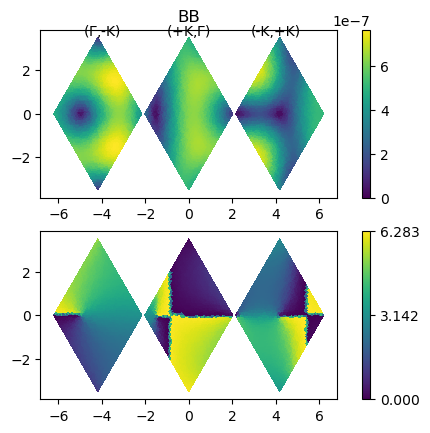

In [38]:
fig,axs=plt.subplots(2,1)

s1,s2=0,1
a1,a2=1,1
di=1

vmin,vmax=np.abs(ave[:,:,s1,a1,:,s2,a2]).min(),np.abs(ave[:,:,s1,a1,:,s2,a2]).max()
for i in range(3):
    im0=axs[0].tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,(i+di)%3,s1,a1,i,s2,a2]),vmin=vmin,vmax=vmax)

    im1=axs[1].tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,(i+di)%3,s1,a1,i,s2,a2])% (2*np.pi),vmin=0,vmax=2*np.pi)

cbar0 = fig.colorbar(im0, ax=axs[0])
cbar1 = fig.colorbar(im1, ax=axs[1],ticks=[0,np.pi,np.pi*2])
    
[ax.set_aspect('equal') for ax in axs]

axs[0].set_title(f'{sublattice(a1)}{sublattice(a2)}')
for i,x in zip(range(-1,2),[-4,0,4]):
    axs[0].text(x,3.8,f'({valley((i+di)%3)},{valley((i%3))})',ha='center',va='center')

# [ax.set_ylim([-0.8,0.8]) for ax in axs]
# [ax.set_xlim([-5,-3.6]) for ax in axs]

In [5]:
ave.max()

(0.500000000121242-7.822496050333258e-27j)

In [6]:
ave[:,:,0,:,:,1,:].max()

(5.668677457492816e-08-1.1151467679509914e-07j)

In [7]:
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),6),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1                  A2                  A3  \
A1  0.000000+0.000000j -0.000000+0.000000j  0.000000-0.000000j   
A2 -0.000000-0.000000j -0.000000-0.000000j  0.000000+0.000000j   
A3  0.000000+0.000000j  0.000000-0.000000j -0.000000+0.000000j   
B1 -0.000001-0.000000j -0.000001+0.000000j -0.000000-0.000000j   
B2  0.000001+0.000000j  0.000000+0.000000j  0.000001+0.000000j   
B3 -0.000000+0.000000j -0.000001+0.000000j  0.000000+0.000000j   

                    B1                  B2                  B3  
A1 -0.000001+0.000000j  0.000001-0.000000j -0.000000-0.000000j  
A2 -0.000001-0.000000j  0.000000-0.000000j -0.000001-0.000000j  
A3 -0.000000+0.000000j  0.000001-0.000000j  0.000000-0.000000j  
B1 -0.000000+0.000000j  0.000000-0.000000j  0.000000-0.000000j  
B2  0.000000+0.000000j -0.000000-0.000000j -0.000000-0.000000j  
B3  0.000000+0.000000j -0.000000+0.000000j  0.000000-0.000000j

In [246]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1        A2        A3        B1        B2        B3
A1 -0.0+0.0j  0.0+0.0j -0.0-0.0j -0.0-0.0j -0.0+0.0j  0.0-0.0j
A2  0.0-0.0j  0.0-0.0j -0.0-0.0j  0.0+0.0j  0.0-0.0j -0.0+0.0j
A3 -0.0+0.0j -0.0+0.0j -0.0+0.0j -0.0-0.0j  0.0+0.0j  0.0-0.0j
B1 -0.0+0.0j  0.0-0.0j -0.0+0.0j -0.0+0.0j  0.0+0.0j  0.0-0.0j
B2 -0.0-0.0j  0.0+0.0j  0.0-0.0j  0.0-0.0j  0.0-0.0j -0.0+0.0j
B3  0.0+0.0j -0.0-0.0j  0.0+0.0j  0.0+0.0j -0.0-0.0j  0.0+0.0j

(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

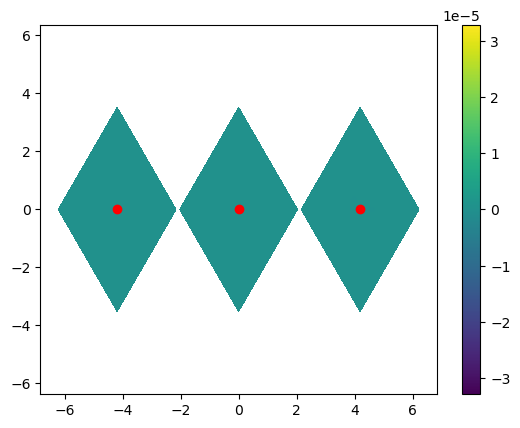

In [200]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+0)%3,s1,a1,i,s2,a2].real,vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-6.84169066781777, 6.84169066781777, -3.8694386436996675, 3.8694386436996675)

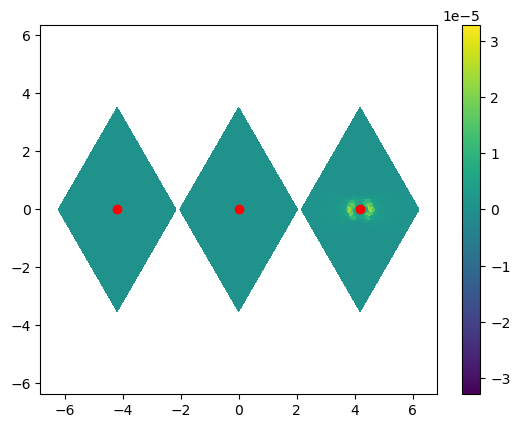

In [201]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+1)%3,s1,a1,i,s2,a2].real,vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

In [202]:
spin_mat=params._generate_spin_mat(ave)

In [203]:
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),3),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1        A2        A3        B1        B2        B3
A1  0.0+0.0j -0.0+0.0j -0.0-0.0j  0.0+0.0j  0.0+0.0j -0.0+0.0j
A2 -0.0-0.0j  0.0-0.0j -0.0+0.0j -0.0-0.0j  0.0+0.0j  0.0-0.0j
A3 -0.0+0.0j -0.0-0.0j  0.0-0.0j  0.0-0.0j -0.0+0.0j  0.0+0.0j
B1  0.0-0.0j -0.0+0.0j  0.0+0.0j -0.0-0.0j  0.0-0.0j  0.0+0.0j
B2  0.0-0.0j  0.0-0.0j -0.0-0.0j  0.0+0.0j -0.0+0.0j  0.0-0.0j
B3 -0.0-0.0j  0.0+0.0j  0.0-0.0j  0.0-0.0j  0.0+0.0j -0.0+0.0j

In [204]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),3),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1        A2        A3        B1        B2        B3
A1 -0.0+0.0j -0.0+0.0j  0.0-0.0j -0.0+0.0j  0.0+0.0j -0.0-0.0j
A2 -0.0-0.0j  0.0-0.0j  0.0+0.0j -0.0-0.0j -0.0+0.0j  0.0+0.0j
A3  0.0+0.0j  0.0-0.0j -0.0+0.0j  0.0-0.0j -0.0-0.0j -0.0+0.0j
B1 -0.0-0.0j -0.0+0.0j  0.0+0.0j  0.0+0.0j -0.0-0.0j  0.0+0.0j
B2  0.0-0.0j -0.0-0.0j -0.0+0.0j -0.0+0.0j  0.0+0.0j -0.0-0.0j
B3 -0.0+0.0j  0.0-0.0j -0.0-0.0j  0.0-0.0j -0.0+0.0j -0.0-0.0j

## intra p

In [16]:
params=Params(t=[0,-1,-0],U=[2,0.6],h=.6,nu=[16,8],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='m',thres=1e-10)

Energy resolution: 0.05771592768872468
                A1              A2              A3              B1              B2              B3
A1  0.0000+0.0000j  1.9538+0.0000j -3.0553-0.0000j -6.6335+0.0000j  2.4173+0.0000j  2.4720-0.0000j
A2  1.9538-0.0000j  0.0000+0.0000j  1.9538+0.0000j  3.0870-0.0000j -6.6335+0.0000j  2.4173+0.0000j
A3 -3.0553+0.0000j  1.9538-0.0000j  0.0000+0.0000j  0.2200-0.0000j  3.0870+0.0000j -6.6335+0.0000j
B1 -6.6335+0.0000j  3.0870+0.0000j  0.2200+0.0000j  0.0000+0.0000j -1.9538-0.0000j  3.0553+0.0000j
B2  2.4173-0.0000j -6.6335+0.0000j  3.0870+0.0000j -1.9538+0.0000j  0.0000+0.0000j -1.9538-0.0000j
B3  2.4720+0.0000j  2.4173-0.0000j -6.6335-0.0000j  3.0553-0.0000j -1.9538+0.0000j -0.0000+0.0000j
Iteration 0:	
Gap(meV)=1.1442748377055652
E(meV):0.22664802398276507
                A1              A2              A3              B1              B2              B3
A1  0.0452+0.0000j  0.0227-0.0000j -0.0007-0.0000j -0.4134-0.0000j  0.2344+0.0000j  0.0311-0.0000j
A

In [70]:
params=Params(t=[0,-1,0],U=[0.1,.5],h=.4,nu=[16,8],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='m')

                A1              A2              A3              B1              B2              B3
A1  0.0000+0.0000j  0.6050+0.0000j -1.0877-0.0000j -2.9482+0.0000j  1.2915+0.0000j  1.2965+0.0000j
A2  0.6050-0.0000j  0.0000+0.0000j  0.6050+0.0000j  1.4280-0.0000j -2.9482+0.0000j  1.2915+0.0000j
A3 -1.0877+0.0000j  0.6050-0.0000j -0.0000+0.0000j  0.7904-0.0000j  1.4280+0.0000j -2.9482-0.0000j
B1 -2.9482+0.0000j  1.4280+0.0000j  0.7904+0.0000j  0.0000+0.0000j -0.6050-0.0000j  1.0877+0.0000j
B2  1.2915-0.0000j -2.9482+0.0000j  1.4280+0.0000j -0.6050+0.0000j  0.0000+0.0000j -0.6050-0.0000j
B3  1.2965-0.0000j  1.2915-0.0000j -2.9482+0.0000j  1.0877-0.0000j -0.6050+0.0000j  0.0000+0.0000j
Iteration 0:	
Gap(meV)=0.7223568577173765
E(meV):-1.4436547896646774
                A1              A2              A3              B1              B2              B3
A1  0.0221+0.0000j  0.0219+0.0000j -0.0069+0.0000j -0.2708-0.0000j  0.1401-0.0000j  0.0425+0.0000j
A2  0.0219-0.0000j  0.0221+0.0000j  0.02

In [74]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1  0.0000+0.0000j  0.0001-0.0000j -0.0001+0.0000j -0.0010+0.0000j   
A2  0.0001+0.0000j  0.0000+0.0000j  0.0001-0.0000j  0.0004+0.0000j   
A3 -0.0001-0.0000j  0.0001+0.0000j  0.0000+0.0000j  0.0002-0.0000j   
B1 -0.0010-0.0000j  0.0004-0.0000j  0.0002+0.0000j -0.0000+0.0000j   
B2  0.0005+0.0000j -0.0010-0.0000j  0.0004-0.0000j -0.0001+0.0000j   
B3  0.0003-0.0000j  0.0005+0.0000j -0.0010-0.0000j  0.0001-0.0000j   

                B2              B3  
A1  0.0005-0.0000j  0.0003+0.0000j  
A2 -0.0010+0.0000j  0.0005-0.0000j  
A3  0.0004+0.0000j -0.0010+0.0000j  
B1 -0.0001-0.0000j  0.0001+0.0000j  
B2 -0.0000+0.0000j -0.0001-0.0000j  
B3 -0.0001+0.0000j -0.0000+0.0000j

In [72]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1 -0.0000+0.0000j  0.0000+0.0001j -0.0000+0.0001j  0.0000+0.0010j   
A2  0.0000-0.0001j -0.0000+0.0000j  0.0000+0.0001j  0.0000-0.0004j   
A3 -0.0000-0.0001j  0.0000-0.0001j -0.0000+0.0000j -0.0000-0.0003j   
B1  0.0000-0.0010j  0.0000+0.0004j -0.0000+0.0003j  0.0000+0.0000j   
B2 -0.0000+0.0005j  0.0000-0.0010j  0.0000+0.0004j -0.0000+0.0001j   
B3  0.0000+0.0002j -0.0000+0.0005j  0.0000-0.0010j  0.0000+0.0001j   

                B2              B3  
A1 -0.0000-0.0005j  0.0000-0.0002j  
A2  0.0000+0.0010j -0.0000-0.0005j  
A3  0.0000-0.0004j  0.0000+0.0010j  
B1 -0.0000-0.0001j  0.0000-0.0001j  
B2  0.0000+0.0000j -0.0000-0.0001j  
B3 -0.0000+0.0001j  0.0000+0.0000j

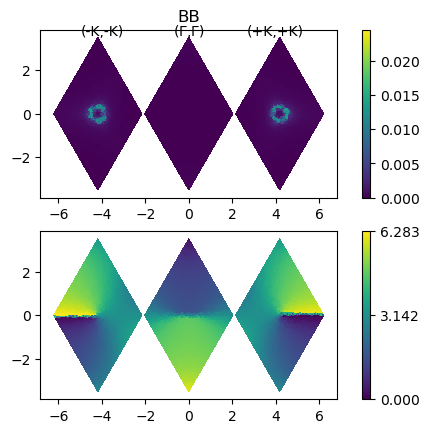

In [78]:
fig,axs=plt.subplots(2,1)

s1,s2=0,1
a1,a2=1,1
di=0

vmin,vmax=np.abs(ave[:,:,s1,a1,:,s2,a2]).min(),np.abs(ave[:,:,s1,a1,:,s2,a2]).max()
for i in range(3):
    im0=axs[0].tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,(i+di)%3,s1,a1,i,s2,a2]),vmin=vmin,vmax=vmax)

    im1=axs[1].tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,(i+di)%3,s1,a1,i,s2,a2])% (2*np.pi),vmin=0,vmax=2*np.pi)

cbar0 = fig.colorbar(im0, ax=axs[0])
cbar1 = fig.colorbar(im1, ax=axs[1],ticks=[0,np.pi,np.pi*2])
    
[ax.set_aspect('equal') for ax in axs]

axs[0].set_title(f'{sublattice(a1)}{sublattice(a2)}')
for i,x in zip(range(-1,2),[-4,0,4]):
    axs[0].text(x,3.8,f'({valley((i+di)%3)},{valley((i%3))})',ha='center',va='center')

# [ax.set_ylim([-0.8,0.8]) for ax in axs]
# [ax.set_xlim([-5,-3.6]) for ax in axs]

In [80]:
params=Params(t=[0,-1,0],U=[0,3],h=.2,nu=[16,8],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='m')

                A1              A2              A3              B1              B2              B3
A1  0.0000+0.0000j  0.0780+0.0000j -0.1521-0.0000j -0.7417+0.0000j  0.3592+0.0000j  0.3593+0.0000j
A2  0.0780-0.0000j  0.0000+0.0000j  0.0780+0.0000j  0.3679+0.0000j -0.7417+0.0000j  0.3592+0.0000j
A3 -0.1521+0.0000j  0.0780-0.0000j  0.0000+0.0000j  0.3251+0.0000j  0.3679+0.0000j -0.7417+0.0000j
B1 -0.7417+0.0000j  0.3679-0.0000j  0.3251-0.0000j  0.0000+0.0000j -0.0780-0.0000j  0.1521+0.0000j
B2  0.3592-0.0000j -0.7417+0.0000j  0.3679-0.0000j -0.0780+0.0000j  0.0000+0.0000j -0.0780-0.0000j
B3  0.3593-0.0000j  0.3592+0.0000j -0.7417-0.0000j  0.1521-0.0000j -0.0780+0.0000j -0.0000+0.0000j
Iteration 0:	
Gap(meV)=0.3951823143779356
E(meV):5.1985655933187696
                A1              A2              A3              B1              B2              B3
A1  0.0133+0.0000j  0.0138+0.0000j -0.0047-0.0000j -0.3125+0.0000j  0.1600-0.0000j  0.0590+0.0000j
A2  0.0138-0.0000j  0.0133+0.0000j  0.013

In [88]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1 -0.0003+0.0000j  0.0010+0.0000j -0.0009-0.0000j -0.0157-0.0000j   
A2  0.0010-0.0000j -0.0003+0.0000j  0.0010+0.0000j  0.0042+0.0000j   
A3 -0.0009+0.0000j  0.0010+0.0000j -0.0003+0.0000j  0.0003-0.0000j   
B1 -0.0157+0.0000j  0.0042-0.0000j  0.0003+0.0000j  0.0003+0.0000j   
B2  0.0079-0.0000j -0.0157+0.0000j  0.0042-0.0000j -0.0010+0.0000j   
B3  0.0048-0.0000j  0.0079+0.0000j -0.0157-0.0000j  0.0009-0.0000j   

                B2              B3  
A1  0.0079+0.0000j  0.0048+0.0000j  
A2 -0.0157-0.0000j  0.0079+0.0000j  
A3  0.0042+0.0000j -0.0157+0.0000j  
B1 -0.0010-0.0000j  0.0009+0.0000j  
B2  0.0003+0.0000j -0.0010-0.0000j  
B3 -0.0010+0.0000j  0.0003+0.0000j

In [89]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),4),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1              A2              A3              B1  \
A1 -0.0000+0.0000j  0.0000+0.0014j -0.0000+0.0009j -0.0000+0.0092j   
A2  0.0000-0.0014j -0.0000+0.0000j  0.0000+0.0014j  0.0000-0.0028j   
A3 -0.0000-0.0009j  0.0000-0.0014j -0.0000+0.0000j  0.0000-0.0021j   
B1 -0.0000-0.0092j  0.0000+0.0028j  0.0000+0.0021j -0.0000+0.0000j   
B2  0.0000+0.0059j -0.0000-0.0092j  0.0000+0.0028j -0.0000+0.0014j   
B3 -0.0000-0.0010j -0.0000+0.0059j -0.0000-0.0092j  0.0000+0.0009j   

                B2              B3  
A1  0.0000-0.0059j -0.0000+0.0010j  
A2 -0.0000+0.0092j  0.0000-0.0059j  
A3 -0.0000-0.0028j -0.0000+0.0092j  
B1 -0.0000-0.0014j  0.0000-0.0009j  
B2 -0.0000+0.0000j -0.0000-0.0014j  
B3 -0.0000+0.0014j  0.0000+0.0000j

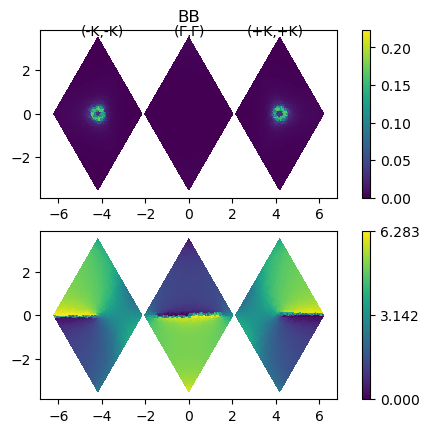

In [87]:
fig,axs=plt.subplots(2,1)

s1,s2=0,1
a1,a2=1,1
di=0

vmin,vmax=np.abs(ave[:,:,s1,a1,:,s2,a2]).min(),np.abs(ave[:,:,s1,a1,:,s2,a2]).max()
for i in range(3):
    im0=axs[0].tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,(i+di)%3,s1,a1,i,s2,a2]),vmin=vmin,vmax=vmax)

    im1=axs[1].tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,(i+di)%3,s1,a1,i,s2,a2])% (2*np.pi),vmin=0,vmax=2*np.pi)

cbar0 = fig.colorbar(im0, ax=axs[0])
cbar1 = fig.colorbar(im1, ax=axs[1],ticks=[0,np.pi,np.pi*2])
    
[ax.set_aspect('equal') for ax in axs]

axs[0].set_title(f'{sublattice(a1)}{sublattice(a2)}')
for i,x in zip(range(-1,2),[-4,0,4]):
    axs[0].text(x,3.8,f'({valley((i+di)%3)},{valley((i%3))})',ha='center',va='center')

# [ax.set_ylim([-0.8,0.8]) for ax in axs]
# [ax.set_xlim([-5,-3.6]) for ax in axs]

In [287]:
spin_mat=params._generate_spin_mat(ave)

In [289]:
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),10),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1                          A2                  A3  \
A1  0.000000-0.000000j -0.000000e+00-0.000000e+00j -0.000000+0.000000j   
A2 -0.000000+0.000000j  0.000000e+00+0.000000e+00j -0.000000-0.000000j   
A3 -0.000000-0.000000j -0.000000e+00+0.000000e+00j  0.000000+0.000000j   
B1  0.000000+0.000000j -0.000000e+00+6.202000e-07j -0.000000+0.000001j   
B2 -0.000000-0.000003j  0.000000e+00+0.000000e+00j  0.000000-0.000001j   
B3  0.000000-0.000002j -0.000000e+00+5.953300e-06j -0.000000+0.000000j   

                            B1                  B2                  B3  
A1  0.000000e+00-0.000000e+00j -0.000000+0.000003j  0.000000+0.000002j  
A2 -0.000000e+00-6.202000e-07j  0.000000-0.000000j -0.000000-0.000006j  
A3 -0.000000e+00-1.144700e-06j  0.000000+0.000001j -0.000000-0.000000j  
B1 -0.000000e+00+0.000000e+00j  0.000000+0.000000j  0.000000-0.000000j  
B2  0.000000e+00-0.000000e+00j -0.000000-0.000000j -0.000000+0.000000j  
B3  0.000000e+00+0.000000e+00j -0.000000-0.000000j -0.000000-0.000000j

did not find intervalley, will converge to AF

In [286]:

params=Params(t=[0,-1,0],U=[0,3],h=.1,nu=[14,7],n=27)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

S0: 0.000 0.000 0.000 0.000 0.000 0.000
S1: 0.000 0.000 0.000 0.000 0.000 0.000
S2: -0.000 0.001 -0.001 0.000 0.001 -0.001
S3: 0.000 0.000 0.000 0.000 0.000 0.000
Iteration 0:	
Gap(meV)=0.06242736358454901
E(meV):4.611037562454529
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: -0.000 -0.000 -0.000 -0.000 0.000 0.000
S2: -0.000 0.000 -0.000 -0.000 0.000 -0.000
S3: -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
Iteration 1:	
Gap(meV)=0.06242745490212975
E(meV):4.611036914178972
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: -0.000 0.000 0.000 -0.000 -0.000 0.000
S2: 0.000 0.000 -0.000 -0.000 0.000 -0.000
S3: -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
Iteration 2:	
Gap(meV)=0.06242748595679792
E(meV):4.6110366938879395
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.000 0.000 0.000 -0.000 -0.000 -0.000
S2: 0.000 0.000 -0.000 -0.000 0.000 -0.000
S3: -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
Iteration 3:	
Gap(meV)=0.06242749651236501
E(meV):4.611036619030018
S0: 1.000 1.000 1.000 1.000 1.000 1.000
S1: 0.

(-6.801797427772184, 6.801797427772184, -3.800341525062173, 3.800341525062173)

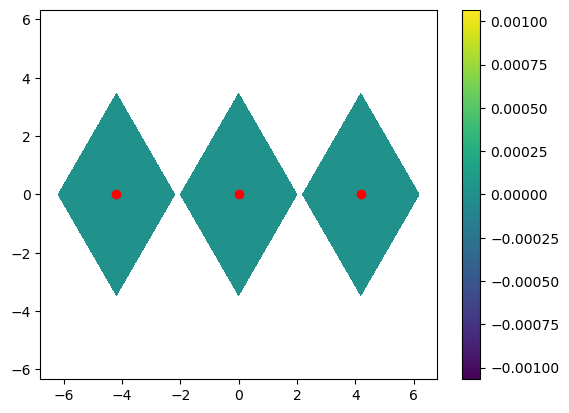

In [276]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+0)%3,s1,a1,i,s2,a2].__abs__(),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-6.801797427772184, 6.801797427772184, -3.800341525062173, 3.800341525062173)

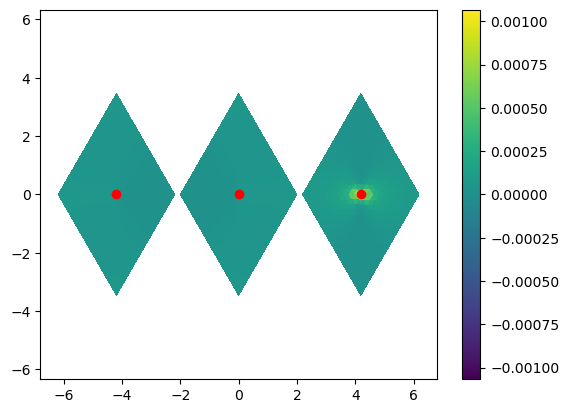

In [277]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,ave[:,(i+1)%3,s1,a1,i,s2,a2].__abs__(),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

(-6.801797427772184, 6.801797427772184, -3.800341525062173, 3.800341525062173)

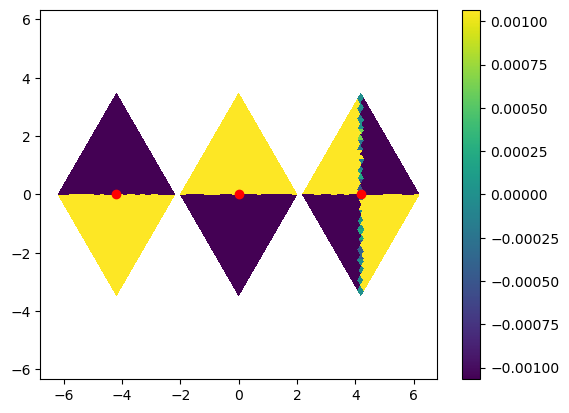

In [278]:
s1,s2=0,1
a1,a2=0,0
vmin,vmax=ave[:,:,s1,a1,:,s2,a2].min().real,ave[:,:,s1,a1,:,s2,a2].max().real
for i in range(3):
    plt.tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,(i+1)%3,s1,a1,i,s2,a2]),vmin=vmin,vmax=vmax)
# plt.tripcolor(*k_pts.T,ave_pts.real)
plt.colorbar()
plt.scatter(*params.q.T,color='r')
plt.axis('equal')

## inter p

In [17]:
params=Params(t=[0,-1,-0],U=[2,0.6],h=.6,nu=[18,9],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='m',thres=1e-10)

Energy resolution: 0.05771592768872468
                A1              A2              A3              B1              B2              B3
A1  6.6335+0.0000j -3.0870+0.0000j -0.2200-0.0000j  0.0000+0.0000j -0.0000+1.1280j -0.0000+1.7640j
A2 -3.0870-0.0000j -3.3167+0.0000j  5.5043-0.0000j -0.0000-1.1280j -0.0000+0.0000j  0.0000-2.2561j
A3 -0.2200-0.0000j  5.5043+0.0000j -3.3167-0.0000j -0.0000-1.7640j  0.0000+2.2561j -0.0000-0.0000j
B1  0.0000+0.0000j -0.0000+1.1280j -0.0000+1.7640j -6.6335+0.0000j  2.4173-0.0000j  2.4720+0.0000j
B2 -0.0000-1.1280j -0.0000+0.0000j  0.0000-2.2561j  2.4173-0.0000j  3.3167+0.0000j -5.5043+0.0000j
B3 -0.0000-1.7640j  0.0000+2.2561j -0.0000-0.0000j  2.4720-0.0000j -5.5043-0.0000j  3.3167-0.0000j
Iteration 0:	
Gap(meV)=8.00535064412864
E(meV):1.251014277808777
                A1              A2              A3              B1              B2              B3
A1  0.9751+0.0000j  0.0009+0.0005j  0.0003-0.0000j -0.0013-0.0000j -0.0224+0.0193j -0.0010+0.0002j
A2  0

In [5]:
params=Params(t=[0,-1,-0.5],U=[1,0],h=0.6,nu=[18,9],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10,iter_max=10000)

Energy resolution: 0.05771592768872468
S0: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S1: 6.6335 -3.3167 -3.3167 -6.6335 3.3167 3.3167
S2: 0.0000 5.7448 -5.7448 -0.0000 5.7448 -5.7448
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=3.864556930686409
E(meV):-1.3994444418642227
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.8977 -0.4488 -0.4488 -0.8977 0.4488 0.4488
S2: -0.0000 0.7774 -0.7774 0.0000 0.7774 -0.7774
S3: -0.1408 -0.1408 -0.1408 -0.1408 -0.1408 -0.1408
Iteration 1:	
Gap(meV)=8.243511540051429e-08
E(meV):-2.846980987307395
S0: 1.0002 0.9999 0.9999 1.0002 0.9999 0.9999
S1: 0.2224 -0.1112 -0.1112 -0.2224 0.1112 0.1112
S2: -0.0000 0.1928 -0.1928 0.0000 0.1928 -0.1928
S3: -0.2409 -0.2406 -0.2406 -0.2409 -0.2406 -0.2406
Iteration 2:	
Gap(meV)=1.0227288698150261e-05
E(meV):-2.9169102621297367
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.0599 -0.0300 -0.0300 -0.0599 0.0300 0.0300
S2: -0.0000 0.0521 -0.0521 0.0000 0.0521 -0.0521
S3: -0.2657 -0.2656 -0.

array([[-6.23942455, -4.76057545, -0.23942455, ...,  2.73942455,
         2.73942455,  2.73942455],
       [-6.23539739, -4.7565483 , -0.23741122, ...,  2.68349116,
         2.79239303,  2.79334461],
       [-6.22332607, -4.74447697, -0.23137936, ...,  2.62576967,
         2.84144993,  2.84503424],
       ...,
       [-6.21796591, -4.73911682, -0.22870244, ...,  2.60453152,
         2.8582272 ,  2.8582272 ],
       [-6.23405539, -4.75520629, -0.23674042, ...,  2.67395536,
         2.80086709,  2.80086709],
       [-6.23942455, -4.76057545, -0.23942455, ...,  2.73942455,
         2.73942455,  2.73942455]])

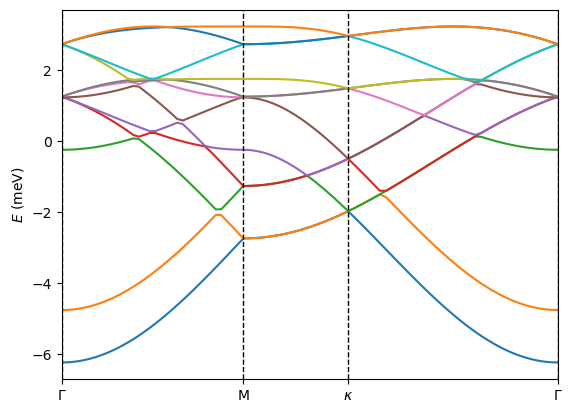

In [7]:
params.plot_dispersion(ave)

In [63]:
params=Params(t=[0,-1,-0.5],U=[10,0],h=0.6,nu=[18,9],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10,iter_max=1000)

Energy resolution: 0.05771592768872468
S0: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S1: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S2: 0.0000 0.0000 -0.0000 -0.0000 11.4895 -11.4895
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=3.885780586188048e-16
E(meV):1.0050244514828959
S0: 1.0175 1.0156 1.0161 0.9495 1.0007 1.0007
S1: -0.0000 0.0000 -0.0000 -0.0000 -0.0000 -0.0000
S2: 0.0000 0.0001 -0.0001 -0.0000 0.9988 -0.9988
S3: -0.3663 -0.3644 -0.3649 -0.2839 -0.0102 -0.0102
Iteration 1:	
Gap(meV)=7.838396678394588e-07
E(meV):-0.8641263828340346
S0: 1.0059 1.0066 1.0063 1.0231 0.9791 0.9791
S1: -0.0000 0.0000 -0.0000 -0.0000 0.0000 0.0000
S2: 0.0001 0.0004 -0.0005 0.0000 0.9001 -0.9001
S3: -0.8950 -0.8950 -0.8948 -0.9104 -0.0485 -0.0485
Iteration 2:	
Gap(meV)=4.142809815467758
E(meV):-1.1198082389927007
S0: 1.0076 1.0076 1.0076 1.0090 0.9840 0.9840
S1: -0.0000 0.0000 -0.0000 -0.0000 0.0000 0.0000
S2: 0.0001 0.0004 -0.0005 0.0000 0.9331 -0.9331
S3: -0.9757 -0.9757 -0.97

In [9]:
params=Params(t=[0,-1,-0.1],U=[10,1],h=0.6,nu=[18,9],n=69)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='m',thres=1e-10)

: 

: 

In [ ]:
params=Params(t=[0,-1,-.42],U=[4,0],h=.6,nu=[12,6],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

array([[-5.16253789, -2.49650491,  1.32849581, ...,  5.19211638,
         5.19211638,  5.19211638],
       [-5.15903132, -2.49318903,  1.28465658, ...,  5.14974736,
         5.23264038,  5.23337212],
       [-5.14852034, -2.48325109,  1.23677198, ...,  5.1064546 ,
         5.27054407,  5.27332829],
       ...,
       [-5.143853  , -2.47883889,  1.22350189, ...,  5.09063141,
         5.28359438,  5.28359438],
       [-5.15786279, -2.4920841 ,  1.27806831, ...,  5.14256566,
         5.23916149,  5.23916149],
       [-5.16253789, -2.49650491,  1.32849581, ...,  5.19211638,
         5.19211638,  5.19211638]])

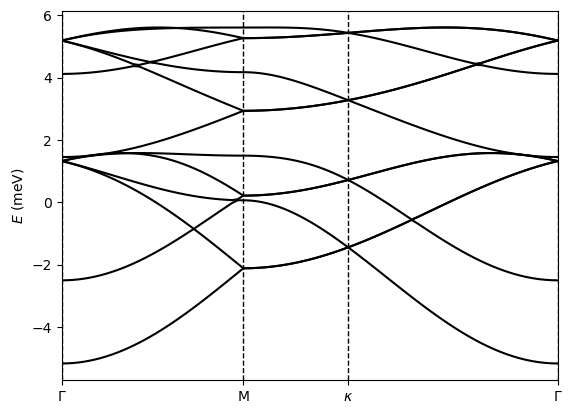

In [4]:
params.plot_dispersion(ave)

In [ ]:
params.plot_dispersion()

In [ ]:
params.plot_dispersion(ave)

In [226]:
# params=Params(t=[0,-1,-0.75],U=[5,0],h=0.6,nu=[18,9],n=69)
# params=Params(t=[0,-1,-0.5],U=[5,0],h=0.6,nu=[18,9],n=33)
# gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

params=Params(t=[0,-1,-.0],U=[0,1],h=.6,nu=[14,7],n=9)
# params=Params(t=[0,-1,-.4],U=[2,0],h=.6,nu=[18,9],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='m',thres=1e-10,iter_max=3)

                A1              A2              A3              B1              B2              B3
A1  0.0002+0.0000j -0.0001+2.2347j -0.0001-1.7213j  6.4590+0.0000j -2.7675+0.0000j -1.6110-0.0000j
A2 -0.0001-2.2347j -0.0001+0.0000j  0.0002-1.1173j -2.7675-0.0000j -3.2295+0.0000j  5.5350-0.0000j
A3 -0.0001+1.7213j  0.0002+1.1173j -0.0001+0.0000j -1.6110+0.0000j  5.5350-0.0000j -3.2295+0.0000j
B1  6.4590+0.0000j -2.7675+0.0000j -1.6110-0.0000j  0.0002+0.0000j -0.0001-1.1173j -0.0001+3.4427j
B2 -2.7675-0.0000j -3.2295+0.0000j  5.5350-0.0000j -0.0001+1.1173j -0.0001+0.0000j  0.0002-1.1173j
B3 -1.6110+0.0000j  5.5350-0.0000j -3.2295+0.0000j -0.0001-3.4427j  0.0002+1.1173j -0.0001+0.0000j
Iteration 0:	
Gap(meV)=0.12106350495508664
E(meV):1.6067328887619572
                A1              A2              A3              B1              B2              B3
A1  0.0000+0.0000j -0.0000+0.0000j -0.0000+0.0000j  0.5720-0.0000j -0.2227-0.4053j  0.0228-0.0417j
A2 -0.0000-0.0000j  0.0000+0.0000j -0.00

In [202]:
FF=params._generate_Fock(ave)

In [186]:
FF.shape

(81, 12, 12)

In [187]:
params.delta[0,1]

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]], dtype=int8)

In [212]:
pd.DataFrame(ave[32].reshape((12,12,))[4:8,8:]/params.U[1]/(params.k.shape[0]*params.q.shape[0]),columns=[f'{a}{s}' for s in '↑↓' for a in 'AB' ], index=[f'{a}{s}' for s in '↑↓' for a in 'AB' ])

A↑                  B↑        A↓        B↓
A↑  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j
B↑  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j
A↓ -0.000000-0.265795j  0.265795+0.000000j  0.0+0.0j  0.0+0.0j
B↓  0.265795+0.000000j -0.000000+0.265795j  0.0+0.0j  0.0+0.0j

In [213]:
pd.DataFrame(ave[59].reshape((12,12,))[4:8,8:]/params.U[1]/(params.k.shape[0]*params.q.shape[0]),columns=[f'{a}{s}' for s in '↑↓' for a in 'AB' ], index=[f'{a}{s}' for s in '↑↓' for a in 'AB' ])

A↑                  B↑        A↓        B↓
A↑  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j
B↑  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j
A↓ -0.230185+0.132897j  0.265795+0.000000j  0.0+0.0j  0.0+0.0j
B↓  0.265795+0.000000j -0.230185-0.132897j  0.0+0.0j  0.0+0.0j

In [214]:
pd.DataFrame(ave[29].reshape((12,12,))[4:8,8:]/params.U[1]/(params.k.shape[0]*params.q.shape[0]),columns=[f'{a}{s}' for s in '↑↓' for a in 'AB' ], index=[f'{a}{s}' for s in '↑↓' for a in 'AB' ])

A↑                  B↑        A↓        B↓
A↑  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j
B↑  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j
A↓  0.230185+0.132897j  0.265795+0.000000j  0.0+0.0j  0.0+0.0j
B↓  0.265795+0.000000j  0.230185-0.132897j  0.0+0.0j  0.0+0.0j

In [84]:
params.neighbor_list[1] @ params.high_symm['kappa']

array([ 0.00000000e+00, -1.77635684e-15, -2.09439510e+00])

In [85]:
params.neighbor_list[1]

array([[-0.       , -0.       ],
       [-0.5      , -0.8660254],
       [ 0.5      , -0.8660254]])

In [86]:
params.high_symm['kappa']

array([-2.0943951 ,  1.20919958])

In [106]:
n_idx=0
np.sum([ave[k_idx,2,0,0,1,1,1]/params.U[1]/(params.k.shape[0]*params.q.shape[0]) * np.exp(1j* params.k[k_idx]@params.neighbor_list[1][n_idx]) for k_idx in range(params.k.shape[0])])

(0.0001104403713259039+1.1102230246251565e-16j)

In [141]:
np.linalg.norm(params.neighbor_list[1]-AB,axis=1)

array([0.57735027, 0.57735027, 0.57735027])

In [138]:
AB=(params.neighbor_list[1][1]+params.neighbor_list[1][2])/3

In [144]:
n_idx=0
np.sum([ave[k_idx,2,0,0,1,1,1]/params.U[1]/(params.k.shape[0]*params.q.shape[0]) * np.exp(1j* params.k[k_idx]@(params.neighbor_list[1][n_idx]-AB)) for k_idx in range(params.k.shape[0])])

(-0.6819082833189577+5.551115123125783e-17j)

In [222]:
s3=np.array([np.sum([ave[k_idx,2,0,0,1,1,1]/params.U[1]/(params.k.shape[0]*params.q.shape[0]) * np.exp(1j* params.k[k_idx]@(params.neighbor_list[1][n_idx]-AB)) for k_idx in range(params.k.shape[0])]) for n_idx in range(3)])

In [211]:
s3

array([3.22950004+0.00000000e+00j, 2.7674799 +0.00000000e+00j,
       2.7674799 -1.11022302e-16j])

In [215]:
s1=np.array([np.exp(1j*params.q[1]@(params.neighbor_list[1][n_idx])) for n_idx in range(3)])

In [220]:
s2=np.array([np.exp(-1j*params.k[59]@(params.neighbor_list[1][n_idx])) for n_idx in range(3)])

In [162]:
np.angle(0.893633+0.448799j)*180/np.pi

26.666648191327727

In [164]:
np.angle(0.973045-0.230616j)*180/np.pi

-13.333338829548097

In [169]:
np.angle(s1)/np.pi*180

array([-1.00097117e-13, -1.20000000e+02,  1.20000000e+02])

In [172]:
s2.sum()

(2.83972238148306-0.012432561284418275j)

In [217]:
pd.DataFrame([s1,s2,s3],index=['s1','s2','s3'])

0                   1                   2
s1  1.0000+0.0000j -0.500000-0.866025j -0.500000+0.866025j
s2  1.0000+0.0000j  0.766044-0.642788j  0.766044-0.642788j
s3  3.2295+0.0000j  2.767480+0.000000j  2.767480-0.000000j

In [219]:
pd.DataFrame([s1,s2,s3],index=['s1','s2','s3'])

0                   1                   2
s1  1.0000+0.0000j -0.500000-0.866025j -0.500000+0.866025j
s2  1.0000+0.0000j  0.766044+0.642788j  1.000000-0.000000j
s3  3.2295+0.0000j  2.767480+0.000000j  2.767480-0.000000j

In [223]:
pd.DataFrame([s1,s2,s3],index=['s1','s2','s3'])

0                   1                   2
s1  1.000000+0.000000j -0.500000-0.866025j -0.500000+0.866025j
s2  1.000000+0.000000j  1.000000+0.000000j  0.766044+0.642788j
s3  3.070893+0.000000j  3.070893+0.000000j  3.070893-0.000000j

In [152]:
np.sum(s1*s2*s3)

(-1.93675260456981+0.00855427442986395j)

In [155]:
np.sum(s1*s2*s3)

(-1.9366744670087588+0.008449317470799161j)

In [158]:
np.sum(s1*s2*s3)

(-1.9368044311822834+0.008434126837534972j)

In [198]:
pd.DataFrame(FF[32][:4,4:8],columns=[f'{a}{s}' for s in '↑↓' for a in 'AB' ], index=[f'{a}{s}' for s in '↑↓' for a in 'AB' ])

A↑                  B↑                  A↓  \
A↑  0.000000-0.000000j  0.000000-0.000000j  0.000000+0.000000j   
B↑  0.000000-0.000000j  0.000000-0.000000j -1.109487-1.778902j   
A↓  0.000000+0.000000j -1.109487+1.778902j  0.000000-0.000000j   
B↓ -1.109487-1.778902j  0.000000-0.000000j  0.000000-0.000000j   

                    B↓  
A↑ -1.109487+1.778902j  
B↑  0.000000+0.000000j  
A↓  0.000000-0.000000j  
B↓  0.000000-0.000000j

In [199]:
pd.DataFrame(FF[59][:4,4:8],columns=[f'{a}{s}' for s in '↑↓' for a in 'AB' ], index=[f'{a}{s}' for s in '↑↓' for a in 'AB' ])

A↑                  B↑                  A↓  \
A↑  0.000000-0.000000j  0.000000-0.000000j  0.000000+0.000000j   
B↑  0.000000-0.000000j  0.000000-0.000000j  0.754820+1.450174j   
A↓  0.000000+0.000000j  0.754820-1.450174j  0.000000-0.000000j   
B↓  0.754820+1.450174j  0.000000-0.000000j  0.000000-0.000000j   

                    B↓  
A↑  0.754820-1.450174j  
B↑  0.000000+0.000000j  
A↓  0.000000-0.000000j  
B↓  0.000000-0.000000j

In [71]:
pd.DataFrame(FF[29][:4,4:8],columns=[f'{a}{s}' for s in '↑↓' for a in 'AB' ], index=[f'{a}{s}' for s in '↑↓' for a in 'AB' ])

A↑        B↑                  A↓        B↓
A↑  0.000000-0.000000j  0.0-0.0j  0.000000-0.000000j  0.0-0.0j
B↑  0.000000-0.000000j  0.0-0.0j  1.349734+0.491303j  0.0-0.0j
A↓  0.000000-0.000000j  0.0-0.0j  0.000000-0.000000j  0.0-0.0j
B↓  1.349734+0.491303j  0.0-0.0j  0.000000-0.000000j  0.0-0.0j

In [68]:
params.k[[32,59,29]]

array([[-5.55111512e-17, -8.06133051e-01],
       [-6.98131701e-01,  4.03066525e-01],
       [ 6.98131701e-01,  4.03066525e-01]])

In [455]:
params.k[59]

array([-0.6981317 ,  0.40306653])

In [207]:
np.angle(FF[29][4:8,8:])*180/np.pi

array([[  -0.        ,   -0.        ,   -0.        ,   -0.        ],
       [  -0.        ,   -0.        , -167.63861934,   -0.        ],
       [   0.        ,   -0.        ,   -0.        ,   -0.        ],
       [-167.63861934,   -0.        ,   -0.        ,   -0.        ]])

In [208]:
np.angle(FF[59][4:8,8:])*180/np.pi

array([[  -0.        ,   -0.        ,   -0.        ,   -0.        ],
       [  -0.        ,   -0.        , -167.63861934,   -0.        ],
       [   0.        ,   -0.        ,   -0.        ,   -0.        ],
       [-167.63861934,   -0.        ,   -0.        ,   -0.        ]])

In [209]:
np.angle(FF[32][4:8,8:])*180/np.pi

array([[ -0.        ,  -0.        ,  -0.        ,  -0.        ],
       [ -0.        ,  -0.        , 154.53111023,  -0.        ],
       [  0.        ,  -0.        ,  -0.        ,  -0.        ],
       [154.53111023,  -0.        ,  -0.        ,  -0.        ]])

In [ ]:
## ??? where does this come from?

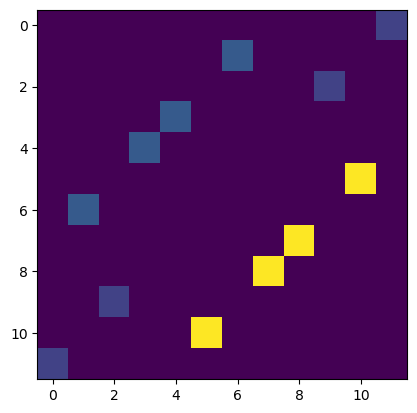

In [204]:
plt.imshow(FF[29].__abs__())

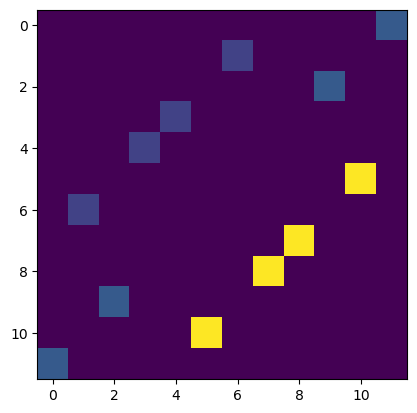

In [205]:
plt.imshow(FF[59].__abs__())

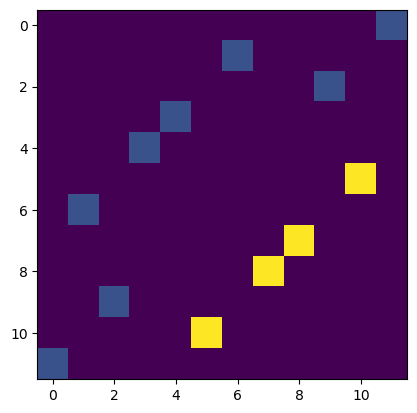

In [206]:
plt.imshow(FF[32].__abs__())

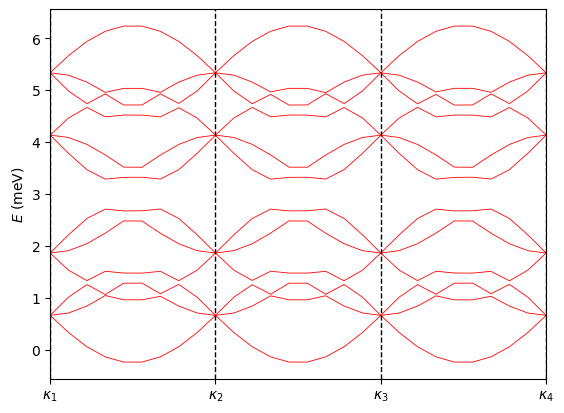

In [227]:
fig,ax=plt.subplots()
# params.plot_dispersion(ax=ax,color='k')
en_list=params.plot_dispersion(ave,ax=ax,color='r',line='K3',lw=0.6,ls='-',marker='')
# ax.set_ylim([1,3])

In [184]:
np.where(np.abs(ave)==np.abs(ave).max())

(array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 51,
        51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1]),
 array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 1]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 0]),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))

In [332]:
ave[30][0,0,0,0,0,1].__abs__()

0.0

In [257]:
ave[49][0,0,0,0,0,1].__abs__()

0.0

In [344]:
np.linalg.norm(params.k-np.array([0,0]),axis=1).argsort()

array([40, 39, 41, 50, 30, 49, 31, 51, 29, 48, 32, 59, 21, 38, 42, 60, 20,
       58, 22, 52, 28, 47, 61, 33, 19, 11, 23, 69, 57, 68, 12, 43, 37, 70,
       10, 67, 13, 18, 62, 56, 24,  2, 78, 53, 27, 46, 34, 71,  9, 79,  1,
       14, 66, 77,  3, 36, 44,  0, 80,  4, 76, 25, 65, 15, 55, 45, 35,  5,
       75, 64, 16, 54, 26, 74,  6, 17, 63, 73,  7, 72,  8])

In [387]:
np.linalg.norm(params.k-rotation(60)@params.k[28],axis=1).argsort()

array([57, 47, 48, 58, 56, 67, 66, 46, 38, 49, 68, 65, 76, 37, 39, 59, 55,
       77, 75, 45, 28, 36, 69, 29, 50, 64, 40, 78, 74, 27, 60, 54, 30, 41,
       79, 19, 73, 51, 31, 18, 70, 63, 20, 61, 21, 80, 42, 72, 32,  9, 10,
       71, 52, 11, 22, 62, 12,  0, 33, 43, 23,  1, 53, 13,  2,  3, 34, 24,
       44, 14,  4, 25, 15, 35,  5, 16, 26,  6, 17,  7,  8])

In [425]:
[np.linalg.norm(params.k-rotation(60*x)@params.k[29],axis=1).argsort()[0] for x in range(6)]

[29, 48, 59, 51, 32, 21]

In [426]:
# np.array([params.k[idx] for idx in [39, 41, 50, 30, 49, 31]])
# np.array([params.k[idx] for idx in [ 30,39,49, 50, 41, 31]])
zz=np.array([params.k[idx] for idx in [29, 48, 59, 51, 32, 21]])

In [427]:
zz

array([[ 6.98131701e-01,  4.03066525e-01],
       [ 5.55111512e-17,  8.06133051e-01],
       [-6.98131701e-01,  4.03066525e-01],
       [-6.98131701e-01, -4.03066525e-01],
       [-5.55111512e-17, -8.06133051e-01],
       [ 6.98131701e-01, -4.03066525e-01]])

In [428]:
np.linalg.norm(zz,axis=1)

array([0.80613305, 0.80613305, 0.80613305, 0.80613305, 0.80613305,
       0.80613305])

In [429]:
params.k[28]

array([0.93084227, 0.80613305])

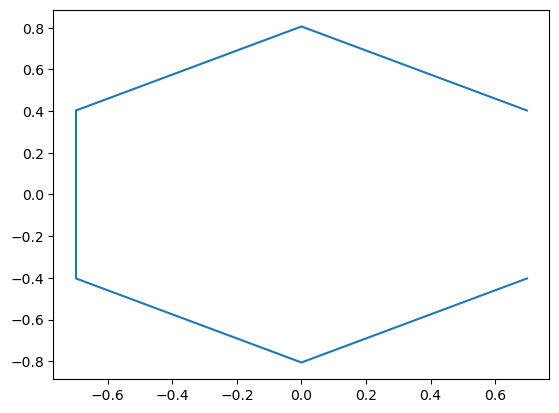

In [430]:
plt.plot(*zz.T)

In [333]:
np.round(ave[30].reshape((12,12,)),4)

array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,
        -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,
        -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],


In [403]:
ave[28][2,0,:,1,1,:]

array([[0.63620396+0.j        , 0.48092499+0.41649326j],
       [0.48092499+0.41649326j, 0.09088628+0.62967862j]])

In [410]:
np.angle(ave[28][2,0,:,1,1,:])/np.pi*180

array([[ 0.        , 40.89339465],
       [40.89339465, 81.7867893 ]])

In [404]:
ave[69][2,0,:,1,1,:]

array([[ 0.63620396+0.j        , -0.60115624+0.20824663j],
       [-0.60115624+0.20824663j,  0.49987454-0.39354914j]])

In [411]:
np.angle(ave[69][2,0,:,1,1,:])/np.pi*180

array([[  0.        , 160.89339465],
       [160.89339465, -38.2132107 ]])

In [405]:
ave[23][2,0,:,1,1,:]

array([[ 0.63620396+0.j        ,  0.12023125-0.62473989j],
       [ 0.12023125-0.62473989j, -0.59076082-0.23612948j]])

In [412]:
np.angle(ave[23][2,0,:,1,1,:])/np.pi*180

array([[   0.        ,  -79.10660535],
       [ -79.10660535, -158.2132107 ]])

In [271]:
ave[41][1,0,:,2,1,:][0,0]

(16.895369668093085+29.263638677795324j)

In [337]:
np.round(ave[49].reshape((12,12,)),2)

array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,
        -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,
        -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],


In [260]:
np.round(ave[41].reshape((12,12,)),2)

array([[  0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ],
       [  0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ],
       [  0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ],
       [  0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ],
       [  0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,   0.   +0.j  ,
          0.   +0.j  ,   0.   +0.j  ,  16.9 

(-2.0478529890066794,
 2.0478529890066794,
 -3.5469854233913587,
 3.5469854233913587)

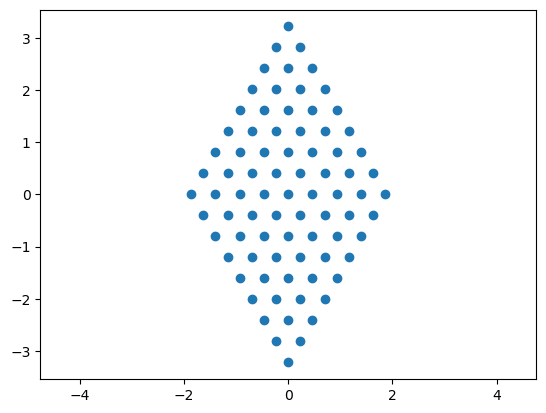

In [374]:
plt.scatter(*params.k.T)
plt.axis('equal')

In [178]:
rotation= lambda x: np.array([[np.cos(np.deg2rad(x)),-np.sin(np.deg2rad(x))],[np.sin(np.deg2rad(x)),np.cos(np.deg2rad(x))]])

In [179]:
KK=np.array([rotation(60*x)@params.high_symm['kappa'] for x in range(6)])

In [435]:
en,wf=params.energy(ave*0,zz)

In [439]:
en[:,5]

array([0.92879527, 0.92879527, 0.92879527, 0.92879527, 0.92879527,
       0.92879527])

In [440]:
en[:,7]

array([1.09687584, 1.09687584, 1.09687584, 1.09687584, 1.09687584,
       1.09687584])

In [502]:
expk=lambda x: np.sum([np.exp(-1j*(x[0]*n[0]+x[1]*n[1])) for n in params.neighbor_list[1]],axis=0)

In [503]:
expk(np.array([1,0]))

(2.7551651237807455-3.3306690738754696e-16j)

In [507]:
(expk(rotation(120)@np.array([1,0])))

(2.417884867758512+1.3208965234120997j)

In [498]:
x,y=10*np.linspace(-1,1),10*np.linspace(-1,1)
X,Y=np.meshgrid(x,y)
z=np.sum([np.exp(-1j*(X*n[0]+Y*n[1])) for n in params.neighbor_list[1]],axis=0)

(-10.204081632653061,
 10.204081632653061,
 -10.204081632653061,
 10.204081632653061)

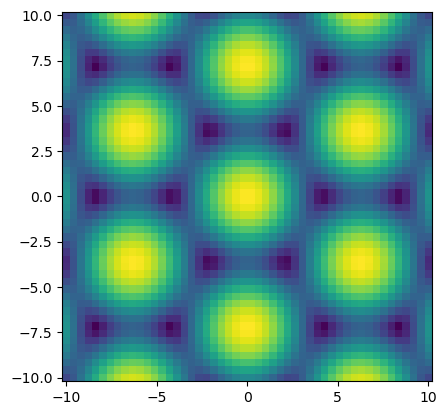

In [501]:
plt.pcolormesh(x,y,np.abs(z))
plt.axis('square')

In [493]:
np.array(z).shape

(50, 50)

array([[-6.6       , -5.4       , -0.6       , ...,  2.1       ,
         2.1       ,  2.1       ],
       [-6.59597285, -5.39597285, -0.59798668, ...,  2.04406661,
         2.15296848,  2.15392006],
       [-6.58390152, -5.38390152, -0.59195481, ...,  1.98634513,
         2.20202538,  2.20560969],
       ...,
       [-6.57854136, -5.37854136, -0.58927789, ...,  1.96510697,
         2.21880265,  2.21880265],
       [-6.59463084, -5.39463084, -0.59731587, ...,  2.03453081,
         2.16144254,  2.16144254],
       [-6.6       , -5.4       , -0.6       , ...,  2.1       ,
         2.1       ,  2.1       ]])

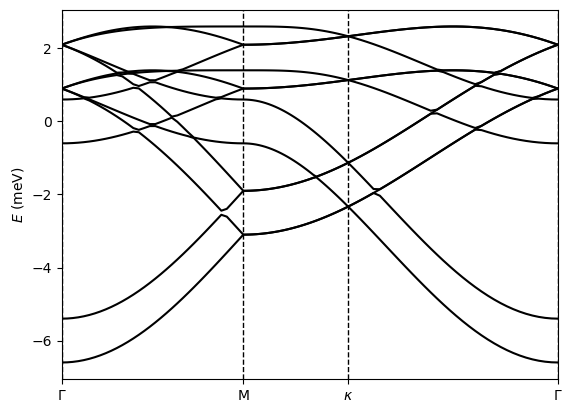

In [324]:
params.plot_dispersion()

array([[-5.89746067e+00, -1.65424736e+00, -9.63599408e-03, ...,
         6.50963599e+00,  6.57802547e+00,  6.57802547e+00],
       [-5.89348995e+00, -1.65095675e+00, -7.76788084e-03, ...,
         6.47990999e+00,  6.59100005e+00,  6.60495068e+00],
       [-5.88158809e+00, -1.64110847e+00, -2.17243280e-03, ...,
         6.42820050e+00,  6.62113849e+00,  6.64835839e+00],
       ...,
       [-5.87630335e+00, -1.63674284e+00,  3.10153558e-04, ...,
         6.41081840e+00,  6.63214874e+00,  6.66188420e+00],
       [-5.89216676e+00, -1.64986075e+00, -7.14550544e-03, ...,
         6.47252323e+00,  6.59490948e+00,  6.61139413e+00],
       [-5.89746067e+00, -1.65424736e+00, -9.63599408e-03, ...,
         6.50963599e+00,  6.57802547e+00,  6.57802547e+00]])

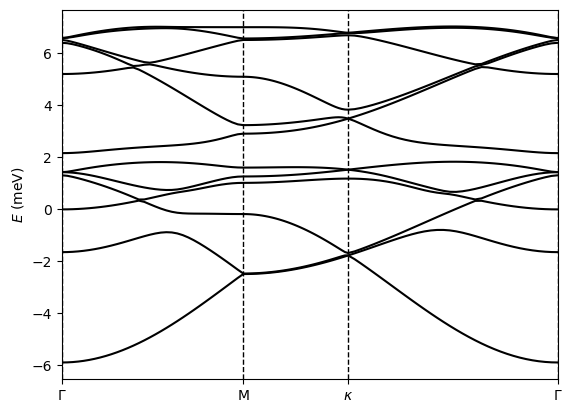

In [325]:
params.plot_dispersion(ave)

In [229]:
params=Params(t=[0,-1,-0.75],U=[5,0],h=0.6,nu=[18,9],n=33)
# params=Params(t=[0,-1,-0.5],U=[5,0],h=0.6,nu=[18,9],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o')

S0: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S1: 6.6335 -3.3167 -3.3167 -6.6335 3.3167 3.3167
S2: 0.0000 5.7448 -5.7448 -0.0000 5.7448 -5.7448
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=28.84545209117188
E(meV):-0.4838239351514427
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.9922 -0.4961 -0.4961 -0.9922 0.4961 0.4961
S2: 0.0000 0.8593 -0.8593 -0.0000 0.8593 -0.8593
S3: -0.0354 -0.0354 -0.0354 -0.0354 -0.0354 -0.0354
Iteration 1:	
Gap(meV)=1.593847798467848
E(meV):-1.5625439911471497
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.7990 -0.3995 -0.3995 -0.7990 0.3995 0.3995
S2: -0.0000 0.6920 -0.6920 0.0000 0.6920 -0.6920
S3: -0.1753 -0.1753 -0.1753 -0.1753 -0.1753 -0.1753
Iteration 2:	
Gap(meV)=0.8440105653064025
E(meV):-1.681814561173772
S0: 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
S1: 0.7186 -0.3593 -0.3593 -0.7186 0.3593 0.3593
S2: -0.0000 0.6223 -0.6223 0.0000 0.6223 -0.6223
S3: -0.2841 -0.2841 -0.2841 -0.2841 -0.2841 -0.2841
Iteration 3:	
Gap(

In [255]:
# params=Params(t=[0,-1,-0.75],U=[5,0],h=0.6,nu=[18,9],n=81)
params=Params(t=[0,-1,-0.2],U=[5,1],h=0.6,nu=[18,9],n=33)
gap_list,energy_list,spin_list,ave=params.iteration(print_opt='o',thres=1e-10)

S0: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
S1: 6.6335 -3.3167 -3.3167 -6.6335 3.3167 3.3167
S2: 0.0000 5.7448 -5.7448 -0.0000 5.7448 -5.7448
S3: 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
Iteration 0:	
Gap(meV)=25.77307032665003
E(meV):-2.46536337791279
S0: 1.0019 1.0043 1.0043 0.9984 0.9956 0.9956
S1: 0.9931 -0.5010 -0.5010 -0.9935 0.5005 0.5005
S2: -0.0000 0.8558 -0.8558 -0.0000 0.8554 -0.8554
S3: -0.0396 -0.0396 -0.0396 -0.0389 -0.0397 -0.0397
Iteration 1:	
Gap(meV)=2.3529050258336124
E(meV):-1.8093070465636767
S0: 1.0007 1.0020 1.0020 0.9994 0.9979 0.9979
S1: 0.8341 -0.4207 -0.4207 -0.8337 0.4208 0.4208
S2: -0.0000 0.7196 -0.7196 0.0000 0.7187 -0.7187
S3: -0.1937 -0.1940 -0.1940 -0.1929 -0.1942 -0.1942
Iteration 2:	
Gap(meV)=1.7220307577579712
E(meV):-1.541851430580319
S0: 1.0006 1.0016 1.0016 1.0008 0.9977 0.9977
S1: 0.7658 -0.3870 -0.3870 -0.7618 0.3859 0.3859
S2: -0.0000 0.6614 -0.6614 0.0000 0.6571 -0.6571
S3: -0.3141 -0.3132 -0.3132 -0.3226 -0.3219 -0.3219
Iteration 3:	
Gap(

KeyboardInterrupt: 

In [18]:
with open('results_nu(18,9)_t1(-1.0,-1.0,1)_t2(-0.75,-0.75,1)_U0(5.0,5.0,1)_U1(0.0,0.0,1)_h0.6_thres1e-10_n108.pkl','rb') as f:
    rs = pickle.load(f)

In [20]:
rs[(0,0,0,0)]['spin'][1]

A1                  A2                  A3  \
A1  0.422439+0.000000j  0.003102+0.021557j  0.003177+0.004017j   
A2  0.003102-0.021557j -0.211219+0.000000j -0.000858-0.039695j   
A3  0.003177-0.004017j -0.000858+0.039695j -0.211219+0.000000j   
B1  0.000000-0.000000j -0.005056-0.022585j  0.003467-0.004786j   
B2 -0.037145-0.006976j -0.000000+0.000000j  0.000000+0.062514j   
B3 -0.039989-0.008531j -0.000000+0.074705j  0.000000+0.000000j   

                    B1                  B2                  B3  
A1  0.000000+0.000000j -0.037145+0.006976j -0.039989+0.008531j  
A2 -0.005056+0.022585j -0.000000-0.000000j -0.000000-0.074705j  
A3  0.003467+0.004786j  0.000000-0.062514j  0.000000-0.000000j  
B1 -0.422439+0.000000j -0.038904+0.028433j  0.004543+0.007288j  
B2 -0.038904-0.028433j  0.211219+0.000000j  0.000858-0.039695j  
B3  0.004543-0.007288j  0.000858+0.039695j  0.211219+0.000000j

In [51]:
vmin

2.3094034451362265e-07

In [52]:
vmax

0.3487851895887268

In [55]:
np.sort(np.abs(ave[:,:,s1,a1,:,s2,a2]).flatten())

array([2.30940345e-07, 4.99458879e-07, 5.00210098e-07, ...,
       3.48785079e-01, 3.48785079e-01, 3.48785190e-01])

In [56]:
np.where(np.abs(ave[:,:,s1,a1,:,s2,a2])==vmax)

(array([1054]), array([0]), array([2]))

In [62]:
np.round(ave[1054,:,s1,a1,:,s2,a2],4)

array([[ 0.0313-0.j,  0.0825-0.j,  0.3488+0.j],
       [ 0.2528-0.j,  0.0235-0.j, -0.0401-0.j],
       [-0.0206-0.j,  0.1969+0.j, -0.0359-0.j]])

In [59]:
params.k[1054]

array([-1.90399555e+00,  8.88178420e-16])

In [66]:
np.max([np.abs(ave[:,i,s1,a1,(i+di)%3,s2,a2]) for i in range(3)])

0.06242432477343312

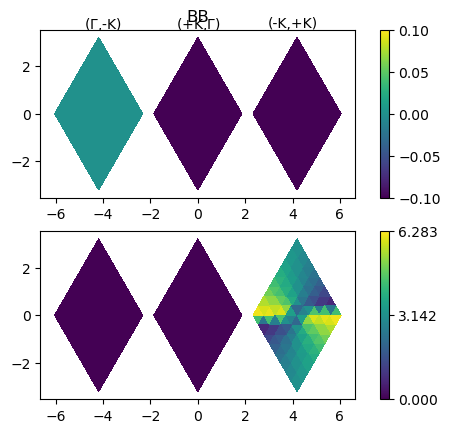

In [30]:
fig,axs=plt.subplots(2,1)

s1,s2=0,1
a1,a2=1,1
di=1

vmin,vmax=np.min([np.abs(ave[:,i,s1,a1,(i+di)%3,s2,a2]) for i in range(3)]),np.max([np.abs(ave[:,i,s1,a1,(i+di)%3,s2,a2]) for i in range(3)])
for i in range(3):
    im0=axs[0].tripcolor(*(params.k+params.q[i]).T,np.abs(ave[:,(i+di)%3,s1,a1,i,s2,a2]),vmin=vmin,vmax=vmax)

    im1=axs[1].tripcolor(*(params.k+params.q[i]).T,np.angle(ave[:,(i+di)%3,s1,a1,i,s2,a2])% (2*np.pi),vmin=0,vmax=2*np.pi)

cbar0 = fig.colorbar(im0, ax=axs[0])
cbar1 = fig.colorbar(im1, ax=axs[1],ticks=[0,np.pi,np.pi*2])
    
[ax.set_aspect('equal') for ax in axs]

axs[0].set_title(f'{sublattice(a1)}{sublattice(a2)}')
for i,x in zip(range(-1,2),[-4,0,4]):
    axs[0].text(x,3.8,f'({valley((i+di)%3)},{valley((i%3))})',ha='center',va='center')

# [ax.set_ylim([-0.8,0.8]) for ax in axs]
# [ax.set_xlim([-5,-3.6]) for ax in axs]

In [116]:
spin_mat=params._generate_spin_mat(ave)
pd.DataFrame(np.round(np.transpose(spin_mat[1],axes=(0,2,1,3)).reshape((2*3,2*3)),10),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1                  A2                  A3  \
A1 -0.535986+0.000000j  0.052055-0.000000j -0.009288-0.000000j   
A2  0.052055+0.000000j -0.535985+0.000000j  0.052055+0.000000j   
A3 -0.009288+0.000000j  0.052055-0.000000j -0.535987-0.000000j   
B1  0.000000+0.021069j  0.000001-0.004355j  0.000000+0.000649j   
B2 -0.000000+0.021068j -0.000000+0.021068j  0.000000-0.004354j   
B3  0.000000-0.004355j -0.000000+0.021071j  0.000000+0.021069j   

                    B1                  B2                  B3  
A1  0.000000-0.021069j -0.000000-0.021068j  0.000000+0.004355j  
A2  0.000001+0.004355j -0.000000-0.021068j -0.000000-0.021071j  
A3  0.000000-0.000649j  0.000000+0.004354j  0.000000-0.021069j  
B1  0.535994-0.000000j -0.052060-0.000000j  0.009288+0.000000j  
B2 -0.052060+0.000000j  0.535995+0.000000j -0.052057+0.000000j  
B3  0.009288-0.000000j -0.052057-0.000000j  0.535992+0.000000j

In [117]:
pd.DataFrame(np.round(np.transpose(spin_mat[2],axes=(0,2,1,3)).reshape((2*3,2*3)),10),index=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)],columns=[f'{alpha}{idx}' for alpha in 'AB' for idx in range(1,4)])

A1                  A2                  A3  \
A1  0.105346+0.000000j -0.010233-0.000001j  0.001825+0.000000j   
A2 -0.010233+0.000001j  0.105347+0.000000j -0.010230-0.000000j   
A3  0.001825-0.000000j -0.010230+0.000000j  0.105335-0.000000j   
B1  0.000000+0.107195j  0.000000-0.022156j -0.000000+0.003304j   
B2 -0.000001+0.107198j -0.000001+0.107200j -0.000000-0.022156j   
B3  0.000000-0.022155j  0.000000+0.107199j  0.000001+0.107200j   

                    B1                  B2                  B3  
A1  0.000000-0.107195j -0.000001-0.107198j  0.000000+0.022155j  
A2  0.000000+0.022156j -0.000001-0.107200j  0.000000-0.107199j  
A3 -0.000000-0.003304j -0.000000+0.022156j  0.000001-0.107200j  
B1 -0.105349-0.000000j  0.010231+0.000001j -0.001825+0.000000j  
B2  0.010231-0.000001j -0.105335+0.000000j  0.010230-0.000000j  
B3 -0.001825-0.000000j  0.010230+0.000000j -0.105350-0.000000j

# Compare two s wave

In [164]:
U_diff_list=np.linspace(0,.5,6)
h_list=np.linspace([.3,.4,.5,.6])
energy_intraS=np.zeros((U_diff_list.shape[0],h_list.shape[0]))
energy_interS=np.zeros((U_diff_list.shape[0],h_list.shape[0]))
gap_intraS=np.zeros((U_diff_list.shape[0],h_list.shape[0]))
gap_interS=np.zeros((U_diff_list.shape[0],h_list.shape[0]))
spin_intraS=np.zeros((U_diff_list.shape[0],h_list.shape[0]))
spin_interS=np.zeros((U_diff_list.shape[0],h_list.shape[0]))

for h in h_list:
    for U_diff in U_diff_list:
        print(U_diff)
        params_intraS=Params(t=[0,-1,0],U=[0.5-U_diff,U_diff],h=h,nu=[12,6],n=69)
        gap_list,energy_list,spin_list,ave=params_intraS.iteration(print_opt='',thres=1e-5)
        gap_intraS.append(gap_list[-1])
        energy_intraS.append(energy_list[-1])
        spin_intraS.append(params_intraS._generate_spin_mat(ave))
        params_interS=Params(t=[0,-1,0],U=[0.5-U_diff,U_diff],h=.4,nu=[14,7],n=69)
        gap_list,energy_list,spin_list,ave=params_interS.iteration(print_opt='',thres=1e-5)
        spin_interS.append(params_interS._generate_spin_mat(ave))
        gap_interS.append(gap_list[-1])
        energy_interS.append(energy_list[-1])


0.0
Iteration 0:	
Gap(meV)=2.9482221618665276
E(meV):-2.2808244583334565
Iteration 1:	
Gap(meV)=0.35072090508729614
E(meV):-2.8869402066097685
Iteration 2:	
Gap(meV)=0.08575464143465675
E(meV):-2.9059931081148007
Iteration 3:	
Gap(meV)=0.027080888433869493
E(meV):-2.9072629950708895
Iteration 4:	
Gap(meV)=0.012674364230344654
E(meV):-2.9073834089428825
Iteration 5:	
Gap(meV)=0.00961280543316595
E(meV):-2.9073991085462434
Iteration 6:	
Gap(meV)=0.009072343923963111
E(meV):-2.907401606600063
Iteration 0:	
Gap(meV)=0.0031764369581550322
E(meV):-2.9073830806922
Iteration 1:	
Gap(meV)=0.009803696007141788
E(meV):-2.9074021160240897
Iteration 2:	
Gap(meV)=0.00896353637832814
E(meV):-2.907402116024103
0.1
Iteration 0:	
Gap(meV)=2.3214603149190483
E(meV):-2.193442808613829
Iteration 1:	
Gap(meV)=0.25247828250239
E(meV):-2.685500707449166
Iteration 2:	
Gap(meV)=0.05237562462408257
E(meV):-2.6975778849905736
Iteration 3:	
Gap(meV)=0.01563996092781117
E(meV):-2.698176227980282
Iteration 4:	
Gap(m

KeyboardInterrupt: 

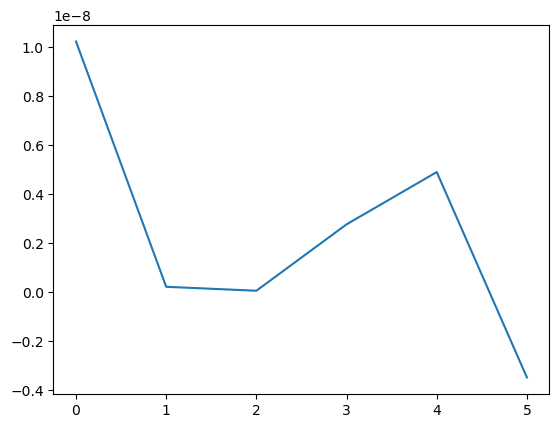

In [155]:
plt.plot(np.array([energy[-1] for energy in energy_intraS])-np.array([energy[-1] for energy in energy_interS]))

In [156]:
pd.DataFrame([[gap[-1] for gap in gap_intraS],[gap[-1] for gap in gap_interS],],index=['Intra s','Inter s'])

0         1         2         3         4         5
Intra s  0.000479  0.001605  0.003257  0.004909  0.006563  0.732314
Inter s  0.000468  0.001605  0.003257  0.004909  0.006563  0.732314

In [157]:
pd.DataFrame([[energy[-1] for energy in energy_intraS],[energy[-1] for energy in energy_interS],],index=['Intra s','Inter s'])

0         1         2         3         4         5
Intra s -2.902607 -2.693744 -2.484881 -2.276017 -2.067154 -1.854786
Inter s -2.902607 -2.693744 -2.484881 -2.276017 -2.067154 -1.854786

In [201]:
convert_pd(spin_interS[-1][1])

A1                  A2                  A3  \
A1  0.000011-0.000000j -0.000003-0.000000j -0.000000+0.000000j   
A2 -0.000003+0.000000j -0.000003-0.000000j  0.000001+0.000000j   
A3 -0.000000-0.000000j  0.000001-0.000000j -0.000003+0.000000j   
B1  0.000036-0.000000j -0.000006+0.000000j -0.000004+0.000000j   
B2 -0.000017-0.000000j -0.000018-0.000000j  0.000013-0.000000j   
B3 -0.000006-0.000000j  0.000035+0.000000j -0.000018-0.000000j   

                    B1                  B2                  B3  
A1  0.000036+0.000000j -0.000017+0.000000j -0.000006+0.000000j  
A2 -0.000006-0.000000j -0.000018+0.000000j  0.000035-0.000000j  
A3 -0.000004-0.000000j  0.000013+0.000000j -0.000018+0.000000j  
B1 -0.000011-0.000000j -0.000001-0.000000j  0.000001+0.000000j  
B2 -0.000001+0.000000j  0.000003+0.000000j -0.000001-0.000000j  
B3  0.000001-0.000000j -0.000001+0.000000j  0.000003+0.000000j

In [202]:
convert_pd(spin_intraS[-1][1])

A1                  A2                  A3  \
A1  0.001145+0.000000j -0.000361+0.000000j -0.000194+0.000000j   
A2 -0.000361-0.000000j  0.001145+0.000000j -0.000361+0.000000j   
A3 -0.000194-0.000000j -0.000361-0.000000j  0.001145+0.000000j   
B1  0.000013+0.000000j -0.000004-0.000000j -0.000000+0.000000j   
B2 -0.000006+0.000000j  0.000013+0.000000j -0.000004-0.000000j   
B3 -0.000005-0.000000j -0.000006+0.000000j  0.000013+0.000000j   

                    B1                  B2                  B3  
A1  0.000013-0.000000j -0.000006-0.000000j -0.000005+0.000000j  
A2 -0.000004+0.000000j  0.000013-0.000000j -0.000006-0.000000j  
A3 -0.000000-0.000000j -0.000004+0.000000j  0.000013-0.000000j  
B1 -0.001145+0.000000j  0.000361-0.000000j  0.000194-0.000000j  
B2  0.000361+0.000000j -0.001145+0.000000j  0.000361-0.000000j  
B3  0.000194+0.000000j  0.000361+0.000000j -0.001145+0.000000j

In [ ]:
[spin[1] for spin in spin_interS]

In [7]:
with open("results_nu_12_6_n_69_thres_1e-05.pkl", "rb") as f:
    results_intra = pickle.load(f)

# result = results[0][h]


In [6]:
with open("results_nu_14_7_n_69_thres_1e-05.pkl", "rb") as f:
    results_inter = pickle.load(f)

# result = results[0][h]


In [216]:
[results[(U,3)]['U_diff'] for U in range(6)]

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5]

In [217]:
[results[(U,3)]['h'] for U in range(6)]

[0.6, 0.6, 0.6, 0.6, 0.6, 0.6]

In [52]:
[results_intra[(0,h)]['gap'] for h in range(4)]

[0.0019562428406685872,
 0.009072343923963416,
 0.0025538224567357437,
 0.008291938090429635]

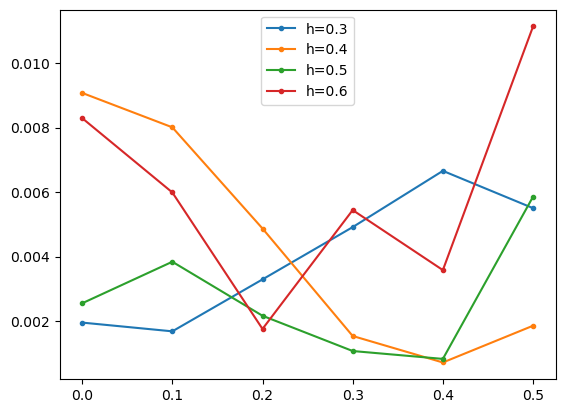

In [11]:
for i,h in enumerate(np.array([.3,.4,.5,.6])):
    plt.plot(np.linspace(0, .5, 6),[results_intra[(U,i)]['gap'] for U in range(6)],'.-',label=f'h={h}')
plt.legend()

([<matplotlib.axis.XTick at 0x7f19a5167340>,
 [Text(0.0, 0, '(0.5,0)'),
  Text(0.1, 0, '(0.4,0.1)'),
  Text(0.2, 0, '(0.3,0.2)'),
  Text(0.3, 0, '(0.2,0.3)'),
  Text(0.4, 0, '(0.1,0.4)'),
  Text(0.5, 0, '(0.,0.5)')])

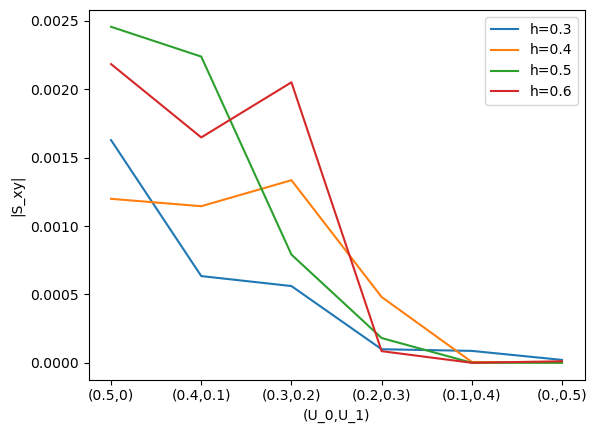

In [95]:
for i,h in enumerate(np.array([.3,.4,.5,.6])):
    plt.plot(np.linspace(0, .5, 6),[np.sqrt(np.abs(results_intra[(U,i)]['spin'][1].iloc[0,0])**2+np.abs(results_intra[(U,i)]['spin'][2].iloc[0,0])**2) for U in range(6)],label=f'h={h}')
plt.legend()
plt.ylabel('|S_xy|')
plt.xlabel('(U_0,U_1)')
plt.xticks(ticks=[0,.1,.2,.3,.4,.5],labels=['(0.5,0)','(0.4,0.1)','(0.3,0.2)','(0.2,0.3)','(0.1,0.4)','(0.,0.5)'])

In [67]:
results_intra[(0,3)]['spin'][1]

A1                  A2                  A3  \
A1  0.002184+0.000000j -0.000688+0.000000j -0.000189-0.000000j   
A2 -0.000688-0.000000j  0.002184+0.000000j -0.000688+0.000000j   
A3 -0.000189+0.000000j -0.000688-0.000000j  0.002184+0.000000j   
B1  0.000000+0.000000j -0.000000-0.000000j -0.000000-0.000000j   
B2  0.000000-0.000000j  0.000000+0.000000j -0.000000-0.000000j   
B3 -0.000000+0.000000j  0.000000-0.000000j  0.000000+0.000000j   

                    B1                  B2                  B3  
A1  0.000000-0.000000j  0.000000+0.000000j -0.000000-0.000000j  
A2 -0.000000+0.000000j  0.000000-0.000000j  0.000000+0.000000j  
A3 -0.000000+0.000000j -0.000000+0.000000j  0.000000-0.000000j  
B1 -0.002184+0.000000j  0.000688-0.000000j  0.000189-0.000000j  
B2  0.000688+0.000000j -0.002184+0.000000j  0.000688-0.000000j  
B3  0.000189+0.000000j  0.000688+0.000000j -0.002184+0.000000j

In [68]:
results_intra[(0,3)]['spin'][2]

A1                  A2                  A3  \
A1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.000000j   
A2 -0.000000-0.000000j  0.000000+0.000000j -0.000000+0.000000j   
A3  0.000000-0.000000j -0.000000-0.000000j  0.000000+0.000000j   
B1 -0.000000-0.000424j  0.000000+0.000103j -0.000000+0.000544j   
B2 -0.000000-0.000424j -0.000000-0.000424j  0.000000+0.000103j   
B3  0.000000+0.000103j -0.000000-0.000424j -0.000000-0.000424j   

                    B1                  B2                  B3  
A1 -0.000000+0.000424j -0.000000+0.000424j  0.000000-0.000103j  
A2  0.000000-0.000103j -0.000000+0.000424j -0.000000+0.000424j  
A3 -0.000000-0.000544j  0.000000-0.000103j -0.000000+0.000424j  
B1 -0.000000+0.000000j  0.000000+0.000000j  0.000000-0.000000j  
B2  0.000000-0.000000j -0.000000+0.000000j  0.000000+0.000000j  
B3  0.000000+0.000000j  0.000000-0.000000j -0.000000+0.000000j

([<matplotlib.axis.XTick at 0x7f19a527b8b0>,
 [Text(0.0, 0, '(0.5,0)'),
  Text(0.1, 0, '(0.4,0.1)'),
  Text(0.2, 0, '(0.3,0.2)'),
  Text(0.3, 0, '(0.2,0.3)'),
  Text(0.4, 0, '(0.1,0.4)'),
  Text(0.5, 0, '(0.,0.5)')])

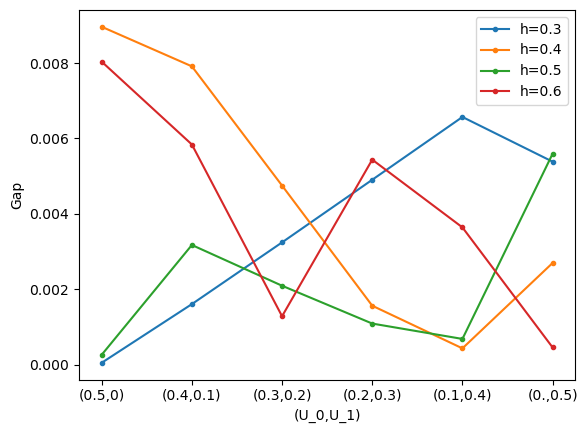

In [93]:
for i,h in enumerate(np.array([.3,.4,.5,.6])):
    plt.plot(np.linspace(0, .5, 6),[results_inter[(U,i)]['gap'] for U in range(6)],'.-',label=f'h={h}')
plt.legend()
plt.ylabel('Gap')
plt.xlabel('(U_0,U_1)')
plt.xticks(ticks=[0,.1,.2,.3,.4,.5],labels=['(0.5,0)','(0.4,0.1)','(0.3,0.2)','(0.2,0.3)','(0.1,0.4)','(0.,0.5)'])

In [97]:
params.k.shape

(4761, 2)

In [103]:
np.linalg.norm(params.k[0]-params.k[1])

0.060707104417194006

In [106]:
np.sqrt(params.k.shape[0])

69.0

In [120]:
np.sqrt(2*np.pi/(np.sqrt(3)*1/4)/params.k.shape[0])*np.sqrt(3)/2*np.abs(params.t[1])

0.09996691916284252

In [110]:
np.sqrt(2*np.pi/(np.sqrt(3)*1/4)/10000**2)*np.sqrt(3)/2*np.abs(params.t[1])

0.0003298908332373803

([<matplotlib.axis.XTick at 0x7f19a54b9520>,
 [Text(0.0, 0, '(0.5,0)'),
  Text(0.1, 0, '(0.4,0.1)'),
  Text(0.2, 0, '(0.3,0.2)'),
  Text(0.3, 0, '(0.2,0.3)'),
  Text(0.4, 0, '(0.1,0.4)'),
  Text(0.5, 0, '(0.,0.5)')])

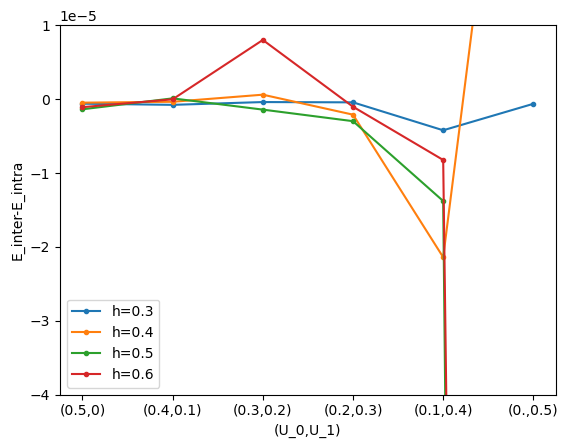

In [88]:
for i,h in enumerate(np.array([.3,.4,.5,.6])):
    plt.plot(np.linspace(0, .5, 6),[results_inter[(U,i)]['energy']-results_intra[(U,i)]['energy'] for U in range(6)],'.-',label=f'h={h}')
plt.legend()
plt.ylim([-4e-5,1e-5])
plt.ylabel('E_inter-E_intra')
plt.xlabel('(U_0,U_1)')
plt.xticks(ticks=[0,.1,.2,.3,.4,.5],labels=['(0.5,0)','(0.4,0.1)','(0.3,0.2)','(0.2,0.3)','(0.1,0.4)','(0.,0.5)'])

In [4]:
[results_inter[(U,3)]['gap'] for U in range(6)]

[0.008037593346455513,
 0.005839710841431145,
 0.0012827001333638455,
 0.005437585533762057,
 0.003639968701943941,
 0.0004547904828009486]

([<matplotlib.axis.XTick at 0x7f19a593e610>,
 [Text(0.0, 0, '(0.5,0)'),
  Text(0.1, 0, '(0.4,0.1)'),
  Text(0.2, 0, '(0.3,0.2)'),
  Text(0.3, 0, '(0.2,0.3)'),
  Text(0.4, 0, '(0.1,0.4)'),
  Text(0.5, 0, '(0.,0.5)')])

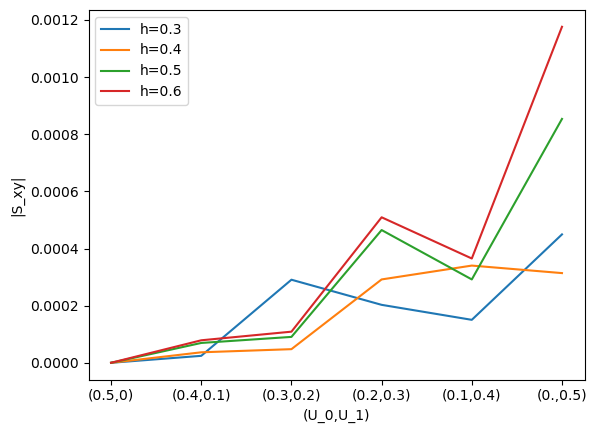

In [96]:
for i,h in enumerate(np.array([.3,.4,.5,.6])):
    plt.plot(np.linspace(0, .5, 6),[np.sqrt(np.abs(results_inter[(U,i)]['spin'][1].iloc[3,0])**2+np.abs((results_inter[(U,i)]['spin'][2].iloc[3,0]))**2) for U in range(6)],label=f'h={h}')
plt.legend()
plt.ylabel('|S_xy|')
plt.xlabel('(U_0,U_1)')
plt.xticks(ticks=[0,.1,.2,.3,.4,.5],labels=['(0.5,0)','(0.4,0.1)','(0.3,0.2)','(0.2,0.3)','(0.1,0.4)','(0.,0.5)'])

In [55]:
(results_inter[(5,3)]['spin'][1].iloc[3,0])

(0.001155-0j)

In [56]:
results_inter[(5,3)]['spin'][2].iloc[3,0]

-0.000222j

# Compare SDW and AF

## U1=0

In [17]:
with open("results_nu(12,6)_t1(-1.0,-1.0,1)_t2(-0.0,-0.5,11)_U0(1.0,10.0,10)_U1(0.0,0.0,1)_h0.6_thres1e-10_n33.pkl", "rb") as f:
    results_AF3 = pickle.load(f)

In [18]:
with open("results_nu(18,9)_t1(-1.0,-1.0,1)_t2(-0.0,-0.5,11)_U0(1.0,10.0,10)_U1(0.0,0.0,1)_h0.6_thres1e-10_n33.pkl", "rb") as f:
    results_SDW = pickle.load(f)

In [21]:
t1_max,t2_max,U0_max,U1_max=(list(zip(*results_SDW.keys())))
en_diff=[[results_SDW[(0,t2_idx,U0_idx,0)]['energy'] - results_AF3[(0,t2_idx,U0_idx,0)]['energy'] for t2_idx in range(max(t2_max))] for U0_idx in range(max(U0_max))]

In [23]:
results_lowest={}
t1_max,t2_max,U0_max,U1_max=(list(zip(*results_SDW.keys())))
for U0_idx in range(max(U0_max)):
    for t2_idx in range(max(t2_max)):
        endiff=results_SDW[(0,t2_idx,U0_idx,0)]['energy']-results_AF3[(0,t2_idx,U0_idx,0)]['energy']
        if endiff>0:
            results_lowest[(0,t2_idx,U0_idx,0)]=results_AF3[(0,t2_idx,U0_idx,0)]
        else:
            results_lowest[(0,t2_idx,U0_idx,0)]=results_SDW[(0,t2_idx,U0_idx,0)]


In [43]:
t2_list.shape

(11,)

In [44]:
U0_list.shape

(9,)

In [50]:
np.array(np.array(en_diff)>0).shape

(9, 10)

Text(0.1, 0.1, 'SDW')

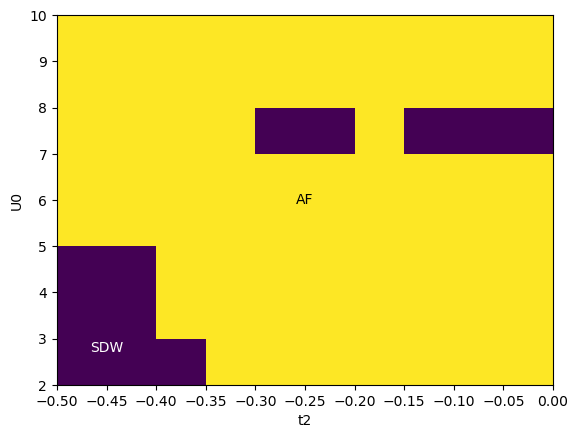

In [24]:
fig,ax=plt.subplots()
U0_list=np.linspace(results_SDW[(0,0,0,0)]['U0'],results_SDW[(0,0,max(U0_max),0)]['U0'],max(U0_max)+1)
t2_list=np.linspace(results_SDW[(0,0,0,0)]['t2'],results_SDW[(0,max(t2_max),0,0)]['t2'],max(t2_max)+1)
ax.pcolormesh(t2_list,U0_list[1:],np.array(en_diff[1:])>0)
ax.set_xlabel('t2')
ax.set_ylabel('U0')
ax.set_xticks(t2_list)
ax.set_yticks(U0_list[1:])
ax.text(.5,.5,'AF',ha='center',va='center',transform=ax.transAxes)
ax.text(.1,.1,'SDW',ha='center',va='center',transform=ax.transAxes,color='w')

In [26]:
[results_AF[(0,6,0,0)][key] for key in ['t1','t2','U0','U1']]

[-1.0, -0.42, 4.0, 0.0]

In [277]:
results_AF[(0,6,0,0)]['gap'],results_AF[(0,6,0,0)]['energy']

(0.0, -1.5788927110314261)

In [273]:
results_AF[(0,6,0,0)]['spin'][1]

A1                  A2                  A3  \
A1  0.626296+0.000000j -0.030271+0.000000j -0.003496+0.000000j   
A2 -0.030271-0.000000j  0.626296+0.000000j -0.030271+0.000000j   
A3 -0.003496-0.000000j -0.030271-0.000000j  0.626296+0.000000j   
B1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.000000j   
B2  0.000000-0.000000j  0.000000+0.000000j -0.000000+0.000000j   
B3 -0.000000-0.000000j  0.000000-0.000000j  0.000000+0.000000j   

                    B1                  B2                  B3  
A1  0.000000-0.000000j  0.000000+0.000000j -0.000000+0.000000j  
A2 -0.000000-0.000000j  0.000000-0.000000j  0.000000+0.000000j  
A3  0.000000-0.000000j -0.000000-0.000000j  0.000000-0.000000j  
B1 -0.626296+0.000000j  0.030271+0.000000j  0.003496-0.000000j  
B2  0.030271-0.000000j -0.626296+0.000000j  0.030271+0.000000j  
B3  0.003496+0.000000j  0.030271-0.000000j -0.626296+0.000000j

In [207]:
results_AF[(0,10,5,0)]['spin'][2]

A1                  A2                  A3  \
A1  0.000000+0.000000j  0.000000+0.000000j  0.000000-0.000000j   
A2  0.000000-0.000000j  0.000000+0.000000j  0.000000+0.000000j   
A3  0.000000+0.000000j  0.000000-0.000000j  0.000000+0.000000j   
B1 -0.000000-0.127686j -0.000000+0.003943j  0.000000+0.000348j   
B2 -0.000000-0.127686j -0.000000-0.127686j -0.000000+0.003943j   
B3 -0.000000+0.003943j -0.000000-0.127686j -0.000000-0.127686j   

                    B1                  B2                  B3  
A1 -0.000000+0.127686j -0.000000+0.127686j -0.000000-0.003943j  
A2 -0.000000-0.003943j -0.000000+0.127686j -0.000000+0.127686j  
A3  0.000000-0.000348j -0.000000-0.003943j -0.000000+0.127686j  
B1 -0.000000+0.000000j -0.000000-0.000000j  0.000000-0.000000j  
B2 -0.000000+0.000000j -0.000000+0.000000j -0.000000-0.000000j  
B3  0.000000+0.000000j -0.000000+0.000000j -0.000000+0.000000j

In [65]:
results_AF[(0,0,1,0)]['gap']

0.03208780254683241

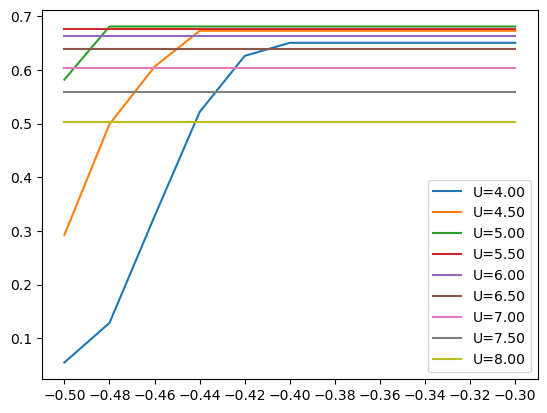

In [242]:
for i in range(9):
    U0_list=np.linspace(results_AF[(0,0,0,0)]['U0'],results_AF[(0,0,8,0)]['U0'],9)
    t2_list=np.linspace(results_AF[(0,0,i,0)]['t2'],results_AF[(0,10,i,0)]['t2'],11)
    plt.plot(t2_list,[results_AF[(0,x,i,0)]['spin'][1].iloc[0,0].real for x in range(11)],label=f'U={U0_list[i]:.2f}')
plt.xticks(t2_list)
plt.legend()

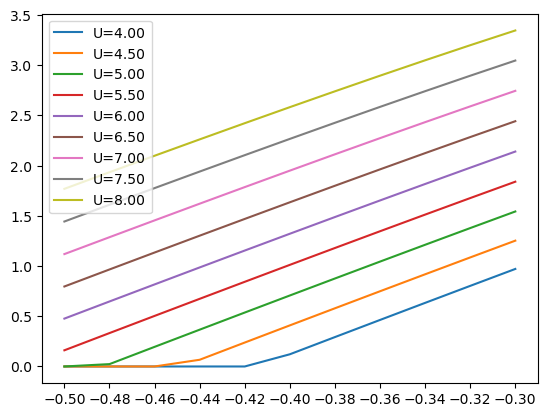

In [240]:
for i in range(9):
    U0_list=np.linspace(results_AF[(0,0,0,0)]['U0'],results_AF[(0,0,8,0)]['U0'],9)
    t2_list=np.linspace(results_AF[(0,0,i,0)]['t2'],results_AF[(0,10,i,0)]['t2'],11)
    plt.plot(t2_list,[results_AF[(0,x,i,0)]['gap'] for x in range(11)],label=f'U={U0_list[i]:.2f}')
plt.xticks(t2_list)
plt.legend()

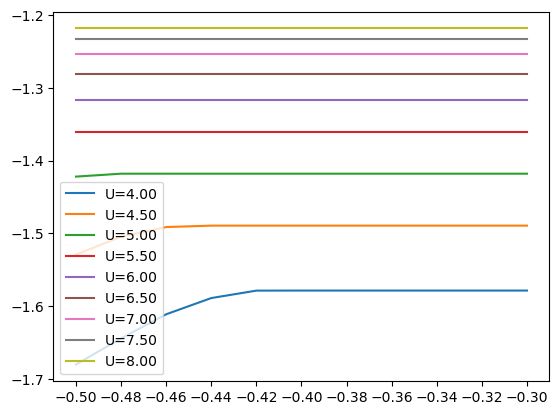

In [243]:
for i in range(9):
    U0_list=np.linspace(results_AF[(0,0,0,0)]['U0'],results_AF[(0,0,8,0)]['U0'],9)
    t2_list=np.linspace(results_AF[(0,0,i,0)]['t2'],results_AF[(0,10,i,0)]['t2'],11)
    plt.plot(t2_list,[results_AF[(0,x,i,0)]['energy'] for x in range(11)],label=f'U={U0_list[i]:.2f}')
plt.xticks(t2_list)
plt.legend()

In [27]:
with open("results_nu(18,9)_t1(-1.0,-1.0,1)_t2(-0.3,-0.5,11)_U0(4.0,8.0,9)_U1(0.0,0.0,1)_h0.6_thres1e-10_n33__.pkl", "rb") as f:
    results_SDW = pickle.load(f)

In [28]:
[results_SDW[(0,6,0,0)][key] for key in ['t1','t2','U0','U1']]

[-1.0, -0.42, 4.0, 0.0]

In [347]:
results_SDW[(0,6,0,0)]['gap'],results_SDW[(0,6,0,0)]['energy']

(0.791233184502595, -1.5982043254179321)

In [348]:
results_SDW[(0,6,0,0)]['spin'][1]

A1                  A2                  A3  \
A1  0.251217+0.000000j  0.012699+0.003110j -0.003387-0.001772j   
A2  0.012699-0.003110j  0.251217+0.000000j -0.067620-0.000000j   
A3 -0.003387+0.001772j -0.067620+0.000000j  0.251217-0.000000j   
B1  0.005290-0.070607j -0.002465+0.019487j -0.004905-0.008979j   
B2  0.005290-0.070608j  0.005290-0.070608j  0.007933+0.023722j   
B3 -0.013919+0.007950j -0.019686+0.022776j -0.019686+0.022776j   

                    B1                  B2                  B3  
A1  0.005290+0.070607j  0.005290+0.070608j -0.013919-0.007950j  
A2 -0.002465-0.019487j  0.005290+0.070608j -0.019686-0.022776j  
A3 -0.004905+0.008979j  0.007933-0.023722j -0.019686-0.022776j  
B1 -0.355237+0.000000j  0.023147+0.000000j -0.005257-0.009830j  
B2  0.023147-0.000000j -0.355235-0.000000j  0.023144+0.035181j  
B3 -0.005257+0.009830j  0.023144-0.035181j -0.043200-0.000000j

In [349]:
results_SDW[(0,6,0,0)]['spin'][2]

A1                  A2                  A3  \
A1 -0.197391-0.000000j -0.009982+0.003960j  0.002662-0.002257j   
A2 -0.009982-0.003960j -0.197391-0.000000j  0.053142+0.000000j   
A3  0.002662+0.002257j  0.053142-0.000000j -0.197391+0.000000j   
B1 -0.004158-0.089852j  0.001936+0.024802j  0.003854-0.011427j   
B2 -0.004158-0.089852j -0.004158-0.089852j -0.006233+0.030186j   
B3  0.010937+0.010118j  0.015468+0.028970j  0.015468+0.028970j   

                    B1                  B2                  B3  
A1 -0.004158+0.089852j -0.004158+0.089852j  0.010937-0.010118j  
A2  0.001936-0.024802j -0.004158+0.089852j  0.015468-0.028970j  
A3  0.003854+0.011427j -0.006233-0.030186j  0.015468-0.028970j  
B1  0.279157-0.000000j -0.018188-0.000000j  0.004130-0.012510j  
B2 -0.018188+0.000000j  0.279160+0.000000j -0.018188+0.044773j  
B3  0.004130+0.012510j -0.018188-0.044773j  0.033891-0.000000j

In [350]:
results_SDW[(0,6,0,0)]['spin'][3]

A1                  A2                  A3  \
A1 -0.707189-0.000000j  0.028739-0.000001j -0.016175+0.000001j   
A2  0.028739+0.000001j -0.707189+0.000000j  0.094066-0.000000j   
A3 -0.016175-0.000001j  0.094066+0.000000j -0.707189+0.000000j   
B1  0.066593-0.000002j  0.002950+0.000001j -0.004960+0.000000j   
B2  0.066593-0.000002j  0.066593-0.000002j  0.054337-0.000001j   
B3  0.038271+0.000000j  0.010162+0.000004j  0.010162+0.000004j   

                    B1                  B2                  B3  
A1  0.066593+0.000002j  0.066593+0.000002j  0.038271-0.000000j  
A2  0.002950-0.000001j  0.066593+0.000002j  0.010162-0.000004j  
A3 -0.004960-0.000000j  0.054337+0.000001j  0.010162-0.000004j  
B1 -0.714159+0.000000j  0.058480-0.000000j -0.015777-0.000001j  
B2  0.058480+0.000000j -0.714159-0.000000j  0.028391+0.000004j  
B3 -0.015777+0.000001j  0.028391-0.000004j  0.309433+0.000000j

Text(0, 0.5, 'S_i x S_j')

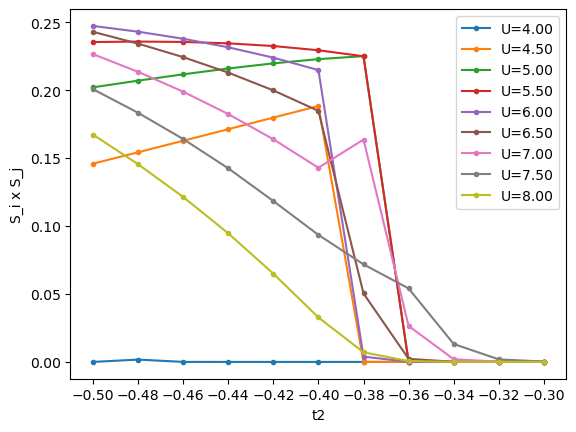

In [370]:
for i in range(9):
    U0_list=np.linspace(results_SDW[(0,0,0,0)]['U0'],results_SDW[(0,0,8,0)]['U0'],9)
    t2_list=np.linspace(results_SDW[(0,0,i,0)]['t2'],results_SDW[(0,10,i,0)]['t2'],11)
    plt.plot(t2_list,[OP_SDW(results_SDW[(0,x,i,0)]['spin']) for x in range(11)],'.-',label=f'U={U0_list[i]:.2f}')
plt.xticks(t2_list)
plt.legend()
plt.xlabel('t2')
plt.ylabel('S_i x S_j')

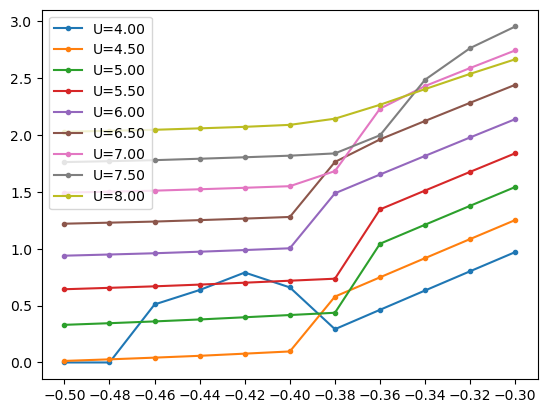

In [261]:
for i in range(9):
    U0_list=np.linspace(results_SDW[(0,0,0,0)]['U0'],results_SDW[(0,0,8,0)]['U0'],9)
    t2_list=np.linspace(results_SDW[(0,0,i,0)]['t2'],results_SDW[(0,10,i,0)]['t2'],11)
    plt.plot(t2_list,[results_SDW[(0,x,i,0)]['gap'] for x in range(11)],'.-',label=f'U={U0_list[i]:.2f}')
plt.xticks(t2_list)
plt.legend()

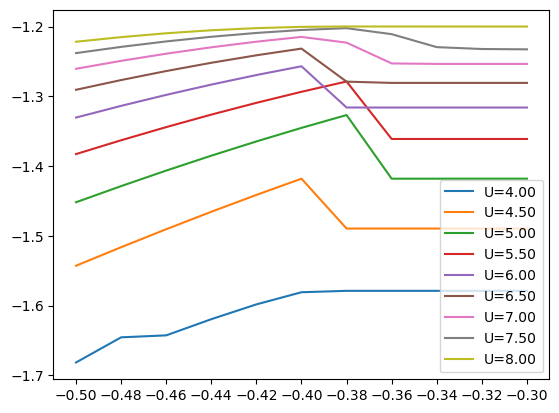

In [262]:
for i in range(9):
    U0_list=np.linspace(results_SDW[(0,0,0,0)]['U0'],results_SDW[(0,0,8,0)]['U0'],9)
    t2_list=np.linspace(results_SDW[(0,0,i,0)]['t2'],results_SDW[(0,10,i,0)]['t2'],11)
    plt.plot(t2_list,[results_SDW[(0,x,i,0)]['energy'] for x in range(11)],label=f'U={U0_list[i]:.2f}')
plt.xticks(t2_list)
plt.legend()

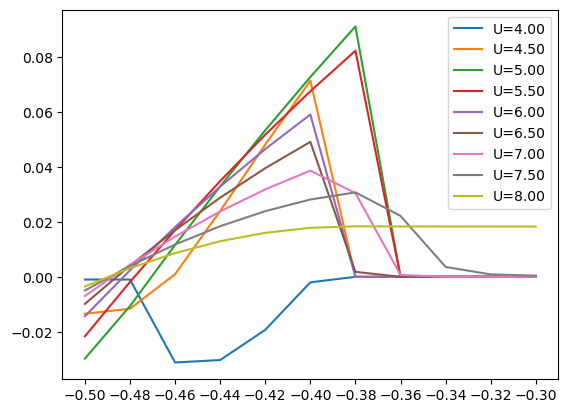

In [47]:
for i in range(0,9):
    U0_list=np.linspace(results_SDW[(0,0,0,0)]['U0'],results_SDW[(0,0,8,0)]['U0'],9)
    t2_list=np.linspace(results_SDW[(0,0,i,0)]['t2'],results_SDW[(0,10,i,0)]['t2'],11)
    plt.plot(t2_list,[results_SDW[(0,x,i,0)]['energy'] - results_AF[(0,x,i,0)]['energy'] for x in range(11)],label=f'U={U0_list[i]:.2f}')
plt.xticks(t2_list)
plt.legend()

In [30]:
en_diff=[[results_SDW[(0,x,i,0)]['energy'] - results_AF[(0,x,i,0)]['energy'] for x in range(11)] for i in range(9)]

In [33]:
U0_list=np.linspace(results_SDW[(0,0,0,0)]['U0'],results_SDW[(0,0,8,0)]['U0'],9)
t2_list=np.linspace(results_SDW[(0,0,0,0)]['t2'],results_SDW[(0,10,0,0)]['t2'],11)

Text(0.1, 0.1, 'SDW')

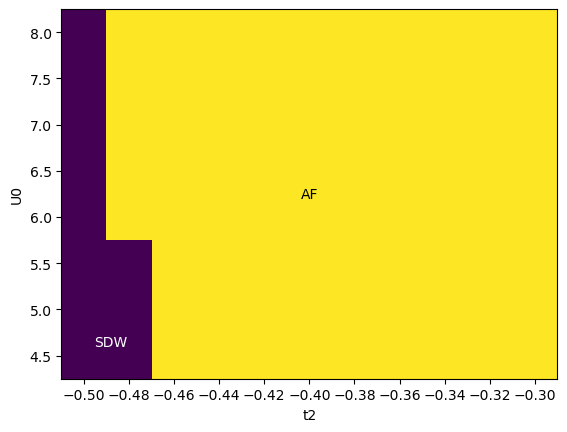

In [36]:
fig,ax=plt.subplots()
ax.pcolormesh(t2_list,U0_list[1:],np.array(en_diff[1:])>0)
ax.set_xlabel('t2')
ax.set_ylabel('U0')
ax.set_xticks(t2_list)
ax.set_yticks(U0_list[1:])
ax.text(.5,.5,'AF',ha='center',va='center',transform=ax.transAxes)
ax.text(.1,.1,'SDW',ha='center',va='center',transform=ax.transAxes,color='w')

In [37]:
results_lowest={}
for i in range(9):
    for x in range(11):
        endiff=results_SDW[(0,x,i,0)]['energy']-results_AF[(0,x,i,0)]['energy']
        if endiff>0:
            results_lowest[(0,x,i,0)]=results_AF[(0,x,i,0)]
        else:
            results_lowest[(0,x,i,0)]=results_SDW[(0,x,i,0)]


In [38]:
gap_lowest=np.array([[results_lowest[(0,x,i,0)]['gap'] for x in range(11)] for i in range(9)])

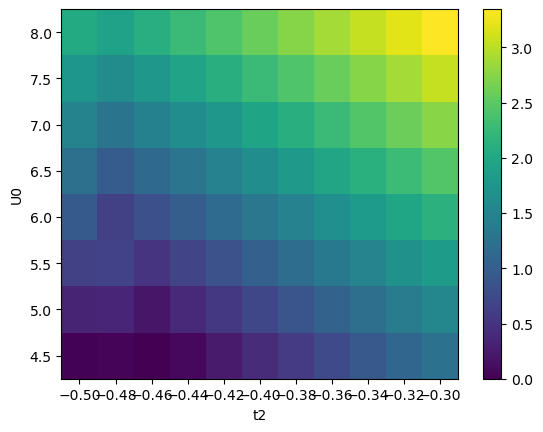

In [39]:
fig,ax=plt.subplots()
im=ax.pcolormesh(t2_list,U0_list[1:],gap_lowest[1:,:])
ax.set_xlabel('t2')
ax.set_ylabel('U0')
cb=fig.colorbar(im)
ax.set_xticks(t2_list)
ax.set_yticks(U0_list[1:])

In [44]:
OP_SDW_lowest=np.array([[OP_SDW(results_lowest[(0,x,i,0)]['spin']) for x in range(11)] for i in range(9)])

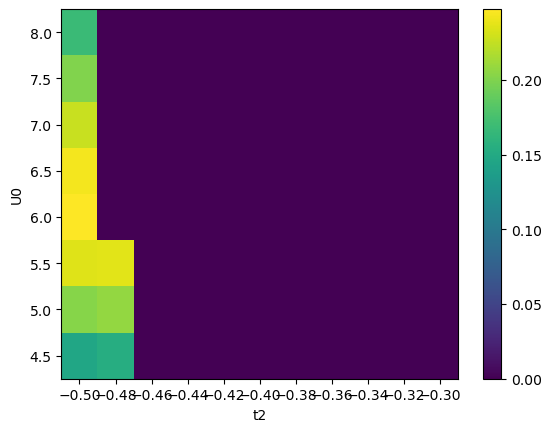

In [45]:
fig,ax=plt.subplots()
im=ax.pcolormesh(t2_list,U0_list[1:],OP_SDW_lowest[1:,:])
ax.set_xlabel('t2')
ax.set_ylabel('U0')
cb=fig.colorbar(im)
ax.set_xticks(t2_list)
ax.set_yticks(U0_list[1:])

In [399]:
[results_lowest[(0,10,8,0)][key] for key in ['t1','t2','U0','U1']]

[-1.0, -0.5, 8.0, 0.0]

In [398]:
results_lowest[(0,10,8,0)]['spin'][1]

A1                  A2                  A3  \
A1  0.439547+0.000000j  0.000255+0.020391j -0.001673+0.003788j   
A2  0.000255-0.020391j -0.219772-0.000000j -0.015923-0.044864j   
A3 -0.001673-0.003788j -0.015923+0.044864j -0.219772+0.000000j   
B1 -0.000000-0.000000j -0.015711-0.000752j -0.000836+0.001353j   
B2  0.017492-0.042574j -0.000000+0.000000j -0.000000+0.002826j   
B3  0.003128+0.003274j  0.000000+0.087928j  0.000000+0.000000j   

                    B1                  B2                  B3  
A1 -0.000000+0.000000j  0.017492+0.042574j  0.003128-0.003274j  
A2 -0.015711+0.000752j -0.000000-0.000000j  0.000000-0.087928j  
A3 -0.000836-0.001353j -0.000000-0.002826j  0.000000-0.000000j  
B1 -0.439547-0.000000j -0.019477+0.025507j -0.002477-0.001600j  
B2 -0.019477-0.025507j  0.219772-0.000000j  0.015923-0.044864j  
B3 -0.002477+0.001600j  0.015923+0.044864j  0.219772+0.000000j

In [109]:
t2_list=np.linspace(0,-1,21)
U0_list=np.linspace(0, 10,11)

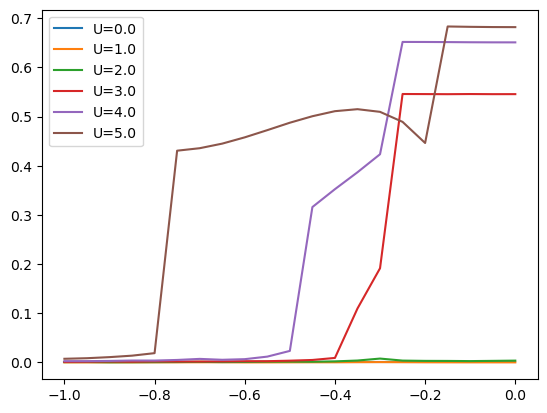

In [104]:
for i in range(6):
    plt.plot(t2_list,[np.sqrt(np.abs(results_SDW[(0,x,i,0)]['spin'][1].iloc[0,0])**2+np.abs(results_SDW[(0,x,i,0)]['spin'][2].iloc[0,0])**2) for x in range(21)],label=f'U={U0_list[i]}')

plt.legend()

In [190]:
x,i=15,5
np.cross(    np.array([results_SDW[(0,x,i,0)]['spin'][1].iloc[0,0].real,results_SDW[(0,x,i,0)]['spin'][2].iloc[0,0].real]),np.array([results_SDW[(0,x,i,0)]['spin'][1].iloc[1,1].real,results_SDW[(0,x,i,0)]['spin'][2].iloc[1,1].real]))

array(0.16061425)

In [123]:
np.array([((results_SDW[(0,5,i,0)]['spin'][1].iloc[0,0])),((results_SDW[(0,5,i,0)]['spin'][2].iloc[0,0]))])

array([ 0.489235+0.j, -0.      +0.j])

In [132]:
np.array([results_SDW[(0,5,i,0)]['spin'][1].iloc[0,0].real,results_SDW[(0,5,i,0)]['spin'][2].iloc[0,0].real])

array([ 0.489235, -0.      ])

In [133]:
np.array([results_SDW[(0,5,i,0)]['spin'][1].iloc[1,1].real,results_SDW[(0,5,i,0)]['spin'][2].iloc[1,1].real])

array([-0.244578,  0.423676])

In [252]:
OP_SDW(results_SDW[(0,5,5,0)]['spin'])

array(0.18476471)

In [131]:
np.cross(    np.array([results_SDW[(0,5,i,0)]['spin'][1].iloc[0,0].real,results_SDW[(0,5,i,0)]['spin'][2].iloc[0,0].real]),np.array([results_SDW[(0,5,i,0)]['spin'][1].iloc[1,1].real,results_SDW[(0,5,i,0)]['spin'][2].iloc[1,1].real]))

array(0.20727713)

In [134]:
np.cross(np.array([0.489235, -0. ]),np.array([-0.244578,  0.423676]))

array(0.20727713)

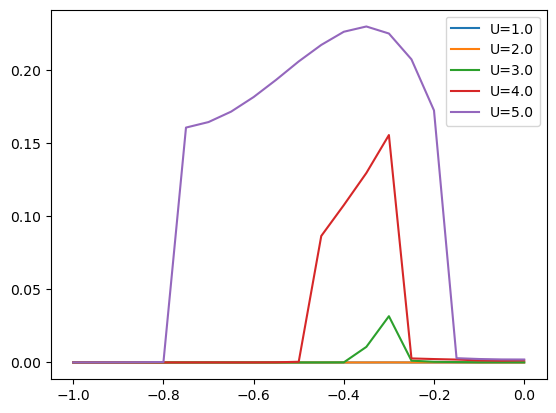

In [111]:
for i in range(1,6):
    plt.plot(t2_list,[OP_SDW(results_SDW[(0,x,i,0)]['spin']) for x in range(21)],label=f'U={U0_list[i]}')

plt.legend()

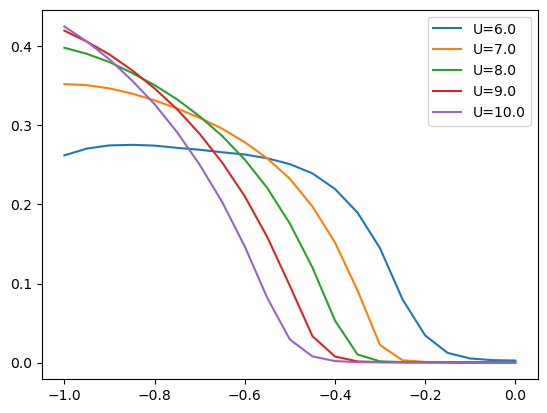

In [145]:
for i in range(6,11):
    plt.plot(t2_list,[np.cross(    np.array([results_SDW[(0,x,i,0)]['spin'][1].iloc[0,0].real,results_SDW[(0,x,i,0)]['spin'][2].iloc[0,0].real]),np.array([results_SDW[(0,x,i,0)]['spin'][1].iloc[1,1].real,results_SDW[(0,x,i,0)]['spin'][2].iloc[1,1].real])) for x in range(21)],label=f'U={U0_list[i]}')

plt.legend()

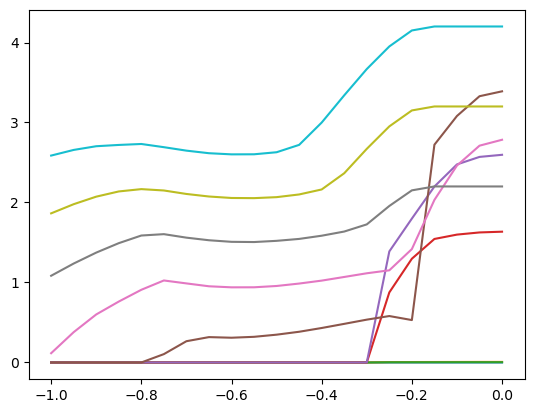

In [148]:
for i in range(10):
    plt.plot(np.linspace(0,-1,21),[results_SDW[(0,x ,i,0)]['gap'] for x in range(21)])

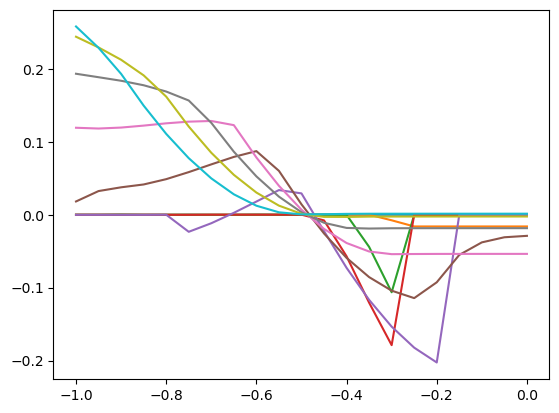

In [152]:
for i in range(1,11):
    plt.plot(np.linspace(0,-1,21),[results_AF[(0,x ,i,0)]['energy']-results_SDW[(0,x ,i,0)]['energy'] for x in range(21)])

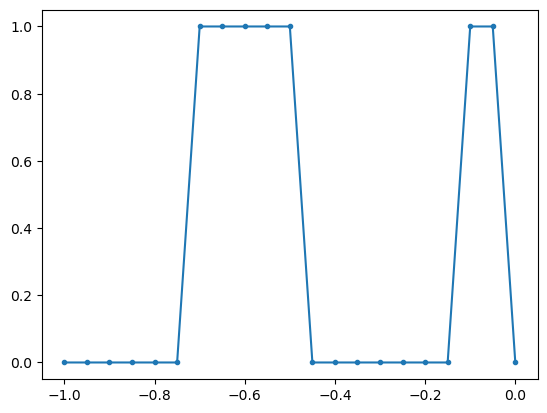

In [172]:
i=4
plt.plot(np.linspace(0,-1,21),[(results_AF[(0,x ,i,0)]['energy']-results_SDW[(0,x ,i,0)]['energy'])>0 for x in range(21)],'.-')

## t2=0.2 U1>0

In [2]:
# with open("results_nu(-2,-1)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(1.0,10.0,10)_U1(1.0,10.0,10)_h0.6_thres1e-10_n33.pkl", "rb") as f:
with open("results_nu(-2,-1)_t1(-1.0,-1.0,1)_t2(-0.0,-0.0,1)_U0(1.0,10.0,51)_U1(0.0,10.0,51)_h0.6_thres1e-10_n33.pkl", "rb") as f:
    results_CDW = pickle.load(f)


NameError: name 'pickle' is not defined

In [ ]:
# with open("results_nu(12,6)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(1.0,5.0,5)_U1(1.0,5.0,5)_h0.6_thres1e-10_n33.pkl", "rb") as f:
# with open("results_nu(12,6)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(6.0,10.0,5)_U1(1.0,10.0,10)_h0.6_thres1e-10_n33.pkl", "rb") as f:
# with open("results_nu(12,6)_t1(-1.0,-1.0,1)_t2(-0.0,-0.0,1)_U0(1.0,10.0,10)_U1(1.0,10.0,10)_h0.6_thres1e-10_n33.pkl", "rb") as f:

with open("results_nu(2,1)_t1(-1.0,-1.0,1)_t2(-0.0,-0.0,1)_U0(1.0,10.0,51)_U1(0.0,10.0,51)_h0.6_thres1e-10_n33.pkl", "rb") as f:
# with open("results_nu(12,6)_t1(-1.0,-1.0,1)_t2(-0.0,-0.5,11)_U0(1.0,10.0,10)_U1(0.0,0.0,1)_h0.6_thres1e-10_n33.pkl", "rb") as f:
    results_AF = pickle.load(f)


In [14]:
with open("results_nu(12,6)_t1(-1.0,-1.0,1)_t2(-0.0,-0.5,11)_U0(1.0,10.0,10)_U1(0.0,0.0,1)_h0.6_thres1e-10_n33.pkl", "rb") as f:

    results_AF3 = pickle.load(f)

In [5]:
# with open("results_nu(14,7)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(1.0,5.0,5)_U1(1.0,5.0,5)_h0.6_thres1e-10_n33.pkl", "rb") as f:
# with open("results_nu(14,7)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(6.0,10.0,5)_U1(1.0,10.0,10)_h0.6_thres1e-10_n33.pkl", "rb") as f:
with open("results_nu(14,7)_t1(-1.0,-1.0,1)_t2(-0.0,-0.0,1)_U0(1.0,10.0,10)_U1(1.0,10.0,10)_h0.6_thres1e-10_n33.pkl", "rb") as f:


    results_3 = pickle.load(f)


In [6]:
# with open("results_nu(16,8)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(1.0,5.0,5)_U1(1.0,5.0,5)_h0.6_thres1e-10_n33.pkl", "rb") as f:
# with open("results_nu(16,8)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(6.0,10.0,5)_U1(1.0,10.0,10)_h0.6_thres1e-10_n33.pkl", "rb") as f:
with open("results_nu(16,8)_t1(-1.0,-1.0,1)_t2(-0.0,-0.0,1)_U0(1.0,10.0,10)_U1(1.0,10.0,10)_h0.6_thres1e-10_n33.pkl", "rb") as f:


    results_4 = pickle.load(f)


In [15]:
# with open("results_nu(18,9)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(1.0,5.0,5)_U1(1.0,5.0,5)_h0.6_thres1e-10_n33.pkl", "rb") as f:
# with open("results_nu(18,9)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(6.0,10.0,5)_U1(1.0,10.0,10)_h0.6_thres1e-10_n33.pkl", "rb") as f:
with open("results_nu(18,9)_t1(-1.0,-1.0,1)_t2(-0.0,-0.5,11)_U0(1.0,10.0,10)_U1(0.0,0.0,1)_h0.6_thres1e-10_n33.pkl", "rb") as f:

    results_SDW = pickle.load(f)


In [171]:
[results_AF[(0,0,9,0)][key] for key in ['t1','t2','U0','U1']]

[-1.0, -0.1, 10.0, 1.0]

In [136]:
for i, df in enumerate([results_SDW[(0,0,9,x)]['spin'][1] for x in range(10)]):
    print(f'U1={results_SDW[(0,0,0,i)]["U1"]}', end='')
    if i != 0:  
        print('-' * 20)
    print(df)

U1=1.0                    A1                  A2                  A3  \
A1 -0.008251+0.000000j -0.000340-0.000000j -0.000014+0.000000j   
A2 -0.000340+0.000000j -0.008251-0.000000j -0.000340+0.000000j   
A3 -0.000014-0.000000j -0.000340-0.000000j -0.008251-0.000000j   
B1 -0.000003-0.000000j -0.000002-0.000000j -0.000000+0.000000j   
B2  0.000076-0.000000j -0.000003-0.000000j -0.000002+0.000000j   
B3  0.000001+0.000000j  0.000076+0.000000j -0.000003-0.000000j   

                    B1                  B2                  B3  
A1 -0.000003+0.000000j  0.000076+0.000000j  0.000001-0.000000j  
A2 -0.000002+0.000000j -0.000003+0.000000j  0.000076-0.000000j  
A3 -0.000000-0.000000j -0.000002-0.000000j -0.000003+0.000000j  
B1  0.008251-0.000000j  0.000340+0.000000j  0.000014+0.000000j  
B2  0.000340-0.000000j  0.008251-0.000000j  0.000340-0.000000j  
B3  0.000014-0.000000j  0.000340+0.000000j  0.008251-0.000000j  
U1=2.0--------------------
                    A1                  A2       

In [93]:
[OP_SDW(results_SDW[(0,0,2,x)]['spin']) for x in range(10)]

[array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.)]

Text(0.5, 1.0, '4')

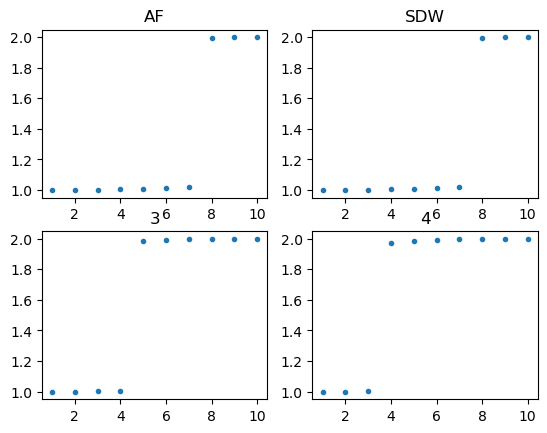

In [133]:
fig,axs=plt.subplots(2,2)

axs[0,0].plot([results_AF[(0,0,9,x)]['U1'] for x in range(10)],[results_AF[(0,0,9,x)]['spin'][0].iloc[0,0].real for x in range(10)],'.')
axs[0,0].set_title('AF')

axs[0,1].plot([results_SDW[(0,0,9,x)]['U1'] for x in range(10)],[results_SDW[(0,0,9,x)]['spin'][0].iloc[0,0].real for x in range(10)],'.')
axs[0,1].set_title('SDW')

axs[1,0].plot([results_3[(0,0,9,x)]['U1'] for x in range(10)],[results_3[(0,0,9,x)]['spin'][0].iloc[0,0].real for x in range(10)],'.')
axs[1,0].set_title('3')

axs[1,1].plot([results_4[(0,0,9,x)]['U1'] for x in range(10)],[results_4[(0,0,9,x)]['spin'][0].iloc[0,0].real for x in range(10)],'.')
axs[1,1].set_title('4')

In [8]:
[results_CDW[(0,0,9,x)]['U1'] for x in range(10)]

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

Text(0, 0.5, 'U1')

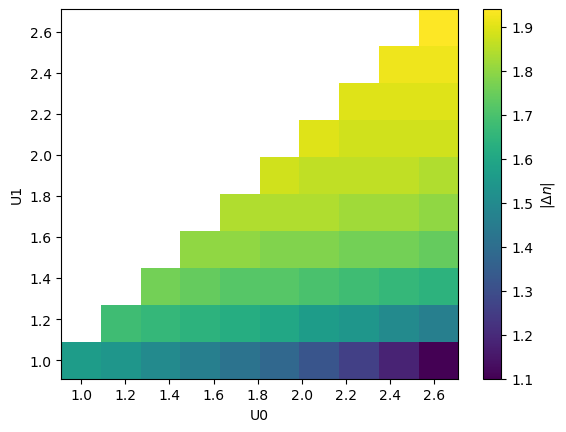

In [7]:
plt.pcolormesh([results_CDW[(0,0,x,0)]['U0'] for x in range(10)],[results_CDW[(0,0,9,x)]['U1'] for x in range(10)],np.array([[results_CDW[(0,0,i,x)]['spin'][0].iloc[0,0].real-results_CDW[(0,0,i,x)]['spin'][0].iloc[1,1].real if x<=i else np.nan for x in range(10)] for i in range(10)]).T)
plt.colorbar(label='$|\Delta n|$')
plt.xlabel('U0')
plt.ylabel('U1')


Text(0, 0.5, 't2')

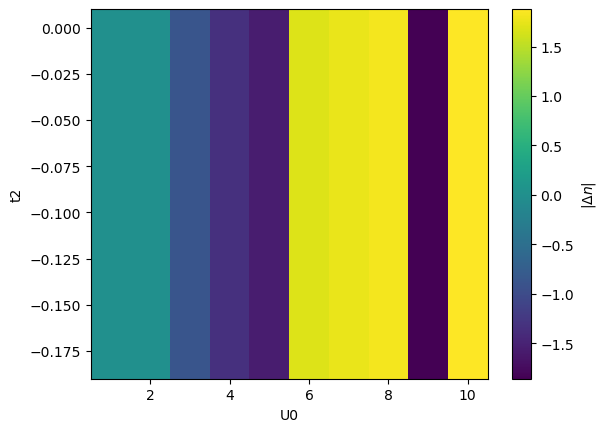

In [10]:
plt.pcolormesh([results_CDW[(0,0,x,0)]['U0'] for x in range(10)],[results_CDW[(0,x,9,0)]['t2'] for x in range(10)],np.array([[results_CDW[(0,x,i,0)]['spin'][0].iloc[0,0].real-results_CDW[(0,x,i,0)]['spin'][0].iloc[1,1].real for x in range(10)] for i in range(10)]).T)
plt.colorbar(label='$|\Delta n|$')
plt.xlabel('U0')
plt.ylabel('t2')


Text(0, 0.5, 't2')

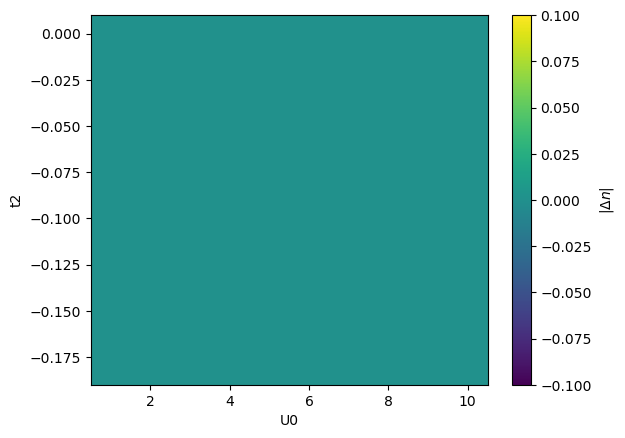

In [11]:
plt.pcolormesh([results_AF[(0,0,x,0)]['U0'] for x in range(10)],[results_AF[(0,x,9,0)]['t2'] for x in range(10)],np.array([[results_AF[(0,x,i,0)]['spin'][0].iloc[0,0].real-results_AF[(0,x,i,0)]['spin'][0].iloc[1,1].real for x in range(10)] for i in range(10)]).T)
plt.colorbar(label='$|\Delta n|$')
plt.xlabel('U0')
plt.ylabel('t2')


Text(0, 0.5, 'U1')

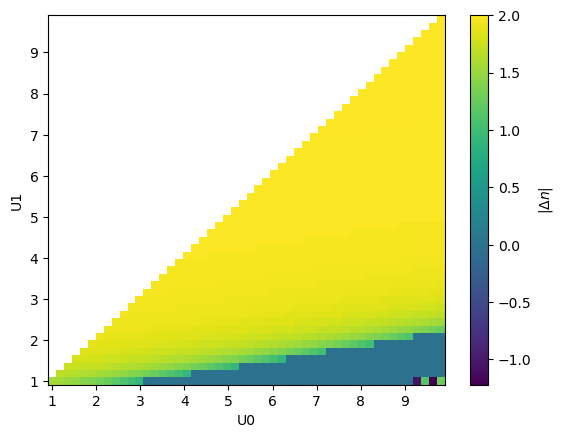

In [10]:
t1_max,t2_max,U0_max,U1_max=(list(zip(*results_CDW.keys())))

plt.pcolormesh([results_CDW[(0,0,U0_idx,0)]['U0'] for U0_idx in range(max(U0_max))],[results_CDW[(0,0,9,U1_idx)]['U1'] for U1_idx in range(max(U1_max))],np.array([[results_CDW[(0,0,U0_idx,U1_idx)]['spin'][0].iloc[0,0].real-results_CDW[(0,0,U0_idx,U1_idx)]['spin'][0].iloc[1,1].real if U1_idx<=U0_idx else np.nan for U1_idx in range(max(U1_max))] for U0_idx in range(max(U0_max))]).T)
plt.colorbar(label='$|\Delta n|$')
plt.xlabel('U0')
plt.ylabel('U1')


In [26]:
results_lowest={}
for i in range(10):
    for x in range(10):
        endiff=results_CDW[(0,0,x,i)]['energy']-results_AF[(0,0,x,i)]['energy']
        if endiff>0:
            results_lowest[(0,0,x,i)]=results_AF[(0,0,x,i)]
        else:
            results_lowest[(0,0,x,i)]=results_CDW[(0,0,x,i)]


Text(0, 0.5, 'U1')

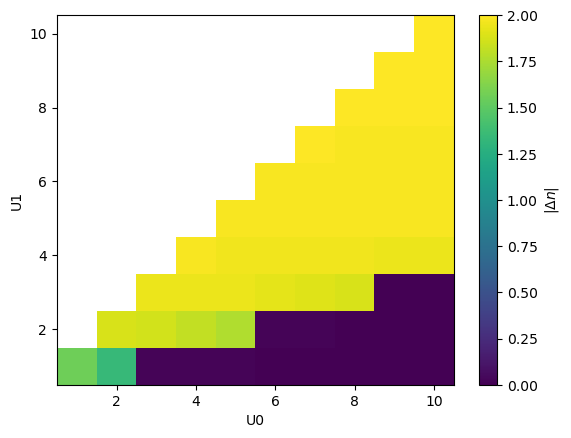

In [27]:
plt.pcolormesh([results_lowest[(0,0,x,0)]['U0'] for x in range(10)],[results_lowest[(0,0,9,x)]['U1'] for x in range(10)],np.array([[results_lowest[(0,0,i,x)]['spin'][0].iloc[0,0].real-results_lowest[(0,0,i,x)]['spin'][0].iloc[1,1].real if x<=i else np.nan for x in range(10)] for i in range(10)]).T)
plt.colorbar(label='$|\Delta n|$')
plt.xlabel('U0')
plt.ylabel('U1')


Text(0, 0.5, 'U1')

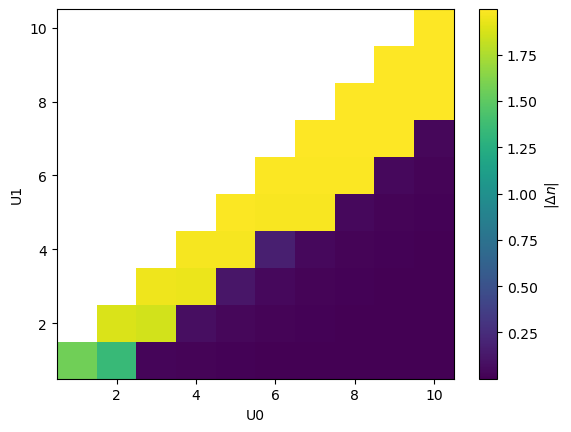

In [ ]:
plt.pcolormesh([results_AF[(0,0,x,0)]['U0'] for x in range(10)],[results_AF[(0,0,9,x)]['U1'] for x in range(10)],np.array([[results_AF[(0,0,i,x)]['spin'][0].iloc[0,0].real-results_AF[(0,0,i,x)]['spin'][0].iloc[3,3].real if x<=i else np.nan for x in range(10)] for i in range(10)]).T)
plt.colorbar(label='$|\Delta n|$')
plt.xlabel('U0')
plt.ylabel('U1')


In [11]:
results_4[(0,0,0,0)]['spin'][1]

A1                  A2                  A3  \
A1  0.651124+0.000000j  0.005211-0.000000j -0.002380-0.000000j   
A2  0.005211+0.000000j  0.651124+0.000000j  0.005211-0.000000j   
A3 -0.002380+0.000000j  0.005211+0.000000j  0.651124+0.000000j   
B1  0.003052-0.000000j  0.000390+0.000000j -0.000044+0.000000j   
B2 -0.009402-0.000000j  0.003052-0.000000j  0.000390+0.000000j   
B3  0.000278+0.000000j -0.009402-0.000000j  0.003052-0.000000j   

                    B1                  B2                  B3  
A1  0.003052+0.000000j -0.009402+0.000000j  0.000278-0.000000j  
A2  0.000390-0.000000j  0.003052+0.000000j -0.009402+0.000000j  
A3 -0.000044-0.000000j  0.000390-0.000000j  0.003052+0.000000j  
B1 -0.651124+0.000000j -0.005211+0.000000j  0.002380+0.000000j  
B2 -0.005211-0.000000j -0.651124+0.000000j -0.005211+0.000000j  
B3  0.002380-0.000000j -0.005211-0.000000j -0.651124+0.000000j

In [404]:
results_4[(0,0,2,2)]['spin'][0]

A1                  A2                  A3  \
A1  1.973678+0.000000j -0.008431-0.000000j  0.000106+0.000000j   
A2 -0.008431+0.000000j  1.973678+0.000000j -0.008431-0.000000j   
A3  0.000106-0.000000j -0.008431+0.000000j  1.973678+0.000000j   
B1  0.131024+0.000000j -0.001110+0.000000j  0.000014-0.000000j   
B2  0.131024-0.000000j  0.131024+0.000000j -0.001110+0.000000j   
B3 -0.001110-0.000000j  0.131024-0.000000j  0.131024+0.000000j   

                    B1                  B2                  B3  
A1  0.131024-0.000000j  0.131024+0.000000j -0.001110+0.000000j  
A2 -0.001110-0.000000j  0.131024-0.000000j  0.131024+0.000000j  
A3  0.000014+0.000000j -0.001110-0.000000j  0.131024-0.000000j  
B1  0.026322+0.000000j  0.008431+0.000000j -0.000106+0.000000j  
B2  0.008431-0.000000j  0.026322+0.000000j  0.008431+0.000000j  
B3 -0.000106-0.000000j  0.008431-0.000000j  0.026322+0.000000j

In [325]:
results_SDW[(0,0,4,3)]['spin'][1]

A1        A2        A3        B1        B2        B3
A1  0.0-0.0j  0.0-0.0j  0.0-0.0j -0.0+0.0j -0.0-0.0j -0.0+0.0j
A2  0.0+0.0j -0.0-0.0j -0.0+0.0j  0.0-0.0j  0.0-0.0j  0.0-0.0j
A3  0.0+0.0j -0.0-0.0j -0.0-0.0j -0.0+0.0j -0.0+0.0j  0.0+0.0j
B1 -0.0-0.0j  0.0+0.0j -0.0-0.0j -0.0+0.0j -0.0-0.0j  0.0+0.0j
B2 -0.0+0.0j  0.0+0.0j -0.0-0.0j -0.0+0.0j  0.0-0.0j  0.0-0.0j
B3 -0.0-0.0j  0.0+0.0j  0.0-0.0j  0.0-0.0j  0.0+0.0j  0.0+0.0j

In [327]:
results_SDW[(0,0,4,2)]['gap']

2.683274164057673

In [334]:
np.linspace(.5,3.5,14)

array([0.5       , 0.73076923, 0.96153846, 1.19230769, 1.42307692,
       1.65384615, 1.88461538, 2.11538462, 2.34615385, 2.57692308,
       2.80769231, 3.03846154, 3.26923077, 3.5       ])

In [423]:
np.linspace(1,10,10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [342]:
with open("results_nu(12,6)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(5.0,5.0,1)_U1(0.5,3.5,16)_h0.6_thres1e-10_n33.pkl", "rb") as f:
    results_AF = pickle.load(f)

In [412]:
with open("results_nu(14,7)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(5.0,5.0,1)_U1(0.5,3.5,16)_h0.6_thres1e-10_n33.pkl", "rb") as f:
    results_3 = pickle.load(f)

In [413]:
with open("results_nu(16,8)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(5.0,5.0,1)_U1(0.5,3.5,16)_h0.6_thres1e-10_n33.pkl", "rb") as f:
    results_4 = pickle.load(f)

In [343]:
with open("results_nu(18,9)_t1(-1.0,-1.0,1)_t2(-0.2,-0.2,1)_U0(5.0,5.0,1)_U1(0.5,3.5,16)_h0.6_thres1e-10_n33.pkl", "rb") as f:
    results_SDW = pickle.load(f)

In [345]:
[results_AF[(0,0,0,1)][key] for key in ['t1','t2','U0','U1']]

[-1.0, -0.2, 5.0, 0.7]

In [415]:
print(results_3[(0,0,0,15)]['spin'][1])

          A1        A2        A3        B1        B2        B3
A1 -0.0-0.0j  0.0-0.0j  0.0-0.0j  0.0-0.0j -0.0-0.0j -0.0+0.0j
A2  0.0+0.0j -0.0+0.0j -0.0+0.0j -0.0-0.0j -0.0-0.0j  0.0-0.0j
A3  0.0+0.0j -0.0-0.0j -0.0+0.0j  0.0+0.0j -0.0+0.0j -0.0+0.0j
B1  0.0+0.0j -0.0+0.0j  0.0-0.0j  0.0-0.0j  0.0-0.0j -0.0+0.0j
B2 -0.0+0.0j -0.0+0.0j -0.0-0.0j  0.0+0.0j  0.0-0.0j  0.0-0.0j
B3 -0.0-0.0j  0.0+0.0j -0.0-0.0j -0.0-0.0j  0.0+0.0j  0.0-0.0j


In [420]:
for i, df in enumerate([results_4[(0,0,0,x)]['spin'][1] for x in range(16)]):
    print(f'U1={results_3[(0,0,0,i)]["U1"]}', end='')
    if i != 0:  
        print('-' * 20)
    print(df)

U1=0.5                    A1                  A2                  A3  \
A1  0.674277+0.000000j -0.007640-0.000000j -0.002617-0.000000j   
A2 -0.007640+0.000000j  0.674277+0.000000j -0.007640-0.000000j   
A3 -0.002617+0.000000j -0.007640+0.000000j  0.674277+0.000000j   
B1  0.002622-0.000000j  0.000170+0.000000j -0.000043-0.000000j   
B2 -0.005048-0.000000j  0.002622-0.000000j  0.000170+0.000000j   
B3  0.000212+0.000000j -0.005048-0.000000j  0.002622-0.000000j   

                    B1                  B2                  B3  
A1  0.002622+0.000000j -0.005048+0.000000j  0.000212-0.000000j  
A2  0.000170-0.000000j  0.002622+0.000000j -0.005048+0.000000j  
A3 -0.000043+0.000000j  0.000170-0.000000j  0.002622+0.000000j  
B1 -0.674277+0.000000j  0.007640+0.000000j  0.002617+0.000000j  
B2  0.007640-0.000000j -0.674277+0.000000j  0.007640+0.000000j  
B3  0.002617-0.000000j  0.007640-0.000000j -0.674277+0.000000j  
U1=0.7--------------------
                    A1                  A2       

In [354]:
results_SDW[(0,0,0,15)]['spin'][1]

A1        A2        A3        B1        B2        B3
A1  0.0+0.0j  0.0-0.0j  0.0-0.0j -0.0+0.0j -0.0-0.0j -0.0+0.0j
A2  0.0+0.0j -0.0+0.0j -0.0+0.0j  0.0-0.0j  0.0-0.0j  0.0-0.0j
A3  0.0+0.0j -0.0-0.0j -0.0+0.0j -0.0+0.0j -0.0+0.0j  0.0+0.0j
B1 -0.0-0.0j  0.0+0.0j -0.0-0.0j -0.0-0.0j -0.0-0.0j  0.0+0.0j
B2 -0.0+0.0j  0.0+0.0j -0.0-0.0j -0.0+0.0j  0.0-0.0j  0.0-0.0j
B3 -0.0-0.0j  0.0+0.0j  0.0-0.0j  0.0-0.0j  0.0+0.0j  0.0-0.0j

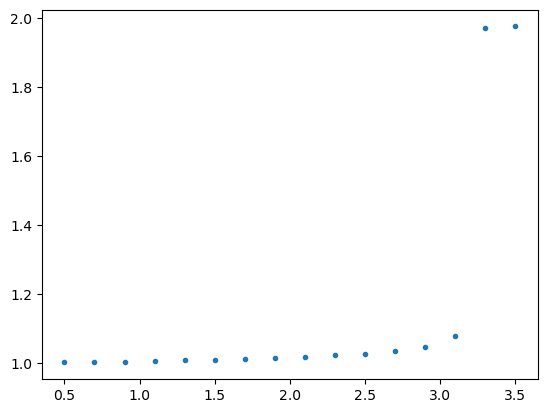

In [362]:
plt.plot([results_AF[(0,0,0,x)]['U1'] for x in range(16)],[results_AF[(0,0,0,x)]['spin'][0].iloc[0,0].real for x in range(16)],'.')

In [352]:
[OP_SDW(results_SDW[(0,0,0,x)]['spin']) for x in range(16)]

[array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(-0.),
 array(0.),
 array(0.)]

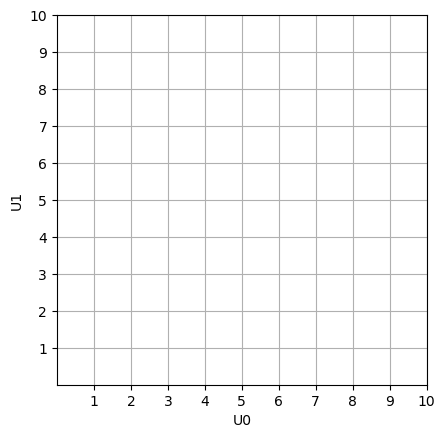

In [90]:
fig,ax=plt.subplots()
ax.grid('on')
ax.set_xticks(np.arange(1,11,1))
ax.set_yticks(np.arange(1,11,1))
ax.set_xlabel('U0')
ax.set_ylabel('U1')
# ax.set_xlim([6,10])
ax.set_aspect(1)


# Obs

In [ ]:
    # def _ansatz_to_momentum(self):
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     cc=np.zeros((Nq,2,2,2,2),dtype=complex) # a,s1,s2,alpha1,alpha2
    #     for ai_idx,ai in enumerate(self.ai_index):
    #         ccA=1/2*(self.sigma[0]+self.spinA0[ai_idx][0]*self.sigma[1]+self.spinA0[ai_idx][1]*self.sigma[2]+self.spinA0[ai_idx][2]*self.sigma[3]).conj()
    #         ccB=1/2*(self.sigma[0]+self.spinB0[ai_idx][0]*self.sigma[1]+self.spinB0[ai_idx][1]*self.sigma[2]+self.spinB0[ai_idx][2]*self.sigma[3]).conj()
    #         cc[ai_idx,:,:,0,0]=ccA
    #         cc[ai_idx,:,:,1,1]=ccB
            
    #     ai_x,q1_x,q2_x=np.meshgrid(self.ai_index[:,0],self.q[:,0],self.q[:,0],indexing='ij')
    #     ai_y,q1_y,q2_y=np.meshgrid(self.ai_index[:,1],self.q[:,1],self.q[:,1],indexing='ij')
    #     exp=np.exp(1j*((q1_x-q2_x)*ai_x+(q1_y-q2_y)*ai_y)) # a,q1,q2

    #     ave=np.tensordot(exp, cc,axes=([0],[0])) # q1,q2,s1,s2,alpha1,alpha2
    #     ave=np.tile(ave[:,:,:,:,:,:,np.newaxis],[1,1,1,1,1,1,Nk])/Nq # q1,q2,s1,s2,alpha1,alpha2, k
    #     ave=np.transpose(ave,axes=(6,0,2,4,1,3,5))
    #     return ave

# def _generate_Hartree(self,ave):
    #     '''
    #     ave q3,q4,s1,s2,alpha1,alpha2,k'
    #     '''
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     N=Nq*Nk

    #     ave=np.transpose(ave,axes=(1,4,2,5,3,6,0)) #q3,q4,s1,s2,alpha1,alpha2,k'
            
    #     ave_k=np.sum(ave,axis=-1)   #q3,q4,s1,s2,alpha1,alpha2
    #     delta_ave=np.tensordot(self.delta, ave_k,axes=([2,3],[0,1]))  # q1,q2,s1,s2,alpha1,alpha2
    #     H_H_0=np.kron(delta_ave[:,:,1,1,0,0],self.o[0,0])\
    #          +np.kron(delta_ave[:,:,1,1,1,1],self.o[1,1])\
    #          +np.kron(delta_ave[:,:,0,0,0,0],self.o[2,2])\
    #          +np.kron(delta_ave[:,:,0,0,1,1],self.o[3,3])
    #     H_H_0=H_H_0*self.U[0]/N

    #     delta_ave_s=delta_ave.trace(axis1=2,axis2=3) #q1,q2,alpha1,alpha2
    #     H_H_1=np.kron(delta_ave_s[:,:,1,1],self.o[0,0])\
    #          +np.kron(delta_ave_s[:,:,0,0],self.o[1,1])\
    #          +np.kron(delta_ave_s[:,:,1,1],self.o[2,2])\
    #          +np.kron(delta_ave_s[:,:,0,0],self.o[3,3])

    #     H_H_1=H_H_1*self.U[1]/N
    #     H_H=H_H_0+H_H_1
    #     return np.tile(H_H[:,:,np.newaxis],[1,1,Nk])
        

        # def _generate_Fock(self,ave):
    #     '''
    #     ave q3,q4,s1,s2,alpha1,alpha2,k'
    #     '''
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     N=Nq*Nk
    #     ave_k=np.sum(ave,axis=-1) # q3,q4,s1,s2,alpha1,alpha2
    #     delta_ave=np.tensordot(self.delta,ave_k,axes=([2,3],[0,1])) # q1,q2,s1,s2,alpha_1,alpha_2 Duplicated with Hartree
    #     H_F_0=np.kron(delta_ave[:,:,1,0,0,0],self.o[0,2])+\
    #           np.kron(delta_ave[:,:,0,1,0,0],self.o[2,0])+\
    #           np.kron(delta_ave[:,:,1,0,1,1],self.o[1,3])+\
    #           np.kron(delta_ave[:,:,0,1,1,1],self.o[3,1])

    #     H_F_0=-H_F_0*self.U[0]/N

    #     H_F_1=np.kron(delta_ave[:,:,0,0,1,0],self.o[0,1])+\
    #           np.kron(delta_ave[:,:,1,0,1,0],self.o[0,3])+\
    #           np.kron(delta_ave[:,:,0,0,0,1],self.o[1,0])+\
    #           np.kron(delta_ave[:,:,1,0,0,1],self.o[1,2])+\
    #           np.kron(delta_ave[:,:,0,1,1,0],self.o[2,1])+\
    #           np.kron(delta_ave[:,:,1,1,1,0],self.o[2,3])+\
    #           np.kron(delta_ave[:,:,0,1,0,1],self.o[3,0])+\
    #           np.kron(delta_ave[:,:,1,1,0,1],self.o[3,2])

    #     H_F_1=-H_F_1*self.U[1]/N

    #     H_F=H_F_0+H_F_1

    #     return np.tile(H_F[:,:,np.newaxis],[1,1,Nk])

        # def _average_old(self,energyall,wfall):
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     N=Nq*Nk
    #     energyall_sort=np.sort(energyall.flatten())
    #     mu=energyall_sort[Nq*Nk*self.nu[0]//self.nu[1]-1] # !!Need check
    #     occ=(energyall<=mu)  # k,l
    #     c=wfall.reshape((Nk,4*Nq,Nq,2,2))   # c_{k,l,q,s,alpha} !!Need check -> checked
    #     c_conj=c.conj() 
    #     occ_c=np.tile(occ[:,:,np.newaxis,np.newaxis,np.newaxis],(1,1,Nq,2,2))*c # {k,l,q,s,alpha}
    #     ave=np.zeros((Nk,Nq,2,2,Nq,2,2),dtype=complex) # k,q1,s1,alpha1,q2,s2,alpha2
    #     for k_idx in range(Nk):
    #         ave[k_idx]=np.tensordot(c_conj[k_idx],occ_c[k_idx],axes=([0],[0])) 
    #     # ave=np.tensordot(c_conj,occ_c,axes=([1],[1])) # k,q1,s1,alpha1,q2,s2,alpha2
    #     # ave=np.transpose(ave,axes=(1,4,2,5,3,6,0)) # q1,q2,s1,s2,alpha1,alpha2,k
    #     return ave



    # def print_spin(self,ave):
    #     '''
    #     ave q1,q2,s1,s2,alpha1,alpha2,k
    #     '''
    #     Nq,Nk=self.q.shape[0],self.k.shape[0]
    #     N=Nq*Nk
    #     ai_x,q1_x,q2_x=np.meshgrid(self.ai_index[:,0],self.q[:,0],self.q[:,0],indexing='ij')
    #     ai_y,q1_y,q2_y=np.meshgrid(self.ai_index[:,1],self.q[:,1],self.q[:,1],indexing='ij')
    #     exp=np.exp(-1j*(ai_x*(q1_x-q2_x)+ai_y*(q1_y-q2_y))) # ai, q1,q2
    #     ave_k=np.sum(ave,axis=-1) # q1,q2,s1,s2,alpha1,alpha2,
    #     ave_alpha_k=np.zeros((Nq,Nq,2,2,2),dtype=complex) # q1,q2,s1,s2,alpha
    #     for i in range(2):
    #         ave_alpha_k[:,:,:,:,i]=ave_k[:,:,:,:,i,i]
    #     S=np.zeros((Nq*2,4)) # (A,a1), (A,a2).. (B,a1), (B,a2)..
    #     for sigma_idx,sigma in enumerate(self.sigma):
    #         # sigma s1, s2
    #         ave_sigma=np.tensordot(ave_alpha_k,sigma,axes=([2,3],[0,1])) #q1,q2,alpha
    #         ave_exp=np.tensordot(ave_sigma, exp,axes=([0,1],[1,2]))/N # alpha, a
    #         assert np.abs(ave_exp.imag).max()<1e-10, f"spin is not real for {sigmax_idx} with {ave_exp}"
    #         S[:,sigma_idx]=ave_exp.real.flatten()
    #     print(S)
    #     return S